<a href="https://colab.research.google.com/github/GiX7000/action-recognition-with-CNNs/blob/main/full_experimentation_on_ResActionsImagesM_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring CNN architectures for Action Recognition using Image Representations of the PKU Skeletal Dataset.

## Introduction.

In this exercise, we reconstruct the method proposed in a conference [paper](http://www.image.ece.ntua.gr/papers/968.pdf) that aims to recognize human actions using pseudo-colored images. We begin by implementing the same [model](https://github.com/GiX7000/action-recognition-with-CNNs/blob/main/human_recognition_pseudo_images.ipynb) for the dataset representing the center camera of the [PKU Dataset](https://drive.google.com/drive/folders/1vTxhG0qvGkB5p-WpuHkajGe8ZFDHloDh).

Based on the initial results, we explore ways to enhance the model's performance by experimenting with various techniques, such as:

*   Adding L1/L2 regularization and dropout layers,
*   Adding/dropping layers and hidden units,
*   Testing different activation functions,learning rates and optimizers,
*   Applying cross-validation,
*   Implementing dataset balancing and data augmentation.

We evaluate the best-performing model configurations and present their results on test dataset.

We begin by importing the necessary libraries and enabling GPU acceleration.

In [ ]:
# useful imports
import torch
import torch.nn as nn
from torch import optim
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

!pip install torchinfo
import torchinfo
from torchinfo import summary

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import random
import time
from tqdm.auto import tqdm

from pathlib import Path
import shutil
import os

In [ ]:
# check Pytorch version
print(f"Pytorch version: {torch.__version__}")

# setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# check the gpu, if available
!nvidia-smi

Pytorch version: 2.5.1+cu124
Device: cuda

Fri Feb 21 15:40:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             46W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+----

As observed, we will utilize the NVIDIA A100-SXM4-40GB for the following experiments.

## Load and explore the dataset.

We load, explore, and preprocess the dataset.

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# bring the data in the current directory
!cp '/content/drive/MyDrive/Datasets-20250123T125356Z-001.zip' .

# unzip
!unzip -q Datasets-20250123T125356Z-001.zip

# remove zip file
!rm Datasets-20250123T125356Z-001.zip

# check if the given Datasets are in the current dir
!ls

Datasets  drive  sample_data


In [ ]:
# let's see how the given folder is organized
print("The given folder is organized as follows:")
print(f"Contents: {os.listdir('/content/Datasets')}")

# and what the dirs have inside
for dirpath, dirnames, filenames in os.walk('/content/Datasets'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

The given folder is organized as follows:
Contents: ['PKU', 'pku_actions_id.xlsx', 'small_dataset']
There are 2 directories and 1 images in '/content/Datasets'.
There are 4 directories and 0 images in '/content/Datasets/PKU'.
There are 3 directories and 0 images in '/content/Datasets/PKU/PKU_M_CAMERA_TRAIN_TEST_VAL'.
There are 51 directories and 0 images in '/content/Datasets/PKU/PKU_M_CAMERA_TRAIN_TEST_VAL/validation'.
There are 0 directories and 2 images in '/content/Datasets/PKU/PKU_M_CAMERA_TRAIN_TEST_VAL/validation/pat_on_back_of_other_person'.
There are 0 directories and 5 images in '/content/Datasets/PKU/PKU_M_CAMERA_TRAIN_TEST_VAL/validation/pickup'.
There are 0 directories and 5 images in '/content/Datasets/PKU/PKU_M_CAMERA_TRAIN_TEST_VAL/validation/bow'.
There are 0 directories and 5 images in '/content/Datasets/PKU/PKU_M_CAMERA_TRAIN_TEST_VAL/validation/take_off_a_hat_cap'.
There are 0 directories and 2 images in '/content/Datasets/PKU/PKU_M_CAMERA_TRAIN_TEST_VAL/validation/

With an understanding of the contents of the given dataset, we define paths for convenience and begin our exploration.

In [ ]:
# define the paths
data_path = Path('/content/Datasets/PKU')
dataM_path = data_path / 'ResActionsImagesM'
dataL_path = data_path / 'ResActionsImagesL'
dataR_path = data_path / 'ResActionsImagesR'

In [ ]:
# how many images each dataset has
print(f"Number of images in the center camera dataset: {len(os.listdir(dataM_path))}")
print(f"Number of images in the left camera dataset: {len(os.listdir(dataL_path))}")
print(f"Number of images in the right camera dataset: {len(os.listdir(dataR_path))}")

Number of images in the center camera dataset: 7152
Number of images in the left camera dataset: 7151
Number of images in the right camera dataset: 7152


Additionally, there is a file named ```pku_actions_id.xlsx``` that lists all the possible labels in the dataset. Let's determine how many labels are included and only keep the ones we need.

In [ ]:
# explore the .xlsx file
df = pd.read_excel('/content/Datasets/pku_actions_id.xlsx')
full_label_dict = {}
for i in range(len(df)):
  full_label_dict[df.iloc[i, 0]] = df.iloc[i, 1] # 1st column label, 2nd column action

print(f"Number of labels of the entire dataset: {len(full_label_dict)}")
print(f"Labels: {full_label_dict}")

Number of labels of the entire dataset: 51
Labels: {1: 'bow', 2: 'brushing hair', 3: 'brushing teeth', 4: 'check time (from watch)', 5: 'cheer up', 6: 'clapping', 7: 'cross hands in front (say stop)', 8: 'drink water', 9: 'drop', 10: 'eat meal/snack', 11: 'falling', 12: 'giving something to other person', 13: 'hand waving', 14: 'handshaking', 15: 'hopping (one foot jumping)', 16: 'hugging other person', 17: 'jump up', 18: 'kicking other person', 19: 'kicking something', 20: 'make a phone call/answer phone', 21: 'pat on back of other person', 22: 'pickup', 23: 'playing with phone/tablet', 24: 'point finger at the other person', 25: 'pointing to something with finger', 26: 'punching/slapping other person', 27: 'pushing other person', 28: 'put on a hat/cap', 29: 'put something inside pocket', 30: 'reading', 31: 'rub two hands together', 32: 'salute', 33: 'sitting down', 34: 'standing up', 35: 'take off a hat/cap', 36: 'take off glasses', 37: 'take off jacket', 38: 'take out something from

We observe that the dataset contains 51 unique labels. However, in alignment with the given paper, we will focus on 11 specific labels: ```'eat meal/snack', 'falling', 'handshaking', 'hugging other person', 'make a phone call/answer phone', 'playing with phone/tablet', 'reading', 'sitting down', 'standing up', 'typing on a keyboard', 'wear jacket'```. To proceed, we need to retrieve their corresponding IDs to filter the relevant images from the dataset.

In [ ]:
# list of the 11 selected classes
selected_classes = ['eat meal/snack', 'falling', 'handshaking', 'hugging other person', 'make a phone call/answer phone', 'playing with phone/tablet', 'reading', 'sitting down', 'standing up', 'typing on a keyboard', 'wear jacket']

# create our label dictionary
label_dict = {}
for key, value in full_label_dict.items():
  if value in selected_classes:
    label_dict[key] = value

# print our label dictionary
print(f"Number of selected labels: {len(label_dict)}")
print(f"Selected Labels: {label_dict}")

Number of selected labels: 11
Selected Labels: {10: 'eat meal/snack', 11: 'falling', 14: 'handshaking', 16: 'hugging other person', 20: 'make a phone call/answer phone', 23: 'playing with phone/tablet', 30: 'reading', 33: 'sitting down', 34: 'standing up', 46: 'typing on a keyboard', 48: 'wear jacket'}


We aim to retain only the images with IDs that correspond to our ```label_dict``` from the datasets of the center, left, and right cameras.

To begin, we select 5 images from ResActionImagesM to examine their filenames, file types (e.g., PNG, JPEG), and IDs. We then check whether all images in each dataset are of the same file type (specifically .png) and finally we filter and retain only the images whose IDs match those in our ```label_dict```.

In [ ]:
# print tthe first 5 images from M dataset
image_extensions = ('.jpg', '.jpeg', '.png') # potential types of images

# process ResActionsImagesM dataset
all_M_images = []
for root, _, files in os.walk(dataM_path):
  all_M_images.extend([os.path.join(root, file) for file in files if file.endswith(image_extensions)]) # save all images-files in a list

print("All images file paths are like these:")
all_M_images[:5] # want to check their type and their id

All images file paths are like these:


['/content/Datasets/PKU/ResActionsImagesM/0205_6205_action_18.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0243_5681_action_23.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0289_2589_action_29.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0259_15_action_29.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0068_6045_action_20.csv.png']

As we see images are of ```png``` format and their labels are embedded in the filenames, just before ```csv.png```. Since all the labels we use are two digits long, we extract them from the image filenames using the method described below.

In [ ]:
# function to retrieve images by their labels
def select_images_by_labels(image_list, label_dict):
  """ Finds and returns the images which belong at the classes of label_dict. """
  selected_images = []
  for image in image_list:
    id = image.split('/')[-1].split('.')[-3][-2:] # extract label from filename
    #print(id)
    #print(type(id))
    if id.isdigit() and int(id) in label_dict: # this if-statement very important: we retrieve 'str' and want to compare with 'int'
      selected_images.append(image)
  return selected_images

In [ ]:
# assign images to all_M_images based on label_dict
all_M_images = select_images_by_labels(all_M_images, label_dict)
print(f"Number of images in ResActionImagesM after filtering: {len(all_M_images)}")

Number of images in ResActionImagesM after filtering: 1502


In [ ]:
# let's check now all images of all_M_images list
all_M_images

['/content/Datasets/PKU/ResActionsImagesM/0243_5681_action_23.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0068_6045_action_20.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0099_3537_action_48.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0346_5352_action_23.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0254_2315_action_33.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0061_3547_action_23.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0315_6191_action_10.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0324_4852_action_34.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0260_6911_action_10.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0033_4148_action_33.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0209_6933_action_23.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0346_5341_action_11.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0194_2655_action_20.csv.png',
 '/content/Datasets/PKU/ResActionsImagesM/0238_4473_action_34.cs

We filtered the dataset down from 7.152 images to 1.502, retaining only those with labels relevant to our task. The same process will be applied to the datasets from the left and right cameras later. Finally, we verify that all images are in ```.png``` format.

In [ ]:
# check if all images of M are of the same type (png)
if all(image.endswith('.png') for image in all_M_images):
  print("All images in ResActionImagesM are of type png.")
else:
  print("Not all images in ResActionImagesM are of type png!")

All images in ResActionImagesM are of type png.


Let's now at some features or relevant properties of a random image.

Image's path: /content/Datasets/PKU/ResActionsImagesM/0061_3557_action_46.csv.png
Image's name: 0061_3557_action_46.csv.png
Image's label ID: 46
Image's label's name: typing on a keyboard

Image's shape: (25, 149, 3)
Image's type: <class 'numpy.ndarray'>
Image's elements type: float32
 


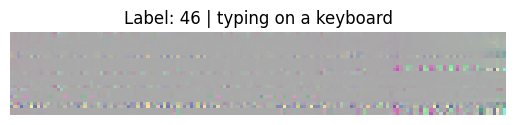

In [ ]:
# image's info
random_image = random.choice(all_M_images) # returns a random single image (image path)
print("Image's path:", random_image)
print("Image's name:", random_image.split('/')[-1])
image_label = int(random_image.split('/')[-1].split('.')[-3][-2:]) # convert to 'int' for the below comparison
print("Image's label ID:", image_label)

# find the name of the label
for key, value in label_dict.items():
  if key == image_label:
    print("Image's label's name:", value)
    break

# load the image and print its shape and type
random_img = plt.imread(random_image)
print("\nImage's shape:", random_img.shape)
print("Image's type:", type(random_img)) # image is stored as a numpy array
print("Image's elements type:", random_img.dtype) # elements of this array are of type float32
print(" ")

# visualize the image
plt.imshow(random_img)
plt.title(f"Label: {image_label} | {value}")
plt.axis('off');

# save random imagae's id and label for later use
random_image_value = value
random_image_key = key

This image will probabaly serve as one of inputs to our neural network. Since neural networks process numerical data, let's take a look at how this image is represented as numbers.

In [ ]:
# images are actually numbers of shape (25, 149, 3)
random_img

array([[[0.67058825, 0.6627451 , 0.6745098 ],
        [0.68235296, 0.63529414, 0.6627451 ],
        [0.6745098 , 0.654902  , 0.65882355],
        ...,
        [0.65882355, 0.68235296, 0.627451  ],
        [0.6509804 , 0.68235296, 0.62352943],
        [0.6627451 , 0.6666667 , 0.654902  ]],

       [[0.67058825, 0.65882355, 0.6627451 ],
        [0.6862745 , 0.6392157 , 0.65882355],
        [0.6745098 , 0.654902  , 0.6627451 ],
        ...,
        [0.6627451 , 0.69803923, 0.6509804 ],
        [0.65882355, 0.6862745 , 0.6509804 ],
        [0.6627451 , 0.6784314 , 0.65882355]],

       [[0.6745098 , 0.64705884, 0.65882355],
        [0.68235296, 0.6431373 , 0.65882355],
        [0.6745098 , 0.6509804 , 0.6666667 ],
        ...,
        [0.6666667 , 0.72156864, 0.67058825],
        [0.6627451 , 0.6862745 , 0.6627451 ],
        [0.6666667 , 0.69803923, 0.6627451 ]],

       ...,

       [[0.5019608 , 0.5411765 , 0.7019608 ],
        [0.85882354, 0.7529412 , 0.61960787],
        [0.7058824 , 0

Let's visualize 5 random images per class from ResActionsImagesM dataset.

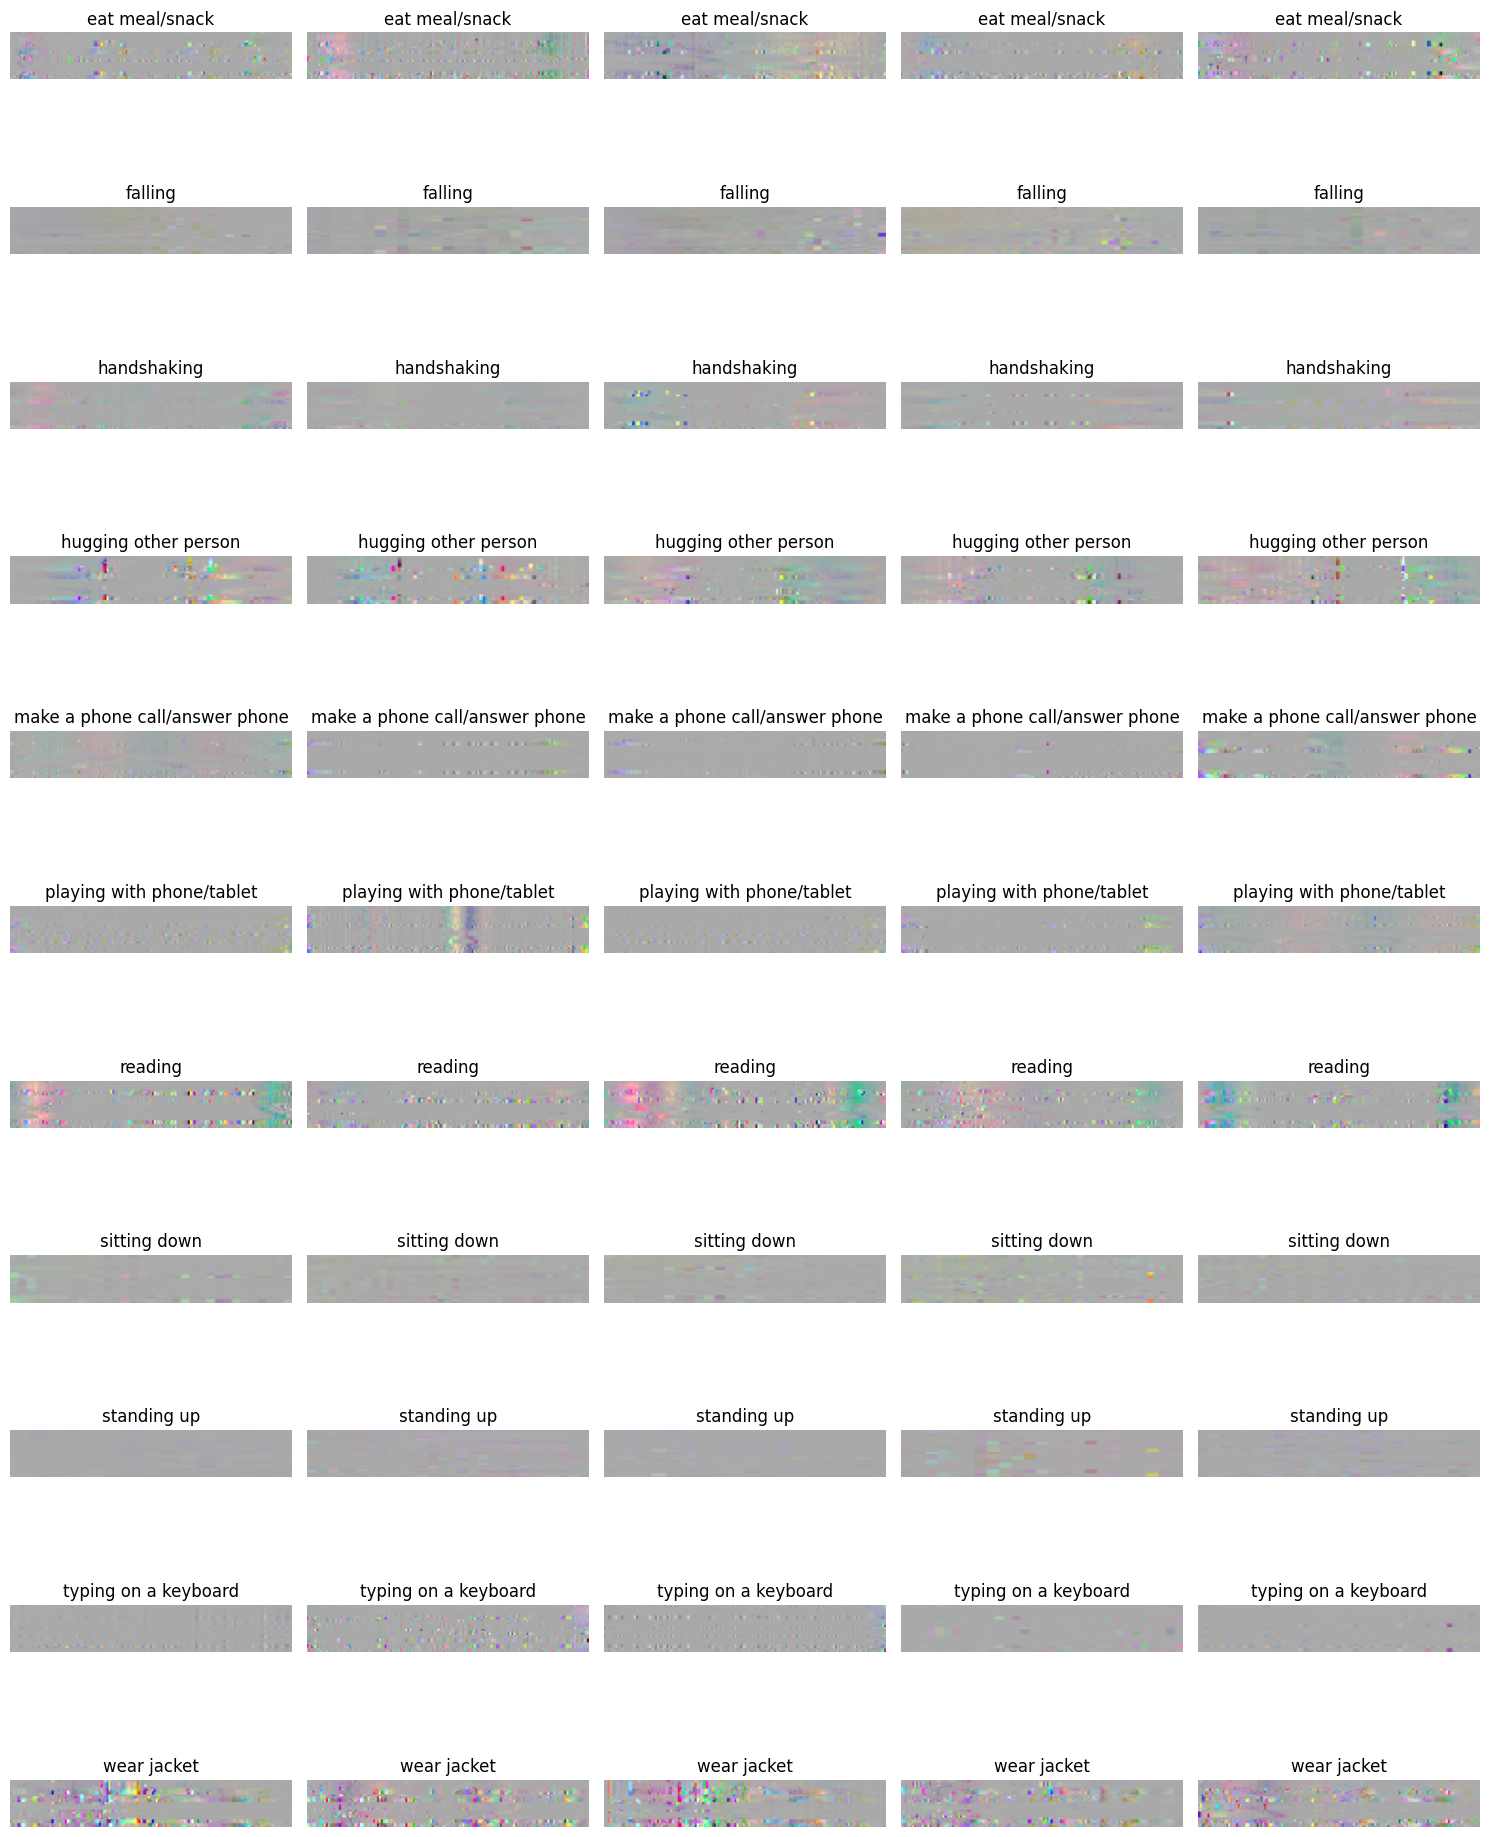

In [ ]:
plt.figure(figsize=(15, 20))
rows, columns = len(label_dict), 5 # 5 samples per class
for i, (label_id, label_name) in enumerate(label_dict.items()): # access both keys and values
  # get all image paths for the current label
  image_paths = [path for path in all_M_images if int(path.split('/')[-1].split('.')[-3][-2:]) == label_id] # all img ids are of str type, while ids on label dict are int, so convert to compare

  # if there are enough images for the current label, select 5 random of them
  if len(image_paths) >= 5:
    random_images = random.sample(image_paths, 5)

  # plot these 5 random samples for the current label
  for j, image_path in enumerate(random_images):
    plt.subplot(rows, columns, i*columns + j + 1)
    image = plt.imread(image_path)
    #print(image_path)
    plt.imshow(image)
    plt.title(label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

Let's take a closer look at the three datasets, focusing specifically on the class distributions to assess whether they are balanced or not.

In [ ]:
# function to extract only the labels from a list
def extract_labels(image_list):
  """ Extracts the labels from a list of image paths. """
  labels_list = []
  for image in image_list:
    labels = image.split('/')[-1].split('.')[-3][-2:]
    labels_list.append(labels)
  return labels_list

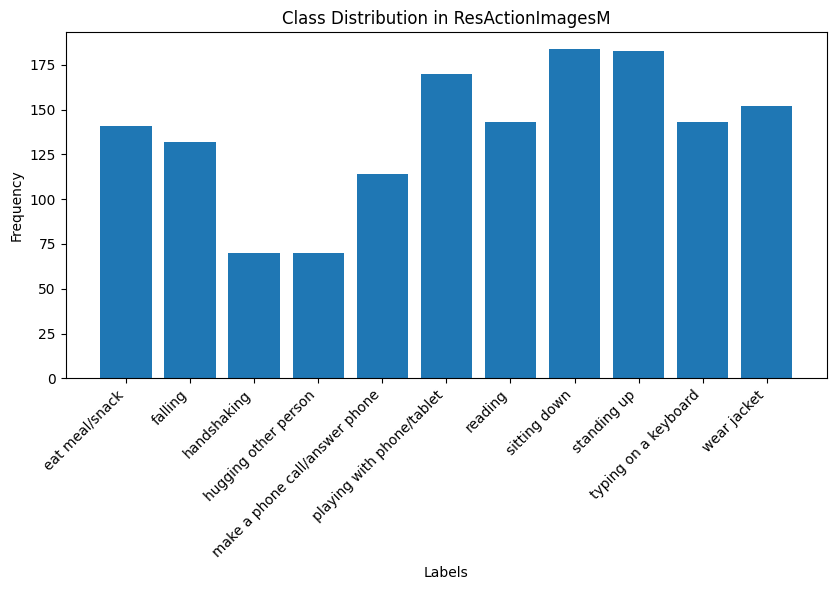

In [ ]:
# extract labels for each dataset
labels_M = extract_labels(all_M_images)

# count label occurences for each dataset
label_counts_M = {}

# count occurences for ResActionImagesM
for label in labels_M:
  if label in label_counts_M:
    label_counts_M[label] += 1
  else:
    label_counts_M[label] = 1

# some sorting for better vizs

# ensure labels are sorted as integers
sorted_labels = sorted(label_dict.keys())

# prepare sorted counts for M dataset
sorted_counts = {
    'M': [label_counts_M[str(label)] if str(label) in label_counts_M else 0 for label in sorted_labels], # a list as a value
    }

# get class names in the same order as sorted labels
label_names = [label_dict[label] for label in sorted_labels]

# plot class distribution for M daataset
plt.figure(figsize=(24, 6))

# ResActionImagesM
plt.subplot(1, 3, 1)
plt.bar(label_names, sorted_counts['M'])
plt.title('Class Distribution in ResActionImagesM')
plt.xlabel('Labels')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# class distributions in numbers
M_counts = [] # save the counts for M dataset
print("Class Distribution in ResActionImagesM:")
for label, count in zip(label_names, sorted_counts['M']):
  print(f"{label}: {count}")
  M_counts.append(count)

Class Distribution in ResActionImagesM:
eat meal/snack: 141
falling: 132
handshaking: 70
hugging other person: 70
make a phone call/answer phone: 114
playing with phone/tablet: 170
reading: 143
sitting down: 184
standing up: 183
typing on a keyboard: 143
wear jacket: 152


The bar plots show the class distributions for the datasets corresponding to the center camera (ResActionImagesM). The distribution highlights the number of images per class for the dataset, ensuring that all selected labels are represented across it. However, the dataset is not perfectly balanced, with some classes like "hugging other person" and "handshaking" having significantly fewer samples (70 images each) compared to classes like "sitting down" and "standing up," which have over 180 samples. This imbalance could impact the model's ability to accurately classify minority classes. To address this, we will try to apply [class_weights](https://saturncloud.io/blog/using-weights-in-crossentropyloss-and-bceloss-pytorch/) during training experiments to balance the contribution of each class, ensuring that the model focuses on both majority and minority classes effectively.

In [ ]:
# calculate the lists of class_weights for M dataset and convert it to tensors
class_weights_M = [1 / count for count in M_counts] # each element represents the gravity of each class in the dataset (those which are more, less gravity and vice versa!)
class_weights_M = torch.tensor(class_weights_M).to(device)
print(f"Class weights for the dataset of center camera:\n {class_weights_M}")

Class weights for the dataset of center camera:
 tensor([0.0071, 0.0076, 0.0143, 0.0143, 0.0088, 0.0059, 0.0070, 0.0054, 0.0055,
        0.0070, 0.0066], device='cuda:0')


The class_weights for the dataset demonstrates the above results and expected to be the same for the rest of datasets (right and left camera datasets). However, we can see how classes contribute differently in the dataset, with minority classes (e.g. handshaking class in third position) having higher weights and majority classes having lower weights (e.g. eat meal snack class in first position), reflecting their respective frequencies.

In [ ]:
# check the lengths of lists of images and their corresponding lists of labels
print(f"Length of all_M_images: {len(all_M_images)}, length of labels_M: {len(labels_M)}")

# check datatypes of the elements in these lists
print(f"\nDatatype of all_M_images: {type(all_M_images[0])}, datatype of labels_M: {type(labels_M[0])}") # 'str' image paths with 'str' image labels

Length of all_M_images: 1502, length of labels_M: 1502

Datatype of all_M_images: <class 'str'>, datatype of labels_M: <class 'str'>


Another processing step is to modify the labels ```['eat meal/snack', 'make a phone call/answer phone', 'playing with phone/tablet']``` to ```['eat meal snack', 'make a phone call answer phone', 'playing with phone tablet']``` to avoid issues with directory creation and file paths later when organizing our datasets.

In [ ]:
# define replacements for specific labels
replacements = {
    'eat meal/snack': 'eat meal snack',
    'make a phone call/answer phone': 'make a phone call answer phone',
    'playing with phone/tablet': 'playing with phone tablet'
}

# update the labels in label_dict
for key, value in label_dict.items():
    if value in replacements:
        label_dict[key] = replacements[value]  # use the modified label
    else:
        label_dict[key] = value  # keep the original label if no replacement is needed

# print updated label_dict to verify changes
print("Updated label_dict:")
print(label_dict)

Updated label_dict:
{10: 'eat meal snack', 11: 'falling', 14: 'handshaking', 16: 'hugging other person', 20: 'make a phone call answer phone', 23: 'playing with phone tablet', 30: 'reading', 33: 'sitting down', 34: 'standing up', 46: 'typing on a keyboard', 48: 'wear jacket'}


We aim to reorganize our dataset to match the structure of PKU_M_Camera_train_test_val. This involves creating subdirectories for train, validation, and test, with each subdirectory further divided into folders named after the class labels. The images will be distributed into these subdirectories while preserving their corresponding labels. We'll split the dataset starting from 80% for training, 10% for validation, and 10% for testing, ensuring consistent class representation across the splits(and we may increase it to 15% later). This organized structure will facilitate efficient training, validation, and evaluation of our model.

```
PKU_M_Camera_train_test_val/
  ├── train/
  │    ├── class_1/
  │    ├── class_2/
  │    └── ...
  ├── validation/
  │    ├── class_1/
  │    ├── class_2/
  │    └── ...
  └── test/
       ├── class_1/
       ├── class_2/
       └── ...
```

In [ ]:
# function to split the datasets
def train_val_test_split(data_source, split_ratios):
  """ Splits the data into train, validation, and test sets. """

  # define the sizes
  train_size = int(split_ratios[0] * len(data_source))
  val_size = int(split_ratios[1] * len(data_source))
  test_size = len(data_source) - train_size - val_size

  # shuffle the dataset to ensure the data is randomly distributed
  random.shuffle(data_source)

  # split the source dataset
  train_data = data_source[:train_size]
  val_data = data_source[train_size:train_size + val_size]
  test_data = data_source[train_size + val_size:]

  return train_data, val_data, test_data

In [ ]:
# test it on a dummy example
data_source = list(range(99))
split_ratios = (0.7, 0.15, 0.15)

# perform the split
train_data, val_data, test_data = train_val_test_split(data_source, split_ratios)

# print the results
print(f"Train set: {len(train_data)} items")
print(f"Validation set: {len(val_data)} items")
print(f"Test set: {len(test_data)} items")

Train set: 69 items
Validation set: 14 items
Test set: 16 items


In [ ]:
# function that moves images to other directories
def copy_images(image_paths, split):
  """ Moves images to the destination directory. """
  for image_path in image_paths:

    # get images's id and class name
    img_id = int(image_path.split('/')[-1].split('.')[-3][-2:])
    img_name = label_dict[img_id]

    # set the destination directory
    if 'ResActionsImagesM' in image_path:
      dataset_path = M_dataset_path

    dest_dir = os.path.join(dataset_path, split, img_name)

    # create the destination directory if it doesn't exist
    os.makedirs(dest_dir, exist_ok=True)

    # comy the image to the destination directory
    shutil.copy(image_path, dest_dir)

In [ ]:
# our new dataset's path
data_path = Path('/content/Datasets/PKU_X')
M_dataset_path = data_path / 'ResActionsImagesM'

# define splits
data_splits = ['train', 'validation', 'test']
data_ratios = [0.8, 0.1, 0.1] # 80% for training, 10% for validation, 10% for testing

# create directories for M dataset
for dataset_path in [M_dataset_path]:
  for split in data_splits:
    for label in label_dict.values():
      os.makedirs(os.path.join(dataset_path, split, label), exist_ok=True)

# split the dataset
M_train, M_val, M_test = train_val_test_split(all_M_images, data_ratios)

# move images to the appropriate directories
copy_images(M_train, 'train')
copy_images(M_val, 'validation')
copy_images(M_test, 'test')

print("Dataset organized successfully!") # check on the left of Colab

Dataset organized successfully!


In [ ]:
# print to ensure correct splitting, e.g. for ResActionsImages dataset
print(f"Total images split: {len(M_train) + len(M_val) + len(M_test)}")
print(f"Expected total images: {len(all_M_images)}")

Total images split: 1502
Expected total images: 1502


Let's analyze the dataset in detail by examining how many images are present in each class subdirectory. Additionally, we'll calculate the total number of images in the parent directories: train, validation, and test for the dataset.

In [ ]:
# let's see how the given folder is organized
for dirpath, dirnames, filenames in os.walk(data_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '/content/Datasets/PKU_X'.
There are 3 directories and 0 images in '/content/Datasets/PKU_X/ResActionsImagesM'.
There are 11 directories and 0 images in '/content/Datasets/PKU_X/ResActionsImagesM/validation'.
There are 0 directories and 5 images in '/content/Datasets/PKU_X/ResActionsImagesM/validation/handshaking'.
There are 0 directories and 6 images in '/content/Datasets/PKU_X/ResActionsImagesM/validation/hugging other person'.
There are 0 directories and 15 images in '/content/Datasets/PKU_X/ResActionsImagesM/validation/wear jacket'.
There are 0 directories and 13 images in '/content/Datasets/PKU_X/ResActionsImagesM/validation/playing with phone tablet'.
There are 0 directories and 19 images in '/content/Datasets/PKU_X/ResActionsImagesM/validation/sitting down'.
There are 0 directories and 21 images in '/content/Datasets/PKU_X/ResActionsImagesM/validation/standing up'.
There are 0 directories and 15 images in '/content/Datasets/PKU_X/ResAction

Let's calculate the total number of images in each train, validation, and test directory by combining all the images from their respective class subdirectories.

In [ ]:
# image counter funcion
def image_count(dir):
  """ Counts the total number of images in a directory. """

  # nitialize counters for train, val and test sets
  train_images, val_images, test_images = 0, 0, 0

  # walk through the dataset directry
  for dirpath, dirnames, filenames in os.walk(dir):
    # check if the subdir is train, val or test
    if 'train' in dirpath:
      train_images += len(filenames) # count images in train subdir
    elif 'validation' in dirpath:
      val_images += len(filenames) # count images in val subdir
    elif 'test' in dirpath:
      test_images += len(filenames) # count images in test subdir

  print(f"There are {train_images} images in the train directory of {str(dir).split('/')[-1]} dataset.") # need to convert a PosixPath(dir) to a string before attempt to split it
  print(f"There are {val_images} images in the validation directory of {str(dir).split('/')[-1]} dataset.")
  print(f"There are {test_images} images in the test directory of {str(dir).split('/')[-1]} dataset.")

In [ ]:
# all images of all dirs of M dataset
image_count(M_dataset_path)

There are 1201 images in the train directory of ResActionsImagesM dataset.
There are 150 images in the validation directory of ResActionsImagesM dataset.
There are 151 images in the test directory of ResActionsImagesM dataset.


As a final data processing step, we need to ensure that the data are ready for the network (in the form of tensors). First, we examine if the dataset is normalized by calculating its mean and standard deviation. If the dataset is not already normalized (or we want to align it to our normlization standards), we apply [Normalization](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html) to adjust the pixel values to the desired range (e.g. a zero mean and unit standard deviation). Additionally, if we observe that the data are already scaled (range between [0, 1]), we skip any further scaling and directly implement a transformation pipeline. Our final pipeline includes converting the images to tensors, with the required channel permutation (from last to first dimension) automatically handled by [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html), and normalizing them using the calculated mean and standard deviation.

In [ ]:
# function to calculate mean and std across all images
def mean_std_calculation(image_paths):
  """ Calculates the mean and standard deviation of a dataset. """

  # initialize variables
  total_mean = np.array([0.0, 0.0, 0.0]) # 3-d for 3 color chhannels
  total_std = np.array([0.0, 0.0, 0.0])
  n_pixels = 0  # total number of pixels across all images

  for image_path in image_paths:
    # read the image using plt.imread
    image = plt.imread(image_path)  # shape of (H, W, C)

    # convert the image to float if needed
    #if image.dtype != np.float32:
    #    image = image.astype(np.float32) / 255.0  # scale to [0, 1] if raw pixel values

    # accumulate mean and std for each channel for the entire dataset
    n_pixels += image.shape[0] * image.shape[1]
    total_mean += image.mean(axis=(0, 1)) * image.shape[0] * image.shape[1] # weighted contribution of each image to the dataset on the fly!
    total_std += ((image - image.mean(axis=(0, 1)))**2).sum(axis=(0, 1))

  # mean and std calculations
  total_mean /= n_pixels
  total_std = np.sqrt(total_std / n_pixels)

  print(f"Dataset Mean (per channel): {total_mean}")
  print(f"Dataset Std (per channel): {total_std}")

```total_mean += image.mean(axis=(0, 1)) * image.shape[0] * image.shape[1]```
: This command calculates the mean of each color channel across the height and width of an image( image.mean(axis=(0, 1)) ), then scales it by the total number of pixels (height x width) to reflect the sum of all pixel values for each channel. The scaled mean is added to total_mean, ensuring that the contribution of each image to the dataset mean is weighted by its size, allowing for accurate computation of the overall mean across a dataset with varying image sizes.

In [ ]:
# check if the dataset is normalized
mean_std_calculation(all_M_images)

Dataset Mean (per channel): [0.66428914 0.6632426  0.66349681]
Dataset Std (per channel): [0.05539324 0.05346889 0.05324469]


In [ ]:
# calculated mean and std for normalization for the center camera dataset
mean_M = [0.664, 0.663, 0.663]
std_M = [0.055, 0.054, 0.053]

# define the basic final data transformation
data_transform_M = transforms.Compose([
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=mean_M, std=std_M)  # normalize to mean and std
])

This transformation ensures that our inputs to the CNN are in the appropriate form, with normalized pixel values and correctly ordered dimensions for optimal processing.

In [ ]:
# let's see at how our dummy image look like
transformed_random_img = data_transform_M(random_img)
print(f"Transformed image's shape: {transformed_random_img.shape}")
print(f"Transformed image's type: {type(transformed_random_img)}")
print(f"Transformed image's elements type: {transformed_random_img.dtype}")
print(f"Transformed image:\n {transformed_random_img}")

Transformed image's shape: torch.Size([3, 25, 149])
Transformed image's type: <class 'torch.Tensor'>
Transformed image's elements type: torch.float32
Transformed image:
 tensor([[[ 1.1979e-01,  3.3369e-01,  1.9109e-01,  ..., -9.4117e-02,
          -2.3672e-01, -2.2816e-02],
         [ 1.1979e-01,  4.0499e-01,  1.9109e-01,  ..., -2.2816e-02,
          -9.4117e-02, -2.2816e-02],
         [ 1.9109e-01,  3.3369e-01,  1.9109e-01,  ...,  4.8486e-02,
          -2.2816e-02,  4.8486e-02],
         ...,
         [-2.9462e+00,  3.5422e+00,  7.6150e-01,  ..., -1.9479e+00,
          -9.4973e-01, -3.3027e+00],
         [ 1.9109e-01,  3.3369e-01,  1.9109e-01,  ...,  5.3961e+00,
           4.8486e-02, -2.8036e+00],
         [ 1.9109e-01,  3.3369e-01,  1.9109e-01,  ...,  3.5422e+00,
          -2.2816e-02, -2.8036e+00]],

        [[-4.7198e-03, -5.1307e-01, -1.4996e-01,  ...,  3.5839e-01,
           3.5839e-01,  6.7902e-02],
         [-7.7341e-02, -4.4045e-01, -1.4996e-01,  ...,  6.4887e-01,
           

## The baseline CNN model.

We implement the CNN model from the paper in PyTorch, which will serve as a baseline for our experiments.

In [ ]:
# baseline CNN model
class CNN(nn.Module):
  """ CNN model architecture based on the structure proposed in the given notebook. """
  def __init__(self, in_features: int, out_features: int, hidden_units: list):
    super().__init__() # initialize the initializer!

    # A. define the components of nn

    # 1. feature extractor blocks
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[1], kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[1], kernel_size=3, padding='valid'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.block3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # 2. classifier
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=1024, out_features=128),  # we set 1024 as in_features to ensure compatibility
        nn.SELU(),
        nn.Linear(in_features=128, out_features=out_features)
    )

  # B. define how the above components are combined into a CNN (feature extractor + classifier)
  def forward(self, x):
    x = self.block3(self.block2(self.block1(x)))
    x = self.classifier(x)
    return x

We will use [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) later, so we do not include softmax in the architecture.

We set the in_features of the classifier's first nn.Linear layer to 1024. This decision was made after encountering an error, which occurred because the output of the feature extractor did not match the expected input size of the classifier. To fix this, the output of the feature extractor (which is 2 x 1024) must match the input of the classifier. Since the classifier expects an input with shape N x 128 (it's 128 according to the paper's implementation), we adjusted the in_features parameter of the classifier to 1024 to ensure compatibility.

In [ ]:
# create a model of class_CNN and see how it looks like
num_classes=11
num_channels=3 # number of color channels
init_hidden_units=[16, 32, 64]
model=CNN(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units).to(device)
print(model)
print(" ")

# let's also print its summary along with its params
summary(model, input_size=(1, 3, 25, 149)) # (batch_size, channels, height, width)

CNN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): SELU()
    (3): Linear(in_features=128, out_features=11, bias=True)
  )
)
 


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 11]                   --
├─Sequential: 1-1                        [1, 16, 11, 73]           --
│    └─Conv2d: 2-1                       [1, 16, 23, 147]          448
│    └─ReLU: 2-2                         [1, 16, 23, 147]          --
│    └─MaxPool2d: 2-3                    [1, 16, 11, 73]           --
├─Sequential: 1-2                        [1, 32, 4, 35]            --
│    └─Conv2d: 2-4                       [1, 32, 11, 73]           4,640
│    └─ReLU: 2-5                         [1, 32, 11, 73]           --
│    └─Conv2d: 2-6                       [1, 32, 9, 71]            9,248
│    └─ReLU: 2-7                         [1, 32, 9, 71]            --
│    └─MaxPool2d: 2-8                    [1, 32, 4, 35]            --
├─Sequential: 1-3                        [1, 64, 1, 16]            --
│    └─Conv2d: 2-9                       [1, 64, 2, 33]            18,496
│   

In [ ]:
# let's see how many total parameters we have to estimate in each training
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}") # notice if we add all values of the above Param column, we must take the same number!

# let's see all of them
print(" ")
model.state_dict()

Total trainable parameters: 165451
 


OrderedDict([('block1.0.weight',
              tensor([[[[ 0.1389, -0.0476,  0.1120],
                        [ 0.1143, -0.0946, -0.1430],
                        [ 0.1299, -0.1680,  0.0004]],
              
                       [[ 0.0950,  0.1426,  0.1658],
                        [-0.1668,  0.1155, -0.0901],
                        [-0.0731, -0.1267, -0.1511]],
              
                       [[-0.1104, -0.1829,  0.1314],
                        [-0.0167,  0.0876,  0.0259],
                        [ 0.1887, -0.1149,  0.1832]]],
              
              
                      [[[-0.1314, -0.0445, -0.1463],
                        [-0.0043, -0.1756, -0.1077],
                        [ 0.1773,  0.0750,  0.0350]],
              
                       [[ 0.1897, -0.0840,  0.0469],
                        [-0.0655,  0.0931, -0.1062],
                        [ 0.1918, -0.0574, -0.0238]],
              
                       [[ 0.0812, -0.1215,  0.0496],
                       

Our objective is to train the CNN by optimizing all these 165.451 trainable parameters. Each of them plays a crucial role in learning patterns and features from the data, enabling the model to make accurate predictions. Obviously, this number of parameters depends on the model's architecture, so when experimenting with for example hidden layer sizes, it changes. Through the training process, the optimization algorithm will iteratively update these parameters to minimize the loss function and improve the model's performance.

Let's examine an image both before and after it is processed by the CNN.

In [ ]:
# test on a dummy example (our random selected image from above)

# to get into th CNN, image must be a tensor: in our case random_img is already a Tensor
# this is just to ensure it
if not isinstance(random_img, torch.Tensor):
  random_img = torch.tensor(random_img, dtype=torch.float32)  # convert NumPy array to PyTorch tensor if needed
else:
  random_img = random_img.clone().detach()  # safely clone and detach if it's already a tensor (it came after error!)

# check the shape and the image (pixels) before entering the CNN
print(f"Image's shape: {random_img.shape} -> [height, width, color_channels]")
print(f"Single image pixel values:\n{random_img}")
print(" ")

# bring color channels in the front
random_img = random_img.permute(2, 0, 1) # [height, width, color_channels] -> [color_channels, height, width]
print(f"Image's shape after permuting: {random_img.shape}")
print(" ")

# add batch dimension
random_img = random_img.unsqueeze(dim=0).to(device) # [color_channels, height, width] -> [batch_size, color_channels, height, width]
print(f"Image's shape after unsqueezing: {random_img.shape}")

# pass it through the CNN and see the output of CNN
output = model(random_img).to(device) # unsqueeze to add batch_size
print("\nTesting on untrained model ...\n")
print(f"CNN's output logits:\n {output}\n")
print(f"CNN's output prediction probabilities:\n {torch.softmax(output, dim=1)}\n")

image_predicted_label_index = torch.argmax(torch.softmax(output, dim=1), dim=1).item()
#print(f"CNN's output prediction label at index: {image_predicted_label_index}")

# retrieve the id and class label from label_dict using the predicted index
predicted_image_label = list(label_dict.values())[image_predicted_label_index] # convert all values of label_dict in a list and retrieve its image_predicted_label_index
predicted_image_id = list(label_dict.keys())[image_predicted_label_index] # convert all keys of label_dict in a list and retrieve its image_predicted_label_index

# print prediction and actual values
print(f"CNN's output prediction Label: {predicted_image_id} | {predicted_image_label}")
print(f"Actual Label: {random_image_key} | {random_image_value}")

Image's shape: torch.Size([25, 149, 3]) -> [height, width, color_channels]
Single image pixel values:
tensor([[[0.6706, 0.6627, 0.6745],
         [0.6824, 0.6353, 0.6627],
         [0.6745, 0.6549, 0.6588],
         ...,
         [0.6588, 0.6824, 0.6275],
         [0.6510, 0.6824, 0.6235],
         [0.6627, 0.6667, 0.6549]],

        [[0.6706, 0.6588, 0.6627],
         [0.6863, 0.6392, 0.6588],
         [0.6745, 0.6549, 0.6627],
         ...,
         [0.6627, 0.6980, 0.6510],
         [0.6588, 0.6863, 0.6510],
         [0.6627, 0.6784, 0.6588]],

        [[0.6745, 0.6471, 0.6588],
         [0.6824, 0.6431, 0.6588],
         [0.6745, 0.6510, 0.6667],
         ...,
         [0.6667, 0.7216, 0.6706],
         [0.6627, 0.6863, 0.6627],
         [0.6667, 0.6980, 0.6627]],

        ...,

        [[0.5020, 0.5412, 0.7020],
         [0.8588, 0.7529, 0.6196],
         [0.7059, 0.7216, 0.6706],
         ...,
         [0.5569, 0.7255, 0.5608],
         [0.6118, 0.7647, 0.5451],
         [0.4824,

The output shape of the neural network is [1, 11], representing a batch size of 1 and 11 output classes. These values are the raw logits produced by the final fully connected layer, which are just scores indicating the model's confidence for each class. To convert these logits as probabilities, we apply the softmax function, which normalizes them into a range of [0, 1] (with all probabilities summing to 1). The class with the highest probability is selected as the predicted label using argmax. This process—starting from raw logits, converting them to probabilities, and selecting the class with the highest score forms the basic process of the model's prediction work.

In the model's summary above, we observe that the output shape remains unchanged after activation functions but changes after Conv2d and MaxPool2d layers. Let's quickly examine how the output shape changes by passing our dummy image through these two layers separately.

In [ ]:
# remember random_img's shape is (3, 25, 149)
random_image = random_img.squeeze(dim=0) # remove the batch dimension

# create a single conv and maxpool layers
example_conv = nn.Conv2d(in_channels=3, out_channels=11, kernel_size=3, padding='valid').to(device)
example_maxpool = nn.MaxPool2d(kernel_size=2, stride=2).to(device)

# pass the random_img through the conv layer
conv_output = example_conv(random_img)
print(f"Conv output shape: {conv_output.shape}")

# of course pixels have different values and shapes
#conv_output

# pass convolution's output through the MaxPool layer
maxpool_output = example_maxpool(conv_output)
print(f"MaxPool output shape: {maxpool_output.shape}")

# let's see the impact of maxpool layer in a tiny tensor
tiny_random_tensor = torch.randn(size=(1, 4, 4))
print(f"\nRandom tensor:\n{tiny_random_tensor}")
print(f"Random tensor shape: {tiny_random_tensor.shape}")

tiny_maxpool_output = example_maxpool(tiny_random_tensor)
print(f"\nMaxPool output:\n{tiny_maxpool_output}")
print(f"MaxPool output shape: {tiny_maxpool_output.shape}")

Conv output shape: torch.Size([1, 11, 23, 147])
MaxPool output shape: torch.Size([1, 11, 11, 73])

Random tensor:
tensor([[[ 0.1152, -2.0802, -0.1505,  0.0680],
         [ 0.9854,  0.4412,  2.3001,  0.0430],
         [ 0.9330,  1.0351, -0.8552,  0.5741],
         [ 0.1005, -0.4798,  2.6764, -1.6192]]])
Random tensor shape: torch.Size([1, 4, 4])

MaxPool output:
tensor([[[0.9854, 2.3001],
         [1.0351, 2.6764]]])
MaxPool output shape: torch.Size([1, 2, 2])


The Conv2d layer reduces the spatial dimensions slightly while maintaining the number of channels, as seen in the output shape [11, 23, 147]. The MaxPool2d layer further downsamples (to the half) the spatial dimensions significantly while keeping the channels constant, resulting in [11, 11, 73]. This quick and dummy example highlights how these layers extract features and reduce image's size progressively.

We also create some helper functions for training and evaluating model's performance.

In [ ]:
# helper functions

# set seeds function
def set_seeds():
  """ Set random seeds for reproducibility. """
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

# function to calculate accuracy
def accuracy_fn(y_true, y_pred):
  """ Calculates accuracy between truth labels and predictions. """
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

# train step function
def train_step(model, dataloader, loss_fn, optimizer, regularization=None, reg_lambda=0.0):
  """ Trains a PyTorch model for a single epoch. """

  ## put the model in a train mode
  model.train()

  # setup train loss and accuracy values
  train_loss, train_acc = 0, 0

  # loop through dataloader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # send data to target device
    X, y = X.to(device), y.to(device)

    # 1. forward pass
    y_pred = model(X)

    # 2. calculate loss
    loss = loss_fn(y_pred, y)

    # add L1 or L2 regularization, if specified
    if regularization == 'L1':
      l1_reg = 0
      for param in model.parameters():
        if param.requires_grad: # ensure to apply L2 on trainable params
          l1_reg += torch.norm(param, p=1)
      loss += reg_lambda * l1_reg
    elif regularization == 'L2':
      l2_reg = 0
      for param in model.parameters():
        if param.requires_grad: # ensure to apply L2 on trainable params
          l2_reg += torch.norm(param, p=2)
      loss += reg_lambda * l2_reg

    train_loss += loss.item()

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # apply weight constraints after each optimizer step
    apply_max_norm_constraints(model)

    # 6. calculate and accumulate accuracy
    #y_pred_probs = torch.softmax(y_pred, dim=1) # apply softmax to get probabilities
    y_pred_class = torch.argmax(y_pred, dim=1) # get the max of raw logits
    train_acc += ((y_pred_class == y).sum().item()/len(y_pred_class))

  # adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

# test set function
def test_step(model, dataloader, loss_fn, regularization=None, reg_lambda=0.0):
  """ Tests a PyTorch model for a single epoch. """

  # put the model in eval mode
  model.eval()

  # setup test loss and accuracy values
  test_loss, test_acc = 0, 0

  # turn on inference context manager
  with torch.inference_mode():
    # loop through dataloader and data batches
    for batch, (X, y) in enumerate(dataloader):
      # send data to target device
      X, y = X.to(device), y.to(device)

      # 1. forward pass
      test_pred_logits = model(X)

      # 2. calculate loss
      loss = loss_fn(test_pred_logits, y)

      # add L1 or L2 regularization, if specified
      if regularization == 'L1':
        l1_reg = 0
        for param in model.parameters():
          if param.requires_grad: # ensure to apply L2 on trainable params
            l1_reg += torch.norm(param, p=1)
        loss += reg_lambda * l1_reg
      elif regularization == 'L2':
        l2_reg = 0
        for param in model.parameters():
          if param.requires_grad: # ensure to apply L2 on trainable params
            l2_reg += torch.norm(param, p=2)
        loss += reg_lambda * l2_reg

      test_loss += loss.item()

      # 3. calculate and accumulate accuracy across all batches
      #test_pred_probs = torch.softmax(test_pred_logits, dim=1)
      test_pred_labels = torch.argmax(test_pred_logits, dim=1) # index of best prediction
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

# train function: train step for epochs
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, regularization=None, reg_lambda=0.0, early_stopping=False, patience=5, delta=0.001):
  """ Trains and tests a PyTorch model with optional regulariation and early stopping. """

  # create a results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "val_loss": [],
             "val_acc": [],
             "best_epoch": 0,
             "stopped_epoch":-1}

  # early stopping variables
  best_loss = float('inf')
  epochs_without_improvement = 0
  best_model_weights = None

  # loop through training and test steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       regularization=regularization,
                                       reg_lambda=reg_lambda)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    regularization=regularization,
                                    reg_lambda=reg_lambda)

    # print what's happening
    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
      f"val_loss: {test_loss:.4f} | "
      f"val_acc: {test_acc:.4f}"
    )

    # update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(test_loss)
    results["val_acc"].append(test_acc)

    # early stopping process
    if early_stopping:
      if test_loss < best_loss - delta: # it could be test_acc also!
        best_loss = test_loss
        best_model_weights = model.state_dict()
        epochs_without_improvement = 0
        results["best_epoch"] = epoch
      else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}.")
          results["stopped_epoch"] = epoch + 1
          break

  # restore and save best weights, if early stopping is requested
  if early_stopping:
    model.load_state_dict(best_model_weights)
    print(f"Model restored from epoch {results['best_epoch'] + 1}.")

  # return the filled results at the end of the epochs
  return results

# plot loss curves function
def plot_loss_curves(results):
  """ Plots training curves of a results dictionary. """

  # get all values from the dictionary
  loss = results['train_loss']
  val_loss = results['val_loss']
  acc = results['train_acc']
  val_acc = results['val_acc']

  # also figure out in how many epochs training occured
  epochs = range(len(results['train_loss']))

  # setup a plot
  plt.figure(figsize=(15, 5))

  # plot losses
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid(True)

  # plot accuracies
  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label='train_acc')
  plt.plot(epochs, val_acc, label='val_acc')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

# evaluation function for the model on test set (dataloader)
def eval_model(model, dataloader, loss_fn):
  """ Makes predictions o the test set and returns a dictionary with the results. """

  # initialize test loss and accuracy
  loss, acc = 0, 0

  # storage lists for actual and predicted labels
  actual_labels = []
  predicted_labels = []

  # set the evaluation mode
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(dataloader):

      # ensure that they are on device
      X, y = X.to(device), y.to(device)

      # make prediction with the model
      y_pred = model(X)

      # calculate loss and accuracy
      loss += loss_fn(y_pred, y)
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) # to predict: logits->probs->labels
      acc += (y_pred_class == y).sum().item()/len(y_pred_class)

      # store predictions and acyual labels
      actual_labels.extend(y.cpu().numpy())
      predicted_labels.extend(y_pred_class.cpu().numpy())

    # adjust metrics to get average loss and accuracy per batch
    loss = loss / len(dataloader)
    acc = acc / len(dataloader)

  return {"model_name": model.__class__.__name__, # only works when model was created as a class
          "test_loss": loss.item(),
          "test_acc": acc,
          "y_true": actual_labels,
          "y_preds": predicted_labels}

# function to apply max-norm constraints
def apply_max_norm_constraints(model, max_norm=2.0):
  for name, param in model.named_parameters():
    if 'weight' in name: # apply constraints to only weights
      param.data.clamp_(-max_norm, max_norm) # in-place operation

To calculate the accuracies in both the train and test step functions, we use torch.argmax directly on logits to determine the predicted class because the relative order of logits remains the same, and the class with the highest score is unchanged. Applying softmax is unnecessary for accuracy calculations, as it only rescales the logits into probabilities without affecting the result of argmax. Therefore, using logits is computationally efficient and yields the same correct predictions.

However, in the case of predictions, we use softmax because it transforms the logits into probabilities that are more understandable for humans. Probabilities are particularly useful when communicating model confidence, analyzing prediction uncertainty, or displaying results in a way that is easier to understand. For example, in the pred_and_plot_image function, softmax is applied to show the predicted class along with its associated probability, providing insight into how confident the model is in its prediction.

Notice that we use optional L1 and L2 regularization during the training and test step functions, but not in the evaluation mode for the test dataloader, because regularization is designed to influence the optimization process by penalizing large weights to reducing overfitting. In evaluation mode, our focus is solely on assessing the model's performance on unseen data, and including regularization would artificially influence the loss, making it less reflective of the model's true predictive ability. Therefore, the evaluation loss is kept free of regularization to provide a pure measure of the model's fit to the test data.

The ```apply_max_norm_constraints``` function applies max-norm constraints on the weights of a PyTorch model, clamping their values within a specified range (-max_norm to max_norm) during training. It ensures weight stability and prevents exploding gradients, promoting generalization by restricting the parameter space. This function is equivalent to kernel_constraint=max_norm(max_value=2) implemented in the given TensorFlow's code example. It is useful when our model suffers from overfitting and it is applied after each training step (e.g., after optimizer.step()) to maintain constraints on weights.

## 1. Train and Evaluate the baseline CNN.

To prepare the ```Dataset``` for training, we use PyTorch's [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), which automatically assigns labels based on the subdirectory names within the dataset. After organizing the dataset into train and validation directories, we apply the basic transformation pipeline defied above to the data. These transformations ensure that the data are scaled appropriately and ready for input into the CNN.

Next, we create [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) instances for the training and validation datasets. The training DataLoader is configured to shuffle the data for better generalization, while the validation DataLoader keeps the order consistent. Each ```DataLoader``` is set with an initial batch size of 32 and uses multiple workers for efficient data loading.

With the dataset prepared and DataLoaders configured, the model is ready for training on ResActionsImagesM. The resulting model will serve as a baseline for comparison in future experiments.

### Create datasets and dataloaders.

In [ ]:
# define directories
train_M_dir = '/content/Datasets/PKU_X/ResActionsImagesM/train'
val_M_dir = '/content/Datasets/PKU_X/ResActionsImagesM/validation'
test_M_dir = '/content/Datasets/PKU_X/ResActionsImagesM/test'

# create train, val and test datasets using ImageFolder
train_data_M = ImageFolder(root=train_M_dir, transform=data_transform_M)
val_data_M = ImageFolder(root=val_M_dir, transform=data_transform_M)
test_data_M = ImageFolder(root=test_M_dir, transform=data_transform_M)

# verify the datasets
print(f"Number of training samples: {len(train_data_M)}")
print(f"Number of validation samples: {len(val_data_M)}")
print(f"Number of test samples: {len(test_data_M)}")
print(f"Class names: {train_data_M.classes}")
print(f"\nTrain data:\n{train_data_M}\nValidation data:\n{val_data_M}\nTest data:\n{test_data_M}")

Number of training samples: 1201
Number of validation samples: 150
Number of test samples: 151
Class names: ['eat meal snack', 'falling', 'handshaking', 'hugging other person', 'make a phone call answer phone', 'playing with phone tablet', 'reading', 'sitting down', 'standing up', 'typing on a keyboard', 'wear jacket']

Train data:
Dataset ImageFolder
    Number of datapoints: 1201
    Root location: /content/Datasets/PKU_X/ResActionsImagesM/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.664, 0.663, 0.663], std=[0.055, 0.054, 0.053])
           )
Validation data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: /content/Datasets/PKU_X/ResActionsImagesM/validation
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.664, 0.663, 0.663], std=[0.055, 0.054, 0.053])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 151
    Root location: /conten

In [ ]:
# take an image and see some info
img, label = train_data_M[0] # take the first training sample
label_name = train_data_M.classes[label]
print(f"Image tensor:\n {img}")
print(f"\nImage shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Image label name: {label_name}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[ 0.1198,  0.2624,  0.4050,  ...,  0.1911,  0.1198,  0.3337],
         [ 0.1911,  0.6189,  0.2624,  ...,  0.0485, -0.0228, -0.0228],
         [ 0.2624,  0.9754,  0.1911,  ..., -0.0228, -0.0941, -0.4506],
         ...,
         [ 1.2606,  2.5440,  1.0467,  ..., -0.8071,  0.6902, -0.5932],
         [ 2.1162, -1.3775, -1.0210,  ...,  1.2606, -3.8731, -0.0228],
         [ 0.1198,  1.8310, -1.4488,  ..., -0.4506, -1.3062, -0.8071]],

        [[ 0.1405,  0.5036,  0.2858,  ...,  0.1405,  0.1405,  0.7941],
         [ 0.2131,  0.7215,  0.1405,  ...,  0.0679,  0.0679,  0.4310],
         [ 0.2131,  1.0120,  0.0679,  ..., -0.0047, -0.0047,  0.2858],
         ...,
         [ 0.0679, -0.5857, -1.4572,  ...,  3.0454, -2.4739,  1.1572],
         [-0.4404,  0.7941, -0.2952,  ..., -1.7476,  3.3359, -0.3678],
         [ 0.1405,  1.6656, -1.6024,  ..., -2.8370,  1.0846, -0.5857]],

        [[-0.0048,  0.1432,  0.3652,  ...,  0.2912,  0.2172,  0.4391],
         [-0.0048,  0.0692,  0

Notice that the image label is now represented by the index corresponding to the classes list in the ImageFolder dataset, rather than the initial ID from the original dataset. We can easily retrieve the label name by using the ```classes``` attribute of the ImageFolder instance, mapping, in this way, the label index to its corresponding class name.

In [ ]:
# setup batch size and number of workers
batch_size = 32
num_workers = os.cpu_count() # if we work on cpu
print(f"Number of workers: {num_workers}")

# create dataLoaders
train_dataloader_M = DataLoader(dataset=train_data_M, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader_M = DataLoader(dataset=val_data_M, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader_M = DataLoader(dataset=test_data_M, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# check the lengths of dataloaders
print(f"Length of train dataloader: {len(train_dataloader_M)} batches of {batch_size} samples")
print(f"Length of val dataloader: {len(val_dataloader_M)} batches of {batch_size} samples")
print(f"Length of test dataloader: {len(test_dataloader_M)} batches of {batch_size} samples")

# take an image from a dataloader and check its shape. again
img, label = next(iter(train_dataloader_M))
print(f"Dataloader's image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Number of workers: 12
Length of train dataloader: 38 batches of 32 samples
Length of val dataloader: 5 batches of 32 samples
Length of test dataloader: 5 batches of 32 samples
Dataloader's image shape: torch.Size([32, 3, 25, 149])
Label shape: torch.Size([32])


We observe that we have 38 batches of 32 samples in the training dataloader, which equals 1216 images, and 5 batches of 32 samples each in the validation and test dataloaders, totaling 160 images per set. This gives us a combined total of 1536 images, which is more than the 1502 images in the dataset. This difference occurs because the final incomplete batches (with fewer than 32 samples) are included by default in PyTorch's DataLoader. These smaller batches account for the additional images reported by the batch counts, but they do not represent extra data, they simply reflect how the dataset is divided into batches. With the below code, we verify the right total number of images processed by the dataloaders, which match the dataset sizes.

The output 'Label shape: torch.Size([32])' means that the dataloader provides a batch of 32 labels, where each label corresponds to one image in the batch. The shape [32] indicates that the labels are a 1D tensor containing 32 elements, with each element representing the class index (as an integer) of the corresponding image.

In [ ]:
# function to calculate the total images in a dataloader
def total_images(dataloader):
  """ Calculates the total number of images in a dataloader. """

  # a dataloader is of shape (batach_size, channels, height, width), where batch_size = the number of images in the batch
  total_images = 0 # initialize the images counter
  for images, _ in dataloader:
    batch_size = images.shape[0] # get the number of images for the current batch
    total_images += batch_size
  return total_images

In [ ]:
# verify the total number of images by calculating all images in train, val and test dataloaders
total_train_images = total_images(train_dataloader_M)
total_val_images = total_images(val_dataloader_M)
total_test_images = total_images(test_dataloader_M)

# print the results
print(f"Total images in train dataloader: {total_train_images}")
print(f"Total images in val dataloader: {total_val_images}")
print(f"Total images in test dataloader: {total_test_images}")

Total images in train dataloader: 1201
Total images in val dataloader: 150
Total images in test dataloader: 151


### Create and train the baseline CNN model.

With the DataLoaders prepared, we are ready to begin our first CNN training for this exercise. To ensure consistency and reproducibility, we set random seeds for PyTorch and CUDA, ensuring the same training behavior and outcomes across multiple runs.

In this initial experiment, we train the baseline CNN from the paper on the ResActionsImagesM dataset. Following the original setup, we use CrossEntropyLoss as the loss function, RMSprop as the optimizer with its default initial learning rate of 0.001, batch size of 32 and the number of epochs to 34.

In [ ]:
# set random seeds
set_seeds()

# set the number of epochs (initial number of 34 just like in paper's implementation)
num_epochs = 34

# ensure we are on device (if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create an instance of the model
model_0 = CNN(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units).to(device)

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # weight=class_weights_M : add class_weights to somehow balance the dataset
optimizer = torch.optim.RMSprop(params=model_0.parameters(), lr=0.001)

# start the timer
start_time = time.time()

# start training
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_M,
                        test_dataloader=val_dataloader_M,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=num_epochs)

end_time = time.time()

# calculate and print the total training time
model_0_training_time = end_time - start_time
print(f"\nTotal training time: {model_0_training_time:.3f} seconds")

# calculate and print total trainable params
model_0_total_params = sum(p.numel() for p in model_0.parameters() if p.requires_grad)
print(f"Total trainable parameters: {model_0_total_params}")

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9769 | train_acc: 0.3839 | val_loss: 1.1690 | val_acc: 0.5920
Epoch: 2 | train_loss: 0.9848 | train_acc: 0.6732 | val_loss: 0.8748 | val_acc: 0.7540
Epoch: 3 | train_loss: 0.7418 | train_acc: 0.7468 | val_loss: 0.6350 | val_acc: 0.7699
Epoch: 4 | train_loss: 0.5112 | train_acc: 0.8269 | val_loss: 0.6441 | val_acc: 0.7727
Epoch: 5 | train_loss: 0.4093 | train_acc: 0.8687 | val_loss: 0.5963 | val_acc: 0.8131
Epoch: 6 | train_loss: 0.3161 | train_acc: 0.8974 | val_loss: 0.5437 | val_acc: 0.8358
Epoch: 7 | train_loss: 0.2452 | train_acc: 0.9154 | val_loss: 0.5365 | val_acc: 0.8574
Epoch: 8 | train_loss: 0.2135 | train_acc: 0.9305 | val_loss: 0.9632 | val_acc: 0.6892
Epoch: 9 | train_loss: 0.1820 | train_acc: 0.9401 | val_loss: 0.5006 | val_acc: 0.8568
Epoch: 10 | train_loss: 0.1154 | train_acc: 0.9665 | val_loss: 0.5746 | val_acc: 0.8080
Epoch: 11 | train_loss: 0.0872 | train_acc: 0.9753 | val_loss: 0.5031 | val_acc: 0.8790
Epoch: 12 | train_loss: 0.1385 | train_ac

The results indicate overfitting, as the training accuracy reaches 100% with extremely low loss, while the validation accuracy remains consistently lower and fluctuates within a stable range, failing to close the gap with the training performance. Experiments such as adding regularization and increasing dropout will be explored to address overfitting in the followiing experiments.

In [ ]:
# add to the results dictionary total training time and params
model_0_results['total_train_time'] = model_0_training_time
model_0_results['total_params'] = model_0_total_params

# print and save the training results dictionary to csv
model_0_results_df = pd.DataFrame(model_0_results)
#print(model_0_results_df)
model_0_results_df.to_csv('model_0_results_df.csv', index=False)
print("Results dictionary saved to csv.")

Results dictionary saved to csv.


### Evaluate and save the model.

In [ ]:
# check what the model_0 results keys(what the results dictionary has inside)
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc', 'best_epoch', 'stopped_epoch', 'total_train_time', 'total_params'])

We will use these 4 things ('train_loss', 'train_acc', 'val_loss', 'val_acc'), which include the results of the training, to plot the loss and accuracy curves. Loss and accuracy curves are valuable tools (or evaluation metric) for tracking a model's progress over time. Plotting these curves provides insight into how well the model is learning during training and validation. By visualizing both loss and accuracy, we can better assess the model's performance and identify potential issues, such as overfitting or underfitting, during the training process.

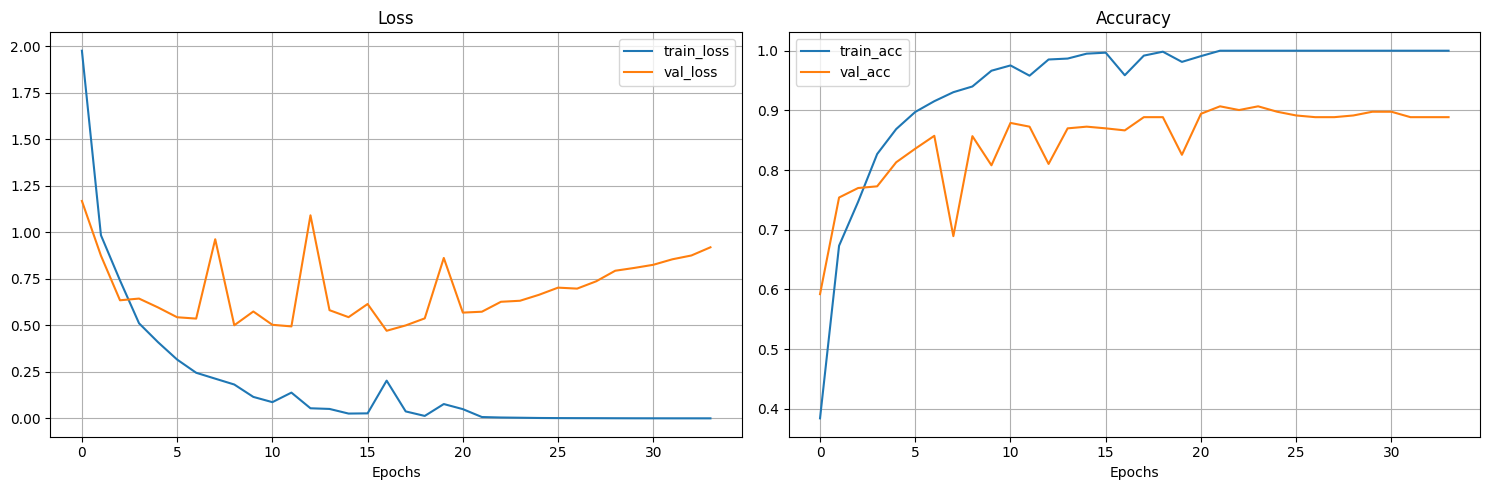

In [ ]:
# plot the curves
plot_loss_curves(model_0_results)

Numerically, we see that the training accuracy reaches 100% with near-zero training loss, while the validation accuracy reaches almost 90%, and the validation loss shows slight fluctuations. The graphs verify that overfitting is an issue because the training loss decreases to almost zero, while validation loss is increasing and going away. Training accuracy line reaches 100%, while the validation one diverges slightly and also be away from training line. To address overfitting, we start experimenting with trying L1 and L2 regularization as well as adding dropout layers to the net.

In [ ]:
# compute and print model_0 generalization gap
gen_gap_model_0 = model_0_results['train_acc'][-1] - model_0_results['val_acc'][-1]
print(f"\nModel_0 generalization gap (train acc - val acc): {gen_gap_model_0:.4f}")


Model_0 generalization gap (train acc - val acc): 0.1114


The generalization gap of highlights overfitting. Our goal is to minimize this gap, ideally making it close to zero or negative, to ensure the model generalizes well to unseen data.

In [ ]:
# evaluate on test set/dataloader - this is just for curiosity!
model_0_test_results = eval_model(model=model_0,
                                  dataloader=test_dataloader_M,
                                  loss_fn=loss_fn)
model_0_test_results['test_acc']

  0%|          | 0/5 [00:01<?, ?it/s]

0.9176630434782609

The baseline model achieved an impressive test accuracy of 91%, but it holds little value since the model suffers from overfitting.

In [ ]:
# save the results on test set
model_0_test_results_df = pd.DataFrame(model_0_test_results)
model_0_test_results_df.to_csv('model_0_test_results_df.csv', index=False)
print("Results saved to 'model_0_test_results_df.csv'")

Results saved to 'model_0_test_results_df.csv'


In [ ]:
# save the model for later use
torch.save(model_0.state_dict(), 'model_0_M.pth')
print("Model saved to 'model_0_M.pth'")

Model saved to 'model_0_M.pth'


## 2. Basic Experimentation.

We start performing our experiments in the following order:

1.   Regularization techniques: L1/L2 regularization, add dropout layers.
2.   Architecture adjustements: add/remove layers, change hidden units.
3.   Hyperparameter Tuning: tweak learning rates, experiment with optimizers, modify activation functions and adjust batch size.
4.   Cross-Validation: use K-fold cross-validation to evaluate model generalization.
5.   Data Balancing: use of class weights in the loss function and apply Data augmentation.
6.  Try on different datasets: datasets with different camera views or smaller datasets.
7.  Transfer Learning: use pre-trained models and fine-tune them on our dataset to improve performance with fewer resources.

We intend to follow this plan to first address overfitting and then progressively optimize the model in order to achieve the best possible performance. Of course the sequence of experiments depends on our problem and objectives we want to achieve each time.

The final two experiments (6, covering 20 experiments on 7 different datasets, and 7, transfer learning only on the small dataset) will be conducted in the second notebook, titled ```full_experimentation_on_ResActionsImages_variants_and_transfer_learning_with_CNNs.ipynb```.

In [ ]:
# set some initial hyyperparams
init_dropout_probs = [0, 0, 0, 0] # [block1, block2, block3, classifier]
init_activation_functions = [nn.ReLU(), nn.SELU()] # [feature extractor, classifier]

We modify the model's class to enable the application of various combinations.

In [ ]:
# CNN model version 2
class CNN_v2(nn.Module):
  """ CNN baseline model architecture with dropout layers. """
  def __init__(self, in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units, dropout_probs=init_dropout_probs, activation_functions=init_activation_functions):
    super().__init__() # initialize the initializer!

    # A. define the components of nn

    # 1. feature extractor blocks
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
        activation_functions[0],
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=dropout_probs[0]) # spatial dropout for conv2d
    )

    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[1], kernel_size=3, padding='same'),
        activation_functions[0],
        nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[1], kernel_size=3, padding='valid'),
        activation_functions[0],
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=dropout_probs[1]) # spatial dropout for conv2d
    )

    self.block3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
        activation_functions[0],
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=dropout_probs[2]) # spatial dropout for conv2d
    )

    # dynamically calculate the output of the feaature extractor/classifier's input by passing a dummy input
    dummy_input = torch.randn(1, in_features, 25, 149)
    with torch.no_grad():
      output = self.block3(self.block2(self.block1(dummy_input))) # shape of (batch_size, channels, height, width)
      #print(output.shape)
      classifier_input_size = output.shape[1] * output.shape[2] * output.shape[3]

    # 2. classifier
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=classifier_input_size, out_features=128),  # we set in_features dynamically through a dummy pass to ensure compatibility
        activation_functions[1],
        nn.Dropout(p=dropout_probs[3]), # standarrd dropout for fully connected layers
        nn.Linear(in_features=128, out_features=out_features)
    )

  # B. define how the above components are combined into a CNN (feature extractor + classifier)
  def forward(self, x):
    x = self.block3(self.block2(self.block1(x)))
    x = self.classifier(x)
    return x

### 2.1. Experimenting with L1 / L2 Regularization.

[L1 and L2 regularization techniques](https://www.geeksforgeeks.org/regularization-in-machine-learning/) are used in machine learning to prevent overfitting by adding a penalty to the model's complexity. In short, ```L1 regularization``` encourages sparsity (most elements are zero) by adding the sum of the absolute values of the coefficients to the loss function, leading to some weights being driven to zero. ```L2 regularization``` (or Ridge), adds the sum of the squared values of the coefficients, promoting smaller weights and improving generalization. Both methods help the model to improve model performance on unseen data. We will try both of them and select the one with better results ([L1/L2 regularization in Pytorch](https://www.geeksforgeeks.org/l1l2-regularization-in-pytorch/)).

In [ ]:
# experiment 2.1.1: L1 regularization with different lambda regularization values
print("Experiment 2.1.1: L1 Regularization")

# set random seeds
set_seeds()

# lambda regularization values to experiment with
lambda_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # np.logspace(-2, -6, num=5)
print("Lambda regularization values to try:", lambda_values)

# storage dictionary for all dropout probs
model_1_L1_all_results = {}

# loop over all lambda_values list
start_time = time.time()
for decay in lambda_values:
  print(f"\nTesting with lambda: {decay}")

  # create model instance
  model_1_L1 = CNN(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units).to(device)

  # setup loss function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.RMSprop(params=model_1_L1.parameters(), lr=0.001)

  # start training
  model_1_L1_results = train(model=model_1_L1,
                             train_dataloader=train_dataloader_M,
                             test_dataloader=val_dataloader_M,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=num_epochs,
                             regularization='L1',
                             reg_lambda=decay)

  # save the results for the current weight decay
  model_1_L1_all_results[decay] = model_1_L1_results

# calculate and print the total time for this experiment
end_time = time.time()
print(f"\nTotal experiment's time for the model_1 with L1 regularization: {end_time-start_time:.3f} seconds")

# calculate the total trainable params
model_1_L1_total_params = sum(p.numel() for p in model_1_L1.parameters() if p.requires_grad)
print(f"Total trainable parameters: {model_1_L1_total_params}")

Experiment 2.1.1: L1 Regularization
Lambda regularization values to try: [0.01, 0.001, 0.0001, 1e-05, 1e-06]

Testing with lambda: 0.01


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.6978 | train_acc: 0.1009 | val_loss: 3.8490 | val_acc: 0.0938
Epoch: 2 | train_loss: 3.6897 | train_acc: 0.1270 | val_loss: 3.4614 | val_acc: 0.0938
Epoch: 3 | train_loss: 3.4469 | train_acc: 0.1248 | val_loss: 3.3317 | val_acc: 0.0938
Epoch: 4 | train_loss: 3.3507 | train_acc: 0.1248 | val_loss: 3.2677 | val_acc: 0.0938
Epoch: 5 | train_loss: 3.2984 | train_acc: 0.1234 | val_loss: 3.2307 | val_acc: 0.0938
Epoch: 6 | train_loss: 3.2668 | train_acc: 0.1241 | val_loss: 3.2074 | val_acc: 0.0938
Epoch: 7 | train_loss: 3.2464 | train_acc: 0.1270 | val_loss: 3.1929 | val_acc: 0.0938
Epoch: 8 | train_loss: 3.2336 | train_acc: 0.1270 | val_loss: 3.1833 | val_acc: 0.0938
Epoch: 9 | train_loss: 3.2247 | train_acc: 0.1263 | val_loss: 3.1769 | val_acc: 0.0938
Epoch: 10 | train_loss: 3.2187 | train_acc: 0.1255 | val_loss: 3.1723 | val_acc: 0.0938
Epoch: 11 | train_loss: 3.2152 | train_acc: 0.1241 | val_loss: 3.1691 | val_acc: 0.0938
Epoch: 12 | train_loss: 3.2122 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0921 | train_acc: 0.2484 | val_loss: 2.2480 | val_acc: 0.3682
Epoch: 2 | train_loss: 2.0084 | train_acc: 0.4837 | val_loss: 1.9168 | val_acc: 0.4864
Epoch: 3 | train_loss: 1.6937 | train_acc: 0.5971 | val_loss: 1.7910 | val_acc: 0.4670
Epoch: 4 | train_loss: 1.4833 | train_acc: 0.6431 | val_loss: 1.4469 | val_acc: 0.6426
Epoch: 5 | train_loss: 1.3426 | train_acc: 0.6956 | val_loss: 1.3358 | val_acc: 0.6790
Epoch: 6 | train_loss: 1.2964 | train_acc: 0.6913 | val_loss: 1.3083 | val_acc: 0.7108
Epoch: 7 | train_loss: 1.1933 | train_acc: 0.7266 | val_loss: 1.2691 | val_acc: 0.6989
Epoch: 8 | train_loss: 1.1635 | train_acc: 0.7372 | val_loss: 1.1681 | val_acc: 0.7136
Epoch: 9 | train_loss: 1.1182 | train_acc: 0.7529 | val_loss: 1.2493 | val_acc: 0.7239
Epoch: 10 | train_loss: 1.0563 | train_acc: 0.7692 | val_loss: 1.2715 | val_acc: 0.6778
Epoch: 11 | train_loss: 1.0446 | train_acc: 0.7791 | val_loss: 1.0357 | val_acc: 0.7824
Epoch: 12 | train_loss: 1.0057 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2212 | train_acc: 0.3026 | val_loss: 1.8223 | val_acc: 0.3193
Epoch: 2 | train_loss: 1.4302 | train_acc: 0.5905 | val_loss: 1.1752 | val_acc: 0.6568
Epoch: 3 | train_loss: 1.0786 | train_acc: 0.6860 | val_loss: 0.9138 | val_acc: 0.7727
Epoch: 4 | train_loss: 0.8822 | train_acc: 0.7651 | val_loss: 0.9941 | val_acc: 0.6761
Epoch: 5 | train_loss: 0.8326 | train_acc: 0.7841 | val_loss: 0.9098 | val_acc: 0.7551
Epoch: 6 | train_loss: 0.6774 | train_acc: 0.8192 | val_loss: 0.8359 | val_acc: 0.7733
Epoch: 7 | train_loss: 0.6135 | train_acc: 0.8529 | val_loss: 0.9080 | val_acc: 0.7818
Epoch: 8 | train_loss: 0.5878 | train_acc: 0.8571 | val_loss: 0.6652 | val_acc: 0.8631
Epoch: 9 | train_loss: 0.5268 | train_acc: 0.8679 | val_loss: 1.4460 | val_acc: 0.6261
Epoch: 10 | train_loss: 0.4992 | train_acc: 0.8918 | val_loss: 0.6274 | val_acc: 0.8540
Epoch: 11 | train_loss: 0.4457 | train_acc: 0.8983 | val_loss: 0.6682 | val_acc: 0.8602
Epoch: 12 | train_loss: 0.3797 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0393 | train_acc: 0.2965 | val_loss: 1.5987 | val_acc: 0.3722
Epoch: 2 | train_loss: 1.3192 | train_acc: 0.5506 | val_loss: 1.1171 | val_acc: 0.5892
Epoch: 3 | train_loss: 0.9586 | train_acc: 0.7013 | val_loss: 1.0906 | val_acc: 0.6420
Epoch: 4 | train_loss: 0.7184 | train_acc: 0.7651 | val_loss: 0.9585 | val_acc: 0.6585
Epoch: 5 | train_loss: 0.6308 | train_acc: 0.7995 | val_loss: 0.6953 | val_acc: 0.7642
Epoch: 6 | train_loss: 0.4962 | train_acc: 0.8463 | val_loss: 0.6414 | val_acc: 0.8205
Epoch: 7 | train_loss: 0.3700 | train_acc: 0.8874 | val_loss: 0.5405 | val_acc: 0.8386
Epoch: 8 | train_loss: 0.3403 | train_acc: 0.8900 | val_loss: 0.6602 | val_acc: 0.7858
Epoch: 9 | train_loss: 0.2990 | train_acc: 0.9188 | val_loss: 0.6753 | val_acc: 0.8261
Epoch: 10 | train_loss: 0.2292 | train_acc: 0.9277 | val_loss: 0.6101 | val_acc: 0.8636
Epoch: 11 | train_loss: 0.2014 | train_acc: 0.9465 | val_loss: 0.4631 | val_acc: 0.8790
Epoch: 12 | train_loss: 0.2078 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9589 | train_acc: 0.3232 | val_loss: 1.5818 | val_acc: 0.3597
Epoch: 2 | train_loss: 1.1320 | train_acc: 0.6159 | val_loss: 1.0162 | val_acc: 0.6636
Epoch: 3 | train_loss: 0.7941 | train_acc: 0.7287 | val_loss: 0.7116 | val_acc: 0.7472
Epoch: 4 | train_loss: 0.5805 | train_acc: 0.7979 | val_loss: 0.8050 | val_acc: 0.7352
Epoch: 5 | train_loss: 0.4594 | train_acc: 0.8512 | val_loss: 0.5614 | val_acc: 0.8222
Epoch: 6 | train_loss: 0.3739 | train_acc: 0.8833 | val_loss: 0.5623 | val_acc: 0.8199
Epoch: 7 | train_loss: 0.2817 | train_acc: 0.9120 | val_loss: 0.4873 | val_acc: 0.8727
Epoch: 8 | train_loss: 0.2031 | train_acc: 0.9336 | val_loss: 0.5302 | val_acc: 0.8540
Epoch: 9 | train_loss: 0.1789 | train_acc: 0.9385 | val_loss: 0.9366 | val_acc: 0.7290
Epoch: 10 | train_loss: 0.1864 | train_acc: 0.9408 | val_loss: 0.4191 | val_acc: 0.8915
Epoch: 11 | train_loss: 0.1006 | train_acc: 0.9688 | val_loss: 0.4298 | val_acc: 0.8727
Epoch: 12 | train_loss: 0.1039 | train_ac

For the first lambda value we tried, we observe that the validation accuracy remains low and stable, suggesting that the L1 regularization with this lambda value is too weak to effectively tackle overfitting. As a result, the model fails to generalize well, leading to stable performance. Similarly, for the other lambda values, the training accuracy consistently surpasses the validation accuracy, indicating that L1 regularization alone is insufficient to address overfitting in this scenario.

In [ ]:
# experiment 2.1.2: L2 regularization with different weight decay values
print("Experiment 2.1.2: L2 Regularization")

# set random seeds
set_seeds()

# weight decay values to experiment with
weight_decay_values = lambda_values
print("Weight decay values to try:", weight_decay_values)

# storage dictionary for all dropout probs
model_1_L2_all_results = {}

# loop over all weight_decay values
start_time = time.time()
for decay in weight_decay_values:
  print(f"\nTesting with weight decay: {decay}")

  # create model instance
  model_1_L2 = CNN(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units).to(device)

  # setup loss function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.RMSprop(params=model_1_L2.parameters(), lr=0.001, weight_decay=decay)

  # start training
  model_1_L2_results = train(model=model_1_L2,
                             train_dataloader=train_dataloader_M,
                             test_dataloader=val_dataloader_M,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=num_epochs)

  # save the results for the current weight decay
  model_1_L2_all_results[decay] = model_1_L2_results

# calculate and print the total experiment's time
end_time = time.time()
print(f"\nTotal experiment's time for the model_1 with L2 regularization: {end_time-start_time:.3f} seconds")

# calculate and print total trainable params
model_1_L2_total_params = sum(p.numel() for p in model_1_L2.parameters() if p.requires_grad)
print(f"Total trainable parameters: {model_1_L2_total_params}")

Experiment 2.1.2: L2 Regularization
Weight decay values to try: [0.01, 0.001, 0.0001, 1e-05, 1e-06]

Testing with weight decay: 0.01


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0178 | train_acc: 0.3381 | val_loss: 1.3962 | val_acc: 0.4943
Epoch: 2 | train_loss: 1.2629 | train_acc: 0.5672 | val_loss: 1.1121 | val_acc: 0.5642
Epoch: 3 | train_loss: 1.0413 | train_acc: 0.6469 | val_loss: 1.0379 | val_acc: 0.6330
Epoch: 4 | train_loss: 0.8357 | train_acc: 0.7341 | val_loss: 0.8629 | val_acc: 0.7176
Epoch: 5 | train_loss: 0.6704 | train_acc: 0.7733 | val_loss: 0.7324 | val_acc: 0.7568
Epoch: 6 | train_loss: 0.6293 | train_acc: 0.7905 | val_loss: 0.7095 | val_acc: 0.7523
Epoch: 7 | train_loss: 0.5456 | train_acc: 0.8154 | val_loss: 0.6615 | val_acc: 0.8108
Epoch: 8 | train_loss: 0.4561 | train_acc: 0.8481 | val_loss: 0.6536 | val_acc: 0.8233
Epoch: 9 | train_loss: 0.3969 | train_acc: 0.8579 | val_loss: 0.6505 | val_acc: 0.8165
Epoch: 10 | train_loss: 0.3606 | train_acc: 0.8728 | val_loss: 0.5620 | val_acc: 0.8290
Epoch: 11 | train_loss: 0.3098 | train_acc: 0.8884 | val_loss: 0.5188 | val_acc: 0.8506
Epoch: 12 | train_loss: 0.2846 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1269 | train_acc: 0.2590 | val_loss: 1.4848 | val_acc: 0.4545
Epoch: 2 | train_loss: 1.3255 | train_acc: 0.5723 | val_loss: 1.0455 | val_acc: 0.6358
Epoch: 3 | train_loss: 0.8641 | train_acc: 0.6979 | val_loss: 0.9581 | val_acc: 0.6460
Epoch: 4 | train_loss: 0.7060 | train_acc: 0.7471 | val_loss: 0.6627 | val_acc: 0.8131
Epoch: 5 | train_loss: 0.5459 | train_acc: 0.7989 | val_loss: 0.6624 | val_acc: 0.8040
Epoch: 6 | train_loss: 0.4550 | train_acc: 0.8391 | val_loss: 0.7163 | val_acc: 0.7909
Epoch: 7 | train_loss: 0.3711 | train_acc: 0.8800 | val_loss: 0.5011 | val_acc: 0.8693
Epoch: 8 | train_loss: 0.3390 | train_acc: 0.8744 | val_loss: 0.4409 | val_acc: 0.8784
Epoch: 9 | train_loss: 0.2636 | train_acc: 0.9188 | val_loss: 0.6781 | val_acc: 0.8381
Epoch: 10 | train_loss: 0.1824 | train_acc: 0.9391 | val_loss: 0.5169 | val_acc: 0.8483
Epoch: 11 | train_loss: 0.1592 | train_acc: 0.9450 | val_loss: 0.5447 | val_acc: 0.8693
Epoch: 12 | train_loss: 0.1901 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9506 | train_acc: 0.3426 | val_loss: 1.3065 | val_acc: 0.5699
Epoch: 2 | train_loss: 1.1677 | train_acc: 0.6079 | val_loss: 1.1086 | val_acc: 0.5852
Epoch: 3 | train_loss: 0.9182 | train_acc: 0.6927 | val_loss: 1.0320 | val_acc: 0.6188
Epoch: 4 | train_loss: 0.6196 | train_acc: 0.7948 | val_loss: 0.6479 | val_acc: 0.7852
Epoch: 5 | train_loss: 0.4679 | train_acc: 0.8415 | val_loss: 0.7600 | val_acc: 0.7028
Epoch: 6 | train_loss: 0.3726 | train_acc: 0.8735 | val_loss: 0.5834 | val_acc: 0.7892
Epoch: 7 | train_loss: 0.2711 | train_acc: 0.9089 | val_loss: 0.4514 | val_acc: 0.8477
Epoch: 8 | train_loss: 0.2383 | train_acc: 0.9212 | val_loss: 0.5844 | val_acc: 0.8330
Epoch: 9 | train_loss: 0.1648 | train_acc: 0.9411 | val_loss: 1.8250 | val_acc: 0.6562
Epoch: 10 | train_loss: 0.3565 | train_acc: 0.9121 | val_loss: 0.3825 | val_acc: 0.8943
Epoch: 11 | train_loss: 0.0945 | train_acc: 0.9787 | val_loss: 0.4339 | val_acc: 0.8881
Epoch: 12 | train_loss: 0.0721 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0089 | train_acc: 0.2996 | val_loss: 1.5035 | val_acc: 0.4483
Epoch: 2 | train_loss: 1.1949 | train_acc: 0.5966 | val_loss: 1.0188 | val_acc: 0.6085
Epoch: 3 | train_loss: 0.8726 | train_acc: 0.7244 | val_loss: 1.0233 | val_acc: 0.6420
Epoch: 4 | train_loss: 0.6455 | train_acc: 0.7808 | val_loss: 1.1862 | val_acc: 0.5966
Epoch: 5 | train_loss: 0.5620 | train_acc: 0.8201 | val_loss: 0.6645 | val_acc: 0.7517
Epoch: 6 | train_loss: 0.4455 | train_acc: 0.8579 | val_loss: 0.5870 | val_acc: 0.8017
Epoch: 7 | train_loss: 0.3363 | train_acc: 0.8957 | val_loss: 0.4758 | val_acc: 0.8420
Epoch: 8 | train_loss: 0.2981 | train_acc: 0.8966 | val_loss: 0.5311 | val_acc: 0.8261
Epoch: 9 | train_loss: 0.2635 | train_acc: 0.9178 | val_loss: 0.4529 | val_acc: 0.8631
Epoch: 10 | train_loss: 0.1765 | train_acc: 0.9434 | val_loss: 0.4986 | val_acc: 0.8449
Epoch: 11 | train_loss: 0.1603 | train_acc: 0.9507 | val_loss: 0.3970 | val_acc: 0.8449
Epoch: 12 | train_loss: 0.1400 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9488 | train_acc: 0.3308 | val_loss: 1.6934 | val_acc: 0.4131
Epoch: 2 | train_loss: 1.1788 | train_acc: 0.6018 | val_loss: 1.0284 | val_acc: 0.6608
Epoch: 3 | train_loss: 0.8783 | train_acc: 0.7075 | val_loss: 0.8934 | val_acc: 0.6909
Epoch: 4 | train_loss: 0.7000 | train_acc: 0.7666 | val_loss: 0.9272 | val_acc: 0.6915
Epoch: 5 | train_loss: 0.5389 | train_acc: 0.8285 | val_loss: 0.7405 | val_acc: 0.7756
Epoch: 6 | train_loss: 0.4258 | train_acc: 0.8652 | val_loss: 0.7401 | val_acc: 0.7648
Epoch: 7 | train_loss: 0.3607 | train_acc: 0.8746 | val_loss: 0.5644 | val_acc: 0.8665
Epoch: 8 | train_loss: 0.2390 | train_acc: 0.9197 | val_loss: 0.5580 | val_acc: 0.8443
Epoch: 9 | train_loss: 0.2049 | train_acc: 0.9269 | val_loss: 0.7847 | val_acc: 0.7852
Epoch: 10 | train_loss: 0.1373 | train_acc: 0.9581 | val_loss: 0.4993 | val_acc: 0.8761
Epoch: 11 | train_loss: 0.2418 | train_acc: 0.9227 | val_loss: 0.4560 | val_acc: 0.8881
Epoch: 12 | train_loss: 0.0785 | train_ac

From the above numerical results, it is evident that L2 regularization alone is not sufficient to address overfitting. To proceed, we will examine whether the generalization gap is reduced in either case (L1 or L2). If so, we can select the lambda (decay) value that minimizes the generalization gap, whether it comes from L1 or L2 regularization. Then, we combine it with dropout layers to explore further reductions in this gap.

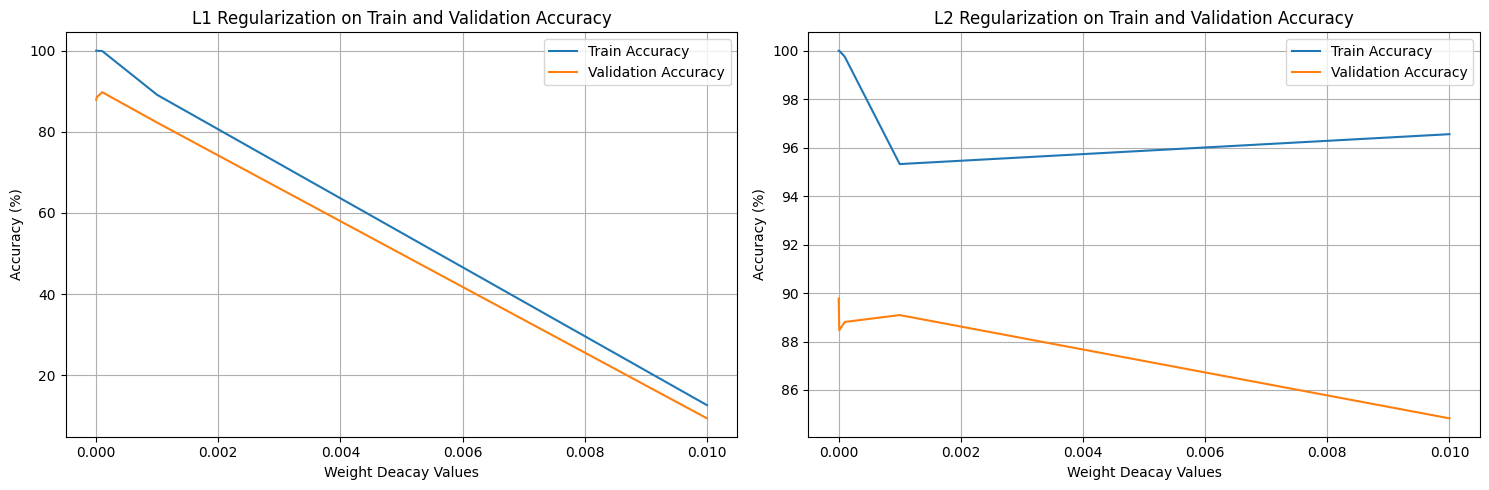

In [ ]:
# plot weight decay values vs. train and val accuracies for L1 and L2 regularizations
plt.figure(figsize=(15, 5))

# experiment 1.1
plt.subplot(1, 2, 1)
train_accuracies_L1 = []
val_accuracies_L1 = []
for weight_decay_value, results in model_1_L1_all_results.items():
  train_accuracies_L1.append(results["train_acc"][-1]*100)
  val_accuracies_L1.append(results["val_acc"][-1]*100)

plt.plot(weight_decay_values, train_accuracies_L1, label="Train Accuracy")
plt.plot(weight_decay_values, val_accuracies_L1, label="Validation Accuracy")
plt.xlabel("Weight Deacay Values")
plt.ylabel("Accuracy (%)")
plt.title("L1 Regularization on Train and Validation Accuracy")
plt.legend()
plt.grid(True)

# experiment 1.2
plt.subplot(1, 2, 2)
train_accuracies_L2 = []
val_accuracies_L2 = []
for weight_decay_value, results in model_1_L2_all_results.items():
  train_accuracies_L2.append(results["train_acc"][-1]*100)
  val_accuracies_L2.append(results["val_acc"][-1]*100)

plt.plot(weight_decay_values, train_accuracies_L2, label="Train Accuracy")
plt.plot(weight_decay_values, val_accuracies_L2, label="Validation Accuracy")
plt.xlabel("Weight Deacay Values")
plt.ylabel("Accuracy (%)")
plt.title("L2 Regularization on Train and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

We aim for these lines (train and validation losses and accuracies) to be closer to effectively address overfitting, targeting for a combination that achieves higher validation accuracy without overfitting.

In [ ]:
# compute generalization gap (train acc - val acc) for each case of experiment 1.1
differences_L1 = {}
for decay, results in model_1_L1_all_results.items():
  diff_L1 = results["train_acc"][-1] - results["val_acc"][-1]
  differences_L1[decay] = diff_L1
  print(f"Difference between train and val acc for weight decay {decay}: {diff_L1:.4f}")

# find the best/smallest gap
min_diff_L1 = min(differences_L1.values())
best_lambda_value = [decay for decay, diff in differences_L1.items() if diff == min_diff_L1][0]
print(f"\nThe best (smallest) generalization gap (train acc - val acc) for L1 regularization is for lambda {best_lambda_value} and is {min_diff_L1:.4f}")

Difference between train and val acc for weight decay 0.01: 0.0325
Difference between train and val acc for weight decay 0.001: 0.0684
Difference between train and val acc for weight decay 0.0001: 0.1015
Difference between train and val acc for weight decay 1e-05: 0.1148
Difference between train and val acc for weight decay 1e-06: 0.1210

The best (smallest) generalization gap (train acc - val acc) for L1 regularization is for lambda 0.01 and is 0.0325


In [ ]:
# compute generalization gap (train acc - val acc) for each case of experiment 1.2
differences_L2 = {}
for decay, results in model_1_L2_all_results.items():
  diff_L2 = results["train_acc"][-1] - results["val_acc"][-1]
  differences_L2[decay] = diff_L2
  print(f"Difference between train and val acc for weight decay {decay}: {diff_L2:.4f}")

# find the best/smallest gap
min_diff_L2 = min(differences_L2.values())
best_decay_value = [decay for decay, diff in differences_L2.items() if diff == min_diff_L2][0]
print(f"\nThe best (smallest) generalization gap (train acc - val acc) for L2 regularization is for weight decay {best_decay_value} and is {min_diff_L2:.4f}")

Difference between train and val acc for weight decay 0.01: 0.1173
Difference between train and val acc for weight decay 0.001: 0.0623
Difference between train and val acc for weight decay 0.0001: 0.1095
Difference between train and val acc for weight decay 1e-05: 0.1153
Difference between train and val acc for weight decay 1e-06: 0.1023

The best (smallest) generalization gap (train acc - val acc) for L2 regularization is for weight decay 0.001 and is 0.0623


In [ ]:
# print all val accuracies for all lambdas/decay_values

# experiment 2.1.1
val_acc_L1 = {}
for decay, results in model_1_L1_all_results.items():
  val_acc_L1[decay] = f"{results['val_acc'][-1]:.4f}"
print("Results of L1 regularization:\n")
print(val_acc_L1)

# experiment 2.1.2
val_acc_L2 = {}
for decay, results in model_1_L2_all_results.items():
  val_acc_L2[decay] = f"{results['val_acc'][-1]:.4f}"
print(f"\nResults of L2 regularization:\n")
print(val_acc_L2)

Results of L1 regularization:

{0.01: '0.0938', 0.001: '0.8227', 0.0001: '0.8977', 1e-05: '0.8852', 1e-06: '0.8790'}

Results of L2 regularization:

{0.01: '0.8483', 0.001: '0.8909', 0.0001: '0.8881', 1e-05: '0.8847', 1e-06: '0.8977'}


We choose L2 regularization because it achieves the lowest generalization gap with a decay value of 0.001. For L1 regularization with a lambda value of 0.01, there is no improvement as the model remains at the same state (same validation accuracy) across all epochs.

In [ ]:
# set best decay value
best_decay_value = 0.001

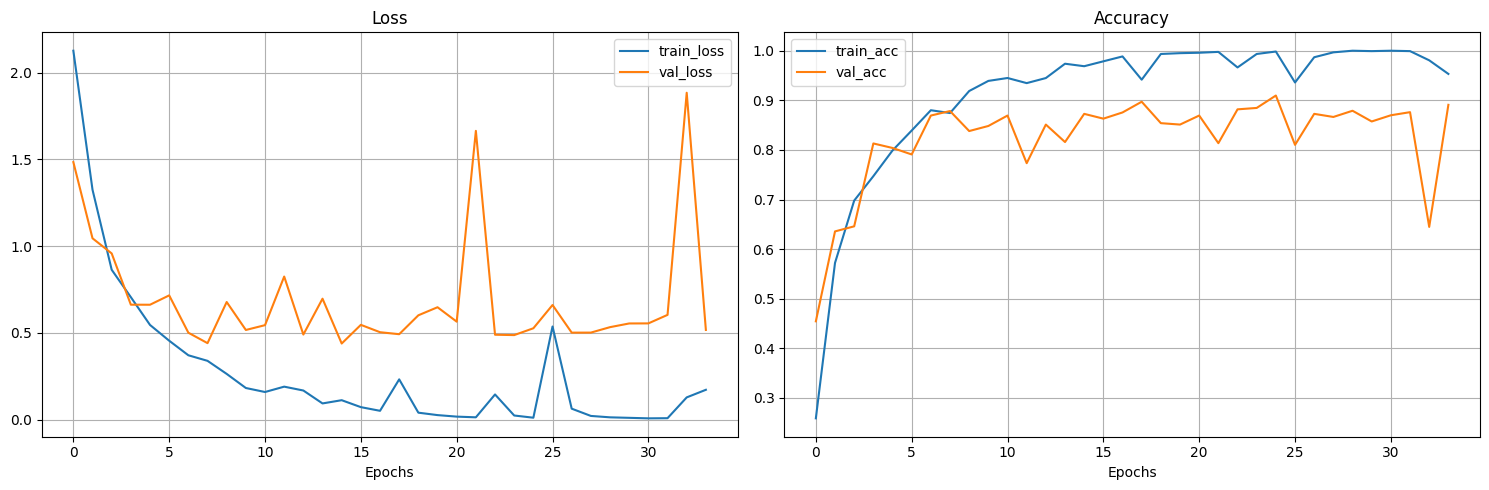

In [ ]:
# plot learning curves for model with best performing weight_decay value
plot_loss_curves(model_1_L2_all_results[best_decay_value])

As observed in the loss curves, the validation loss has come closer to the training loss compared to the baseline model, with a reduced gap and the validation accuracy slightly came closer to the training accuracy. To further reduce this gap, we can introduce dropout layers into the network. Exploring the combination of dropout with L2 (or L1) regularization could be a promising direction for future experiments.

### 2.2. Experimenting with Dropout Layers.

In this section, we will experiment with [dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) layers, a regularization technique designed to address overfitting by randomly "dropping" or setting the output of certain nodes to zero during training. The ```dropout``` hyperparameter specifies the probability of retaining a node's output, with common values being 0.5 to 0.8 for hidden layers and higher values, such as 0.8 for input layers and 0.5 for all the rest ([Hinton's one approach](https://arxiv.org/pdf/1207.0580)). For example, a dropout probability of 0.8 means there is an 80% chance a node's output will be dropped (set to zero) during training. The default value for no dropout is 0.0, meaning all nodes are always kept active. By keeping the best decay value from our L2 regularization experiments, we will explore various dropout configurations to determine if they can further reduce the generalization gap and effectively address overfitting. These dropout probability combinations are the result of thorough experimentation (trying many combinations) and careful observation, ensuring that we focus on the most promising configurations.


In [ ]:
# experiment 2.2: add dropout regularization layers
print("Experiment 2.2: Dropout Regularization Layers")

# set random seeds
set_seeds()

# set dropout probs
dropout_probs = [0.1, 0.3, 0.5, 0.6, 0.7, 0.9]
print("Dropout probabilities to try:", dropout_probs)

# all possible combinations
all_dropout_probs_combinations = list(itertools.product(dropout_probs, repeat=4))
#print("Dropout probabilities combinations to try:", all_dropout_probs_combinations)
print("Total number of combinations to ideally try:", len(all_dropout_probs_combinations))

# set some possible good combinations based on several experiments we did!
all_good_dropout_probs_combinations = [ [0.5, 0.5, 0.5, 0.5],
                                        [0.5, 0.5, 0.4, 0.5],
                                        [0.5, 0.4, 0.5, 0.5],
                                        [0.5, 0.4, 0.4, 0.5],
                                        [0.5, 0.5, 0.5, 0.4],
                                        [0.4, 0.5, 0.5, 0.5],
                                        [0.4, 0.5, 0.5, 0.4],
                                        [0.5, 0.5, 0.5, 0.7],
                                        [0.8, 0.5, 0.5, 0.5],
                                        [0.8, 0.7, 0.7, 0.6],
                                        [0.8, 0.8, 0.7, 0.5],
                                        [0.8, 0.5, 0.7, 0.5],
                                        [0.6, 0.5, 0.5, 0.5],
                                        [0.5, 0.6, 0.6, 0.5],
                                        [0.7, 0.6, 0.5, 0.5] ]
print("\nSome possible 'good' combinations to try:", all_dropout_probs_combinations)

# storage dictionary for all dropout probs
model_2_drop_all_results = {}

# loop over all combinations
start_time = time.time()
for combo in all_good_dropout_probs_combinations:

  # retrieve dropout probs for conv and classifier
  conv_dropout_prob = combo[:3]
  classifier_dropout_prob = combo[3]

  print(f"\nTesting with conv_dropout_prob: {conv_dropout_prob} and classifier dropout probability: {classifier_dropout_prob}")

  # create model instance
  model_2_drop = CNN_v2(dropout_probs=combo).to(device)

  # setup loss function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.RMSprop(params=model_2_drop.parameters(), lr=0.001, weight_decay=best_decay_value) # notice we added L2 with best decay value found abbove

  # start training
  model_2_drop_results = train(model=model_2_drop,
                               train_dataloader=train_dataloader_M,
                               test_dataloader=val_dataloader_M,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=num_epochs)

  # save the results for the current prob
  model_2_drop_all_results[tuple(combo)] = model_2_drop_results

# calculate and print the total experiment's time
end_time = time.time()
print(f"\nTotal experiment's time: {end_time-start_time:.3f} seconds")

# calculate and print model's 2 total trainable params
trainable_params_2 = sum(p.numel() for p in model_2_drop.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_2}")

Experiment 2.2: Dropout Regularization Layers
Dropout probabilities to try: [0.1, 0.3, 0.5, 0.6, 0.7, 0.9]
Total number of combinations to ideally try: 1296

Some possible 'good' combinations to try: [(0.1, 0.1, 0.1, 0.1), (0.1, 0.1, 0.1, 0.3), (0.1, 0.1, 0.1, 0.5), (0.1, 0.1, 0.1, 0.6), (0.1, 0.1, 0.1, 0.7), (0.1, 0.1, 0.1, 0.9), (0.1, 0.1, 0.3, 0.1), (0.1, 0.1, 0.3, 0.3), (0.1, 0.1, 0.3, 0.5), (0.1, 0.1, 0.3, 0.6), (0.1, 0.1, 0.3, 0.7), (0.1, 0.1, 0.3, 0.9), (0.1, 0.1, 0.5, 0.1), (0.1, 0.1, 0.5, 0.3), (0.1, 0.1, 0.5, 0.5), (0.1, 0.1, 0.5, 0.6), (0.1, 0.1, 0.5, 0.7), (0.1, 0.1, 0.5, 0.9), (0.1, 0.1, 0.6, 0.1), (0.1, 0.1, 0.6, 0.3), (0.1, 0.1, 0.6, 0.5), (0.1, 0.1, 0.6, 0.6), (0.1, 0.1, 0.6, 0.7), (0.1, 0.1, 0.6, 0.9), (0.1, 0.1, 0.7, 0.1), (0.1, 0.1, 0.7, 0.3), (0.1, 0.1, 0.7, 0.5), (0.1, 0.1, 0.7, 0.6), (0.1, 0.1, 0.7, 0.7), (0.1, 0.1, 0.7, 0.9), (0.1, 0.1, 0.9, 0.1), (0.1, 0.1, 0.9, 0.3), (0.1, 0.1, 0.9, 0.5), (0.1, 0.1, 0.9, 0.6), (0.1, 0.1, 0.9, 0.7), (0.1, 0.1, 0.9, 0.9), (0.1, 0

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1262 | train_acc: 0.2564 | val_loss: 1.7606 | val_acc: 0.3500
Epoch: 2 | train_loss: 1.7383 | train_acc: 0.4031 | val_loss: 1.4275 | val_acc: 0.5176
Epoch: 3 | train_loss: 1.5964 | train_acc: 0.4607 | val_loss: 1.7139 | val_acc: 0.3227
Epoch: 4 | train_loss: 1.5019 | train_acc: 0.4778 | val_loss: 1.1327 | val_acc: 0.6523
Epoch: 5 | train_loss: 1.3763 | train_acc: 0.5466 | val_loss: 1.2347 | val_acc: 0.5437
Epoch: 6 | train_loss: 1.3162 | train_acc: 0.5716 | val_loss: 1.4347 | val_acc: 0.4977
Epoch: 7 | train_loss: 1.2178 | train_acc: 0.5969 | val_loss: 0.8217 | val_acc: 0.7324
Epoch: 8 | train_loss: 1.1716 | train_acc: 0.6297 | val_loss: 0.8675 | val_acc: 0.7352
Epoch: 9 | train_loss: 1.1263 | train_acc: 0.6313 | val_loss: 0.9378 | val_acc: 0.6523
Epoch: 10 | train_loss: 1.0219 | train_acc: 0.6738 | val_loss: 0.9599 | val_acc: 0.6864
Epoch: 11 | train_loss: 0.9833 | train_acc: 0.6624 | val_loss: 0.9257 | val_acc: 0.6886
Epoch: 12 | train_loss: 0.9960 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1265 | train_acc: 0.2577 | val_loss: 1.7984 | val_acc: 0.3301
Epoch: 2 | train_loss: 1.7204 | train_acc: 0.3892 | val_loss: 1.3655 | val_acc: 0.4960
Epoch: 3 | train_loss: 1.5411 | train_acc: 0.4844 | val_loss: 1.3238 | val_acc: 0.5744
Epoch: 4 | train_loss: 1.4338 | train_acc: 0.5394 | val_loss: 1.1402 | val_acc: 0.6267
Epoch: 5 | train_loss: 1.2893 | train_acc: 0.5878 | val_loss: 1.3303 | val_acc: 0.4903
Epoch: 6 | train_loss: 1.2019 | train_acc: 0.5977 | val_loss: 1.1091 | val_acc: 0.6233
Epoch: 7 | train_loss: 1.1374 | train_acc: 0.6101 | val_loss: 0.8998 | val_acc: 0.6864
Epoch: 8 | train_loss: 1.0970 | train_acc: 0.6300 | val_loss: 1.2126 | val_acc: 0.5335
Epoch: 9 | train_loss: 1.0141 | train_acc: 0.6565 | val_loss: 0.8841 | val_acc: 0.6523
Epoch: 10 | train_loss: 0.9911 | train_acc: 0.6589 | val_loss: 0.7717 | val_acc: 0.7381
Epoch: 11 | train_loss: 0.9828 | train_acc: 0.6783 | val_loss: 1.0568 | val_acc: 0.6057
Epoch: 12 | train_loss: 0.8973 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1479 | train_acc: 0.2619 | val_loss: 1.6324 | val_acc: 0.4489
Epoch: 2 | train_loss: 1.7252 | train_acc: 0.4006 | val_loss: 1.3547 | val_acc: 0.5188
Epoch: 3 | train_loss: 1.5514 | train_acc: 0.4875 | val_loss: 1.4458 | val_acc: 0.4494
Epoch: 4 | train_loss: 1.4526 | train_acc: 0.5211 | val_loss: 1.8044 | val_acc: 0.3744
Epoch: 5 | train_loss: 1.3808 | train_acc: 0.5559 | val_loss: 1.9459 | val_acc: 0.2551
Epoch: 6 | train_loss: 1.2955 | train_acc: 0.5719 | val_loss: 1.2108 | val_acc: 0.5858
Epoch: 7 | train_loss: 1.1574 | train_acc: 0.6258 | val_loss: 1.0814 | val_acc: 0.6398
Epoch: 8 | train_loss: 1.0843 | train_acc: 0.6290 | val_loss: 0.9142 | val_acc: 0.6858
Epoch: 9 | train_loss: 1.0214 | train_acc: 0.6617 | val_loss: 0.8330 | val_acc: 0.6983
Epoch: 10 | train_loss: 0.9589 | train_acc: 0.6619 | val_loss: 1.0276 | val_acc: 0.6386
Epoch: 11 | train_loss: 0.9504 | train_acc: 0.6801 | val_loss: 0.7223 | val_acc: 0.7074
Epoch: 12 | train_loss: 0.9052 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2509 | train_acc: 0.2067 | val_loss: 1.7674 | val_acc: 0.3449
Epoch: 2 | train_loss: 1.7372 | train_acc: 0.4064 | val_loss: 1.7307 | val_acc: 0.3347
Epoch: 3 | train_loss: 1.5826 | train_acc: 0.4546 | val_loss: 1.3304 | val_acc: 0.5176
Epoch: 4 | train_loss: 1.4387 | train_acc: 0.5227 | val_loss: 1.1762 | val_acc: 0.5801
Epoch: 5 | train_loss: 1.3730 | train_acc: 0.5527 | val_loss: 1.7223 | val_acc: 0.3688
Epoch: 6 | train_loss: 1.2466 | train_acc: 0.5797 | val_loss: 1.1701 | val_acc: 0.5710
Epoch: 7 | train_loss: 1.1453 | train_acc: 0.6172 | val_loss: 1.1577 | val_acc: 0.5750
Epoch: 8 | train_loss: 1.0770 | train_acc: 0.6486 | val_loss: 1.1289 | val_acc: 0.5875
Epoch: 9 | train_loss: 0.9936 | train_acc: 0.6764 | val_loss: 0.9173 | val_acc: 0.6545
Epoch: 10 | train_loss: 0.9338 | train_acc: 0.6838 | val_loss: 0.6269 | val_acc: 0.8131
Epoch: 11 | train_loss: 0.9148 | train_acc: 0.6799 | val_loss: 0.7218 | val_acc: 0.7886
Epoch: 12 | train_loss: 0.8545 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1856 | train_acc: 0.2199 | val_loss: 1.7666 | val_acc: 0.3773
Epoch: 2 | train_loss: 1.7231 | train_acc: 0.3941 | val_loss: 1.6521 | val_acc: 0.3688
Epoch: 3 | train_loss: 1.5724 | train_acc: 0.4433 | val_loss: 1.4962 | val_acc: 0.4284
Epoch: 4 | train_loss: 1.3612 | train_acc: 0.5338 | val_loss: 1.0851 | val_acc: 0.6233
Epoch: 5 | train_loss: 1.2843 | train_acc: 0.5665 | val_loss: 1.6638 | val_acc: 0.3608
Epoch: 6 | train_loss: 1.1412 | train_acc: 0.6159 | val_loss: 0.9991 | val_acc: 0.6307
Epoch: 7 | train_loss: 1.1205 | train_acc: 0.6113 | val_loss: 1.1540 | val_acc: 0.5347
Epoch: 8 | train_loss: 1.0211 | train_acc: 0.6546 | val_loss: 1.2821 | val_acc: 0.5341
Epoch: 9 | train_loss: 0.9770 | train_acc: 0.6730 | val_loss: 0.9988 | val_acc: 0.6403
Epoch: 10 | train_loss: 0.9107 | train_acc: 0.7002 | val_loss: 0.7187 | val_acc: 0.7057
Epoch: 11 | train_loss: 0.8953 | train_acc: 0.7003 | val_loss: 0.7065 | val_acc: 0.7756
Epoch: 12 | train_loss: 0.8359 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1955 | train_acc: 0.2068 | val_loss: 2.0041 | val_acc: 0.1926
Epoch: 2 | train_loss: 1.7796 | train_acc: 0.3579 | val_loss: 1.4237 | val_acc: 0.4614
Epoch: 3 | train_loss: 1.6067 | train_acc: 0.4366 | val_loss: 1.2764 | val_acc: 0.5767
Epoch: 4 | train_loss: 1.4705 | train_acc: 0.4928 | val_loss: 1.1045 | val_acc: 0.6500
Epoch: 5 | train_loss: 1.3350 | train_acc: 0.5420 | val_loss: 1.0564 | val_acc: 0.6523
Epoch: 6 | train_loss: 1.2767 | train_acc: 0.5788 | val_loss: 0.9906 | val_acc: 0.7102
Epoch: 7 | train_loss: 1.1707 | train_acc: 0.6116 | val_loss: 0.8716 | val_acc: 0.7045
Epoch: 8 | train_loss: 1.0746 | train_acc: 0.6206 | val_loss: 0.8896 | val_acc: 0.6767
Epoch: 9 | train_loss: 1.0093 | train_acc: 0.6763 | val_loss: 0.8944 | val_acc: 0.6636
Epoch: 10 | train_loss: 0.9933 | train_acc: 0.6820 | val_loss: 0.9466 | val_acc: 0.6705
Epoch: 11 | train_loss: 0.8771 | train_acc: 0.7051 | val_loss: 0.6206 | val_acc: 0.8165
Epoch: 12 | train_loss: 0.8480 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2102 | train_acc: 0.2156 | val_loss: 1.7414 | val_acc: 0.3335
Epoch: 2 | train_loss: 1.7710 | train_acc: 0.3727 | val_loss: 1.4051 | val_acc: 0.4341
Epoch: 3 | train_loss: 1.6050 | train_acc: 0.4409 | val_loss: 1.5190 | val_acc: 0.4375
Epoch: 4 | train_loss: 1.4920 | train_acc: 0.4901 | val_loss: 1.3594 | val_acc: 0.5080
Epoch: 5 | train_loss: 1.3980 | train_acc: 0.5222 | val_loss: 1.0695 | val_acc: 0.6648
Epoch: 6 | train_loss: 1.2728 | train_acc: 0.5828 | val_loss: 0.9651 | val_acc: 0.6267
Epoch: 7 | train_loss: 1.2043 | train_acc: 0.6093 | val_loss: 0.8619 | val_acc: 0.7597
Epoch: 8 | train_loss: 1.1145 | train_acc: 0.6243 | val_loss: 0.9433 | val_acc: 0.6795
Epoch: 9 | train_loss: 1.0857 | train_acc: 0.6463 | val_loss: 1.0096 | val_acc: 0.6398
Epoch: 10 | train_loss: 1.0056 | train_acc: 0.6552 | val_loss: 0.8107 | val_acc: 0.7233
Epoch: 11 | train_loss: 0.9571 | train_acc: 0.6742 | val_loss: 0.6341 | val_acc: 0.7915
Epoch: 12 | train_loss: 0.9289 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1906 | train_acc: 0.2258 | val_loss: 1.7073 | val_acc: 0.3426
Epoch: 2 | train_loss: 1.8749 | train_acc: 0.3135 | val_loss: 1.6226 | val_acc: 0.4239
Epoch: 3 | train_loss: 1.7500 | train_acc: 0.3796 | val_loss: 1.4416 | val_acc: 0.4614
Epoch: 4 | train_loss: 1.6243 | train_acc: 0.4368 | val_loss: 1.8927 | val_acc: 0.2415
Epoch: 5 | train_loss: 1.6018 | train_acc: 0.4599 | val_loss: 1.4169 | val_acc: 0.5273
Epoch: 6 | train_loss: 1.4707 | train_acc: 0.5183 | val_loss: 1.2659 | val_acc: 0.5966
Epoch: 7 | train_loss: 1.4110 | train_acc: 0.5374 | val_loss: 1.2389 | val_acc: 0.5460
Epoch: 8 | train_loss: 1.3901 | train_acc: 0.5464 | val_loss: 1.3245 | val_acc: 0.5119
Epoch: 9 | train_loss: 1.2873 | train_acc: 0.5658 | val_loss: 1.1367 | val_acc: 0.6182
Epoch: 10 | train_loss: 1.2041 | train_acc: 0.6073 | val_loss: 1.4015 | val_acc: 0.4534
Epoch: 11 | train_loss: 1.2527 | train_acc: 0.5831 | val_loss: 1.0931 | val_acc: 0.6403
Epoch: 12 | train_loss: 1.1539 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2848 | train_acc: 0.2205 | val_loss: 2.4107 | val_acc: 0.1437
Epoch: 2 | train_loss: 1.9152 | train_acc: 0.3383 | val_loss: 2.6514 | val_acc: 0.1062
Epoch: 3 | train_loss: 1.7635 | train_acc: 0.4088 | val_loss: 2.3852 | val_acc: 0.1608
Epoch: 4 | train_loss: 1.6756 | train_acc: 0.4287 | val_loss: 2.5261 | val_acc: 0.1062
Epoch: 5 | train_loss: 1.6266 | train_acc: 0.4363 | val_loss: 3.6130 | val_acc: 0.1062
Epoch: 6 | train_loss: 1.5846 | train_acc: 0.4731 | val_loss: 2.9077 | val_acc: 0.1062
Epoch: 7 | train_loss: 1.5354 | train_acc: 0.4858 | val_loss: 2.4623 | val_acc: 0.1187
Epoch: 8 | train_loss: 1.4967 | train_acc: 0.4961 | val_loss: 2.8319 | val_acc: 0.1062
Epoch: 9 | train_loss: 1.4409 | train_acc: 0.5144 | val_loss: 3.0446 | val_acc: 0.1062
Epoch: 10 | train_loss: 1.4316 | train_acc: 0.5263 | val_loss: 3.6827 | val_acc: 0.1062
Epoch: 11 | train_loss: 1.3645 | train_acc: 0.5441 | val_loss: 3.0046 | val_acc: 0.1369
Epoch: 12 | train_loss: 1.3714 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3043 | train_acc: 0.1959 | val_loss: 2.3492 | val_acc: 0.1062
Epoch: 2 | train_loss: 2.0952 | train_acc: 0.2627 | val_loss: 2.4634 | val_acc: 0.1062
Epoch: 3 | train_loss: 1.9643 | train_acc: 0.3063 | val_loss: 2.6075 | val_acc: 0.1062
Epoch: 4 | train_loss: 1.8970 | train_acc: 0.3379 | val_loss: 2.7333 | val_acc: 0.1062
Epoch: 5 | train_loss: 1.8467 | train_acc: 0.3495 | val_loss: 2.7071 | val_acc: 0.1062
Epoch: 6 | train_loss: 1.7800 | train_acc: 0.3994 | val_loss: 2.9105 | val_acc: 0.1062
Epoch: 7 | train_loss: 1.7263 | train_acc: 0.4082 | val_loss: 2.9502 | val_acc: 0.1062
Epoch: 8 | train_loss: 1.7316 | train_acc: 0.4057 | val_loss: 2.8576 | val_acc: 0.1062
Epoch: 9 | train_loss: 1.6959 | train_acc: 0.4198 | val_loss: 3.1104 | val_acc: 0.1062
Epoch: 10 | train_loss: 1.6682 | train_acc: 0.4522 | val_loss: 2.7427 | val_acc: 0.1062
Epoch: 11 | train_loss: 1.6343 | train_acc: 0.4325 | val_loss: 2.7959 | val_acc: 0.1062
Epoch: 12 | train_loss: 1.6600 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3835 | train_acc: 0.1683 | val_loss: 2.3538 | val_acc: 0.1062
Epoch: 2 | train_loss: 2.1529 | train_acc: 0.2554 | val_loss: 2.3971 | val_acc: 0.1062
Epoch: 3 | train_loss: 2.0322 | train_acc: 0.2978 | val_loss: 2.4927 | val_acc: 0.1062
Epoch: 4 | train_loss: 1.8854 | train_acc: 0.3572 | val_loss: 2.5757 | val_acc: 0.1062
Epoch: 5 | train_loss: 1.7918 | train_acc: 0.3868 | val_loss: 2.6412 | val_acc: 0.1062
Epoch: 6 | train_loss: 1.7340 | train_acc: 0.4105 | val_loss: 2.6362 | val_acc: 0.1062
Epoch: 7 | train_loss: 1.7490 | train_acc: 0.4102 | val_loss: 2.7236 | val_acc: 0.1062
Epoch: 8 | train_loss: 1.7274 | train_acc: 0.4229 | val_loss: 2.5688 | val_acc: 0.1062
Epoch: 9 | train_loss: 1.7010 | train_acc: 0.4214 | val_loss: 2.8531 | val_acc: 0.1062
Epoch: 10 | train_loss: 1.6506 | train_acc: 0.4197 | val_loss: 2.6849 | val_acc: 0.1062
Epoch: 11 | train_loss: 1.6242 | train_acc: 0.4482 | val_loss: 2.5858 | val_acc: 0.1062
Epoch: 12 | train_loss: 1.6064 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3089 | train_acc: 0.1952 | val_loss: 2.1809 | val_acc: 0.2551
Epoch: 2 | train_loss: 1.9980 | train_acc: 0.3188 | val_loss: 2.5725 | val_acc: 0.1062
Epoch: 3 | train_loss: 1.8950 | train_acc: 0.3334 | val_loss: 2.7042 | val_acc: 0.1062
Epoch: 4 | train_loss: 1.8083 | train_acc: 0.3876 | val_loss: 2.7234 | val_acc: 0.1062
Epoch: 5 | train_loss: 1.7526 | train_acc: 0.4163 | val_loss: 2.9114 | val_acc: 0.1062
Epoch: 6 | train_loss: 1.6896 | train_acc: 0.4524 | val_loss: 2.9573 | val_acc: 0.1062
Epoch: 7 | train_loss: 1.6598 | train_acc: 0.4472 | val_loss: 3.0288 | val_acc: 0.1062
Epoch: 8 | train_loss: 1.6398 | train_acc: 0.4811 | val_loss: 2.9785 | val_acc: 0.1062
Epoch: 9 | train_loss: 1.6195 | train_acc: 0.4622 | val_loss: 3.1463 | val_acc: 0.1062
Epoch: 10 | train_loss: 1.5769 | train_acc: 0.4592 | val_loss: 3.0870 | val_acc: 0.1062
Epoch: 11 | train_loss: 1.5487 | train_acc: 0.4785 | val_loss: 2.9266 | val_acc: 0.1125
Epoch: 12 | train_loss: 1.5727 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1939 | train_acc: 0.2313 | val_loss: 1.9728 | val_acc: 0.2676
Epoch: 2 | train_loss: 1.8278 | train_acc: 0.3565 | val_loss: 2.0776 | val_acc: 0.2267
Epoch: 3 | train_loss: 1.6445 | train_acc: 0.4324 | val_loss: 2.0002 | val_acc: 0.2631
Epoch: 4 | train_loss: 1.5806 | train_acc: 0.4657 | val_loss: 2.4735 | val_acc: 0.1642
Epoch: 5 | train_loss: 1.5250 | train_acc: 0.4836 | val_loss: 1.3699 | val_acc: 0.4750
Epoch: 6 | train_loss: 1.4269 | train_acc: 0.5245 | val_loss: 1.6553 | val_acc: 0.3688
Epoch: 7 | train_loss: 1.3619 | train_acc: 0.5464 | val_loss: 1.6020 | val_acc: 0.4341
Epoch: 8 | train_loss: 1.3219 | train_acc: 0.5672 | val_loss: 1.6185 | val_acc: 0.3994
Epoch: 9 | train_loss: 1.3151 | train_acc: 0.5640 | val_loss: 1.9022 | val_acc: 0.2676
Epoch: 10 | train_loss: 1.2312 | train_acc: 0.5971 | val_loss: 1.9527 | val_acc: 0.2784
Epoch: 11 | train_loss: 1.2017 | train_acc: 0.5948 | val_loss: 1.5503 | val_acc: 0.4460
Epoch: 12 | train_loss: 1.1351 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2685 | train_acc: 0.2107 | val_loss: 1.9746 | val_acc: 0.2125
Epoch: 2 | train_loss: 1.8444 | train_acc: 0.3571 | val_loss: 1.7283 | val_acc: 0.3784
Epoch: 3 | train_loss: 1.6523 | train_acc: 0.4410 | val_loss: 1.8719 | val_acc: 0.2761
Epoch: 4 | train_loss: 1.5311 | train_acc: 0.4943 | val_loss: 1.7187 | val_acc: 0.3051
Epoch: 5 | train_loss: 1.4093 | train_acc: 0.5164 | val_loss: 1.2852 | val_acc: 0.5443
Epoch: 6 | train_loss: 1.3250 | train_acc: 0.5641 | val_loss: 1.2043 | val_acc: 0.5744
Epoch: 7 | train_loss: 1.2555 | train_acc: 0.5903 | val_loss: 1.1124 | val_acc: 0.6341
Epoch: 8 | train_loss: 1.1904 | train_acc: 0.5806 | val_loss: 1.1016 | val_acc: 0.5778
Epoch: 9 | train_loss: 1.1522 | train_acc: 0.6019 | val_loss: 1.1073 | val_acc: 0.6307
Epoch: 10 | train_loss: 1.0586 | train_acc: 0.6405 | val_loss: 0.8038 | val_acc: 0.7426
Epoch: 11 | train_loss: 1.0709 | train_acc: 0.6437 | val_loss: 1.0044 | val_acc: 0.6364
Epoch: 12 | train_loss: 0.9817 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2153 | train_acc: 0.2282 | val_loss: 1.8633 | val_acc: 0.2801
Epoch: 2 | train_loss: 1.8701 | train_acc: 0.3356 | val_loss: 1.9235 | val_acc: 0.2261
Epoch: 3 | train_loss: 1.6983 | train_acc: 0.4118 | val_loss: 2.0465 | val_acc: 0.2301
Epoch: 4 | train_loss: 1.6237 | train_acc: 0.4568 | val_loss: 1.7900 | val_acc: 0.3028
Epoch: 5 | train_loss: 1.5342 | train_acc: 0.4950 | val_loss: 2.0211 | val_acc: 0.2261
Epoch: 6 | train_loss: 1.4550 | train_acc: 0.5228 | val_loss: 1.8602 | val_acc: 0.3006
Epoch: 7 | train_loss: 1.4077 | train_acc: 0.5240 | val_loss: 2.1228 | val_acc: 0.2330
Epoch: 8 | train_loss: 1.3567 | train_acc: 0.5420 | val_loss: 1.8048 | val_acc: 0.3108
Epoch: 9 | train_loss: 1.3166 | train_acc: 0.5795 | val_loss: 1.7188 | val_acc: 0.3443
Epoch: 10 | train_loss: 1.3212 | train_acc: 0.5800 | val_loss: 2.0763 | val_acc: 0.2420
Epoch: 11 | train_loss: 1.2578 | train_acc: 0.5939 | val_loss: 1.8829 | val_acc: 0.2807
Epoch: 12 | train_loss: 1.2448 | train_ac

We observe dramatic changes with validation accuracy surpassing training accuracy in many dropout probability combinations, along with losses being very close, which are clear signs that overfitting has diminished. Let's print all the results into a table for a clearer comparison.

In [ ]:
# compute the generalization gap (train acc - val acc) for each case of experiment 2
differences_2 = []
print("\nGeneralization gaps for all combinations:")
for prob, results in model_2_drop_all_results.items():
  diff_2 = results["train_acc"][-1] - results["val_acc"][-1]
  differences_2.append((prob, diff_2, results["val_acc"][-1]))
  #print(f"{prob}: {diff_2:.4f} | {results['val_acc'][-1]:.4f}")

# put all the results in a table and print it by desc order by generalization gap
model_2_drop_df = pd.DataFrame(differences_2, columns=['Dropout Probabilities', 'Generalization Gap', 'Validation Accuracy'])
model_2_drop_df = model_2_drop_df.sort_values(by='Generalization Gap', ascending=True)
print(model_2_drop_df.to_string(index=False))


Generalization gaps for all combinations:
Dropout Probabilities  Generalization Gap  Validation Accuracy
 (0.5, 0.5, 0.5, 0.7)           -0.053442             0.813068
 (0.4, 0.5, 0.5, 0.5)           -0.028006             0.850568
 (0.5, 0.5, 0.5, 0.5)           -0.027939             0.838068
 (0.4, 0.5, 0.5, 0.4)           -0.005241             0.831818
 (0.5, 0.4, 0.5, 0.5)           -0.003687             0.847727
 (0.5, 0.5, 0.4, 0.5)            0.002392             0.838068
 (0.5, 0.6, 0.6, 0.5)            0.019720             0.769318
 (0.5, 0.5, 0.5, 0.4)            0.033722             0.794886
 (0.6, 0.5, 0.5, 0.5)            0.086743             0.674432
 (0.5, 0.4, 0.4, 0.5)            0.116446             0.739205
 (0.7, 0.6, 0.5, 0.5)            0.232445             0.482386
 (0.8, 0.5, 0.7, 0.5)            0.247343             0.415341
 (0.8, 0.8, 0.7, 0.5)            0.365329             0.165341
 (0.8, 0.7, 0.7, 0.6)            0.379041             0.161932
 (0.8, 0.5, 

In [ ]:
# print the best combo by generalization gap
best_combo = model_2_drop_df.iloc[1]['Dropout Probabilities'] # after sorting it is in first position
print(f"\nThe best combination is: {best_combo} with generalization gap {model_2_drop_df.iloc[1]['Generalization Gap']:.4f} and validation accuracy {model_2_drop_df.iloc[1]['Validation Accuracy']:.4f}")


The best combination is: (0.4, 0.5, 0.5, 0.5) with generalization gap -0.0280 and validation accuracy 0.8506


The results show that negative generalization gap values indicate no overfitting. We started with a baseline model generalization gap of 0.1114, reduced it to 0.0623 using L2 regularization, and now, with the addition of dropout layers, we have achieved a further reduction to -0.021382, along with a high validation accuracy of 0.841477. We select the combination (0.4, 0.5, 0.5, 0.5) as the best-performing setup and will proceed to refine it further for even better results.

In [ ]:
# set the best dropout probability
best_dropout_probs_combo = [0.4, 0.5, 0.5, 0.5]

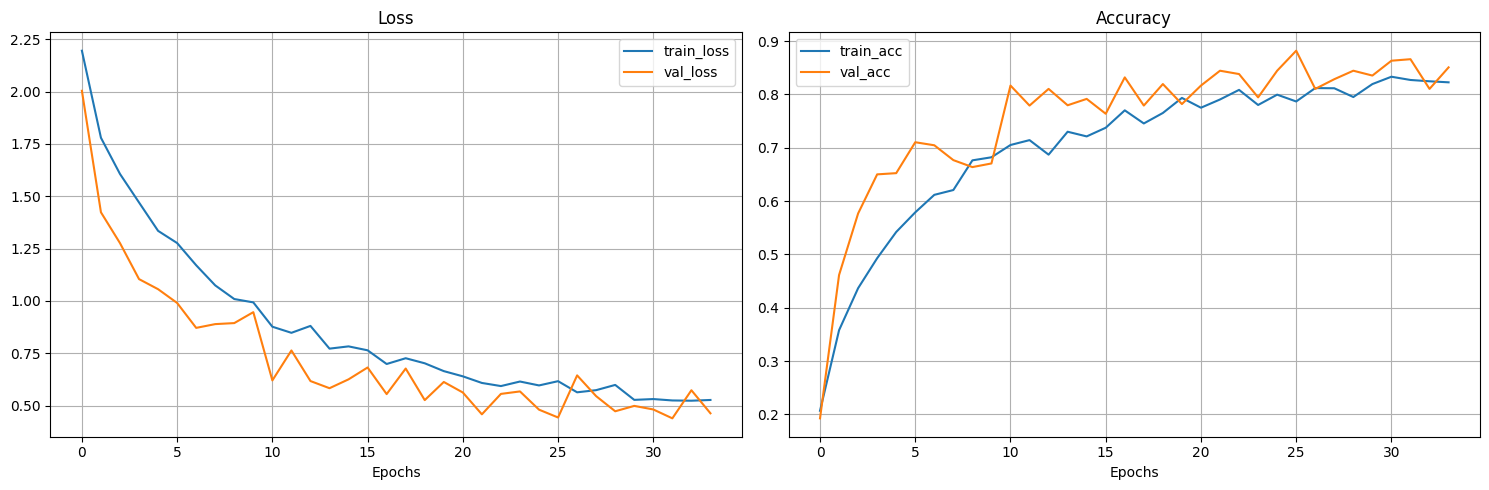

In [ ]:
# plot learning curves for model 2 and best performing dropout_prob
plot_loss_curves(model_2_drop_all_results[tuple(best_dropout_probs_combo)])

As expected, the lines of the learning curves are now significantly closer, indicating that overfitting has been effectively addressed. Let's take it a step further and work on optimizing it even more.

### 2.3. Experimenting with Adding/Removing Layers.


In this experiment, we will explore the impact of adding and removing layers in the model architecture. Layers are typically added when the model lacks the capacity to learn complex patterns in the data, which can lead to underfitting. On the other hand, layers are removed when the model is more complex, which can lead to overfitting or inefficient training. Since we have already addressed overfitting in our previous experiments, we will now test both adding and removing layers to determine if we can further optimize the model's performance  and improve its ability to generalize.

The first experiment is about [pooling layers](https://medium.com/@benjybo7/7-pytorch-pool-methods-you-should-be-using-495eb00325d6) and specifically involves replacing ```MaxPool2d``` with ```AvgPool2d```. Unlike MaxPool2d, which selects the maximum value from each pooling region, AvgPool2d computes the average value, providing a smoother representation of the feature map. This change may influence how the model captures local features and could improve performance in certain cases.

In [ ]:
# experiment 2.3.1: apply AvgPool2d instead of MaxPool2d (plus optional global average pooling in classifier)
print("Experiment 2.3.1: AveragePooling instead of MaxPooling layers")

# model function with AveragePooling layers instead of MaxPooling
def cnn_with_avg_pooling(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units, dropout_probs=best_dropout_probs_combo, activation_functions=init_activation_functions):
  """ CNN model with AveragePooling instead of MaxPooling layers. """

  # feature extractor
  feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[0]),

      nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[1], kernel_size=3, padding='same'),
      activation_functions[0],
      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[1], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[1]),

      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[2])
      )

  # calculate the feature extractor's output shape
  dummy_input = torch.randn(1, in_features, 25, 149)
  with torch.no_grad():
    output = feature_extractor(dummy_input)
  classifier_input_size = output.shape[1] * output.shape[2] * output.shape[3]

  # classifier
  classifier = nn.Sequential(
      #nn.AdaptiveAvgPool2d(output_size=(1, 1)), # if uncomment, set classifier_input_size = output.shape[1]
      nn.Flatten(),
      nn.Linear(in_features=classifier_input_size, out_features=128),
      activation_functions[1],
      nn.Dropout(p=dropout_probs[3]),
      nn.Linear(in_features=128, out_features=out_features)
      )

  return nn.Sequential(feature_extractor, classifier) # model = feature extractor + classifier

# create a model
model_31 = cnn_with_avg_pooling().to(device)

# set loss funcction and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_31.parameters(), lr=0.001, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_31_results = train(model=model_31,
                         train_dataloader=train_dataloader_M,
                         test_dataloader=val_dataloader_M,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=num_epochs)

# calculate and print total training time
end_time = time.time()
print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

# print total trainable params of model 31
trainable_params_31 = sum(p.numel() for p in model_31.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_31}")

Experiment 2.3.1: AveragePooling instead of MaxPooling layers


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1714 | train_acc: 0.2421 | val_loss: 1.5978 | val_acc: 0.4364
Epoch: 2 | train_loss: 1.6710 | train_acc: 0.4324 | val_loss: 1.2326 | val_acc: 0.5926
Epoch: 3 | train_loss: 1.4314 | train_acc: 0.5147 | val_loss: 1.2662 | val_acc: 0.5676
Epoch: 4 | train_loss: 1.2813 | train_acc: 0.5625 | val_loss: 0.9905 | val_acc: 0.6364
Epoch: 5 | train_loss: 1.1743 | train_acc: 0.5985 | val_loss: 0.9700 | val_acc: 0.6545
Epoch: 6 | train_loss: 1.1015 | train_acc: 0.6274 | val_loss: 0.9440 | val_acc: 0.6830
Epoch: 7 | train_loss: 1.0426 | train_acc: 0.6445 | val_loss: 0.8460 | val_acc: 0.7142
Epoch: 8 | train_loss: 0.9505 | train_acc: 0.6821 | val_loss: 0.8243 | val_acc: 0.7148
Epoch: 9 | train_loss: 0.9104 | train_acc: 0.6887 | val_loss: 0.7195 | val_acc: 0.7205
Epoch: 10 | train_loss: 0.8974 | train_acc: 0.6945 | val_loss: 0.8642 | val_acc: 0.6642
Epoch: 11 | train_loss: 0.8440 | train_acc: 0.7112 | val_loss: 0.7295 | val_acc: 0.7386
Epoch: 12 | train_loss: 0.8312 | train_ac

We observe that the validation accuracy achieved with AvgPool2d is lower to that of MaxPool2d, showing no improvement in performance. Therefore, we will retain MaxPool2d as the preferred pooling method.

The second experiment involves adding ```BatchNorm2d``` ([Batch Normalization layers](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)) after ```Conv2d``` layers. This is done to normalize the outputs of the convolutional layers, ensuring consistent scaling and distribution of activations. It helps stabilize training, speeds up learning, and can improve the model's overall performance.

In [ ]:
# experiment 2.3.2: add BatcNorm layers
print("Experiment 2.3.2: BatchNorm layers")

# model function with BatchNorm layers
def cnn_with_batch_norm(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units, dropout_probs=best_dropout_probs_combo, activation_functions=init_activation_functions):
  """ CNN model with BatchNorm layers. """

  # feature extractor
  feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
      nn.BatchNorm2d(hidden_units[0]),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[0]),

      nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[1], kernel_size=3, padding='same'),
      nn.BatchNorm2d(hidden_units[1]),
      activation_functions[0],
      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[1], kernel_size=3, padding='valid'),
      nn.BatchNorm2d(hidden_units[1]),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[1]),

      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
      nn.BatchNorm2d(hidden_units[2]),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[2])
      )

  # calculate the feature extractor's output shape
  dummy_input = torch.randn(1, in_features, 25, 149)
  with torch.no_grad():
    output = feature_extractor(dummy_input)
  classifier_input_size = output.shape[1] * output.shape[2] * output.shape[3]

  # classifier
  classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=classifier_input_size, out_features=128),
      activation_functions[1],
      nn.Dropout(p=dropout_probs[3]),
      nn.Linear(in_features=128, out_features=out_features)
      )

  return nn.Sequential(feature_extractor, classifier) # model = feature extractor + classifier

# create the model
model_32 = cnn_with_batch_norm().to(device)

# set loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_32.parameters(), lr=0.001, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_32_results = train(model=model_32,
                         train_dataloader=train_dataloader_M,
                         test_dataloader=val_dataloader_M,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=num_epochs)

# calculate and print total training time
end_time = time.time()
print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

# print total trainable params of model 32
trainable_params_32 = sum(p.numel() for p in model_32.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_32}")

Experiment 2.3.2: BatchNorm layers


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2963 | train_acc: 0.2768 | val_loss: 1.6154 | val_acc: 0.3767
Epoch: 2 | train_loss: 1.7240 | train_acc: 0.3875 | val_loss: 1.2068 | val_acc: 0.6170
Epoch: 3 | train_loss: 1.5174 | train_acc: 0.4828 | val_loss: 1.0134 | val_acc: 0.6608
Epoch: 4 | train_loss: 1.3422 | train_acc: 0.5587 | val_loss: 1.0094 | val_acc: 0.6744
Epoch: 5 | train_loss: 1.2115 | train_acc: 0.6083 | val_loss: 0.9008 | val_acc: 0.6710
Epoch: 6 | train_loss: 1.1263 | train_acc: 0.6258 | val_loss: 0.8814 | val_acc: 0.6926
Epoch: 7 | train_loss: 1.0810 | train_acc: 0.6217 | val_loss: 0.8161 | val_acc: 0.7045
Epoch: 8 | train_loss: 1.0023 | train_acc: 0.6617 | val_loss: 0.7690 | val_acc: 0.7324
Epoch: 9 | train_loss: 1.0084 | train_acc: 0.6488 | val_loss: 0.7608 | val_acc: 0.7483
Epoch: 10 | train_loss: 0.9301 | train_acc: 0.6766 | val_loss: 0.8519 | val_acc: 0.6710
Epoch: 11 | train_loss: 0.9705 | train_acc: 0.6715 | val_loss: 0.7265 | val_acc: 0.7267
Epoch: 12 | train_loss: 0.9095 | train_ac

In this case, adding ```BatchNorm2d``` layers results in similar validation accuracy without any significant improvement. Therefore, we will continue using the ```CNN_v2``` model for the next experiment. It's worth noting (and expected) that adding BatchNorm layers increases the number of trainable parameters in the model.

Experiment 3 involves adding an extra block to the feature extractor of the CNN, same as block 3. This aims to increase the model's capacity to capture more complex patterns and improve feature learning.

In [ ]:
# experiment 2.3.3: add an extra block in feature extractor
print("Experiment 2.3.3: Extra block in feature extractor")

# model function with extra block
def cnn_with_extra_block(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units, dropout_probs=best_dropout_probs_combo, activation_functions=init_activation_functions):
  """ CNN model with extra block in feature extractor. """

  # feature extractor
  feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[0]),

      nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[1], kernel_size=3, padding='same'),
      activation_functions[0],
      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[1], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[1]),

      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[2]),

      # extra block
      nn.Conv2d(in_channels=hidden_units[2], out_channels=hidden_units[3], kernel_size=3, padding='same'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=1, stride=1),
      nn.Dropout2d(p=dropout_probs[2])
  )

  # calculate the feature extractor's output shape
  dummy_input = torch.randn(1, in_features, 25, 149)
  with torch.no_grad():
    output = feature_extractor(dummy_input)
  classifier_input_size = output.shape[1] * output.shape[2] * output.shape[3]

  # classifier
  classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=classifier_input_size, out_features=128),
      activation_functions[1],
      nn.Dropout(p=dropout_probs[3]),
      nn.Linear(in_features=128, out_features=out_features)
      )
  return nn.Sequential(feature_extractor, classifier) # model = feature extractor + classifier

# create the model
model_33 = cnn_with_extra_block(hidden_units=[16, 32, 64, 128]).to(device)

# set loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_33.parameters(), lr=0.001, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_33_results = train(model=model_33,
                         train_dataloader=train_dataloader_M,
                         test_dataloader=val_dataloader_M,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=num_epochs)

# calculate and print total training time
end_time = time.time()
print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

# print total trainable params of model 33
trainable_params_33 = sum(p.numel() for p in model_33.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_33}")

Experiment 2.3.3: Extra block in feataure extractor


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2214 | train_acc: 0.2249 | val_loss: 1.9248 | val_acc: 0.3364
Epoch: 2 | train_loss: 1.7966 | train_acc: 0.3410 | val_loss: 1.7376 | val_acc: 0.3898
Epoch: 3 | train_loss: 1.6546 | train_acc: 0.4293 | val_loss: 1.4219 | val_acc: 0.5205
Epoch: 4 | train_loss: 1.5408 | train_acc: 0.4907 | val_loss: 1.3765 | val_acc: 0.5392
Epoch: 5 | train_loss: 1.4323 | train_acc: 0.5345 | val_loss: 1.2485 | val_acc: 0.5705
Epoch: 6 | train_loss: 1.3478 | train_acc: 0.5649 | val_loss: 1.4534 | val_acc: 0.5392
Epoch: 7 | train_loss: 1.2999 | train_acc: 0.5657 | val_loss: 1.1337 | val_acc: 0.6080
Epoch: 8 | train_loss: 1.2898 | train_acc: 0.5864 | val_loss: 1.3038 | val_acc: 0.5364
Epoch: 9 | train_loss: 1.2364 | train_acc: 0.5926 | val_loss: 1.0810 | val_acc: 0.6358
Epoch: 10 | train_loss: 1.1642 | train_acc: 0.5997 | val_loss: 1.0236 | val_acc: 0.6330
Epoch: 11 | train_loss: 1.0915 | train_acc: 0.6342 | val_loss: 1.3163 | val_acc: 0.5392
Epoch: 12 | train_loss: 1.0787 | train_ac

Adding an ```extra block``` to the feature extractor did not improve performance, as the validation accuracy dropped below the initial ~84%. This suggests that the additional complexity did not benefit generalization. What is noticeable here is that the number of trainable parameters doubled (also reasonable), making the model more computationally expensive without a gain in accuracy.

Experiment 4 involves adding an extra linear layer, activation function, and dropout in the classifier to see if we get a any better impact on performance.

In [ ]:
# experiment 2.3.4: add extra layers in classifier
print("Experiment 2.3.4: Extra layers in classifier")

def cnn_with_enhanced_classifier(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units, dropout_probs=best_dropout_probs_combo, activation_functions=init_activation_functions):
  """ CNN model with extra layer in classifier. """

  feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[0]),

      nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[1], kernel_size=3, padding='same'),
      activation_functions[0],
      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[1], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[1]),

      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[2])
  )

  dummy_input = torch.randn(1, in_features, 25, 149)
  with torch.no_grad():
    output = feature_extractor(dummy_input)
  classifier_input_size = output.shape[1] * output.shape[2] * output.shape[3]

  classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=classifier_input_size, out_features=128),
      activation_functions[1],
      nn.Dropout(p=dropout_probs[3]),
      nn.Linear(in_features=128, out_features=out_features),
      activation_functions[1],
      nn.Dropout(p=dropout_probs[2]),
      nn.Linear(in_features=out_features, out_features=out_features)
  )
  return nn.Sequential(feature_extractor, classifier)

# create the model
model_34 = cnn_with_enhanced_classifier().to(device)

# set loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_34.parameters(), lr=0.001, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_34_results = train(model=model_34,
                         train_dataloader=train_dataloader_M,
                         test_dataloader=val_dataloader_M,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=num_epochs)

# calculate and print total training time
end_time = time.time()
print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

# print total trainable params of model 34
trainable_params_34 = sum(p.numel() for p in model_34.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_34}")

Experiment 2.3.4: Extra layers in classifier


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3634 | train_acc: 0.1553 | val_loss: 2.2783 | val_acc: 0.1574
Epoch: 2 | train_loss: 2.1076 | train_acc: 0.2429 | val_loss: 1.8325 | val_acc: 0.3273
Epoch: 3 | train_loss: 1.9717 | train_acc: 0.3086 | val_loss: 1.6874 | val_acc: 0.3676
Epoch: 4 | train_loss: 1.8899 | train_acc: 0.3317 | val_loss: 1.5435 | val_acc: 0.4642
Epoch: 5 | train_loss: 1.8233 | train_acc: 0.3787 | val_loss: 1.5397 | val_acc: 0.4398
Epoch: 6 | train_loss: 1.7488 | train_acc: 0.4072 | val_loss: 1.4580 | val_acc: 0.5148
Epoch: 7 | train_loss: 1.6889 | train_acc: 0.4142 | val_loss: 1.3968 | val_acc: 0.6301
Epoch: 8 | train_loss: 1.6033 | train_acc: 0.4499 | val_loss: 1.2950 | val_acc: 0.6330
Epoch: 9 | train_loss: 1.5737 | train_acc: 0.4579 | val_loss: 1.3217 | val_acc: 0.6136
Epoch: 10 | train_loss: 1.5372 | train_acc: 0.4896 | val_loss: 1.3049 | val_acc: 0.6420
Epoch: 11 | train_loss: 1.5019 | train_acc: 0.5050 | val_loss: 1.3078 | val_acc: 0.5989
Epoch: 12 | train_loss: 1.4352 | train_ac

This modification did not result in improved validation accuracy, so we proceed to the next experiment.

In the 5th experiment, we ```enhance all blocks``` in the feature extractor, making them identical to block 2. This increases the model's capacity to capture more detailed features and theoritically improve representation learning.

In [ ]:
# experiment 2.3.5: enhanced blocks like block 2
print("Experiment 2.3.5: Enhanced blocks like block 2.")

def cnn_enhanced_blocks(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units, dropout_probs=best_dropout_probs_combo, activation_functions=init_activation_functions):
  """ CNN model with all blocks enhanced. """

  # feature extractor
  feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[0], kernel_size=3, padding='same'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[0]),

      nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[1], kernel_size=3, padding='same'),
      activation_functions[0],
      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[1], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[1]),

      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.Conv2d(in_channels=hidden_units[2], out_channels=hidden_units[2], kernel_size=3, padding='same'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[2])
  )

  # calculate the feature extractor's output shape
  dummy_input = torch.randn(1, in_features, 25, 149)
  with torch.no_grad():
    output = feature_extractor(dummy_input)
  classifier_input_size = output.shape[1] * output.shape[2] * output.shape[3]

  # classifier
  classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=classifier_input_size, out_features=128),
      activation_functions[1],
      nn.Dropout(p=dropout_probs[3]),
      nn.Linear(in_features=128, out_features=out_features)
      )

  return nn.Sequential(feature_extractor, classifier)

# create the model
model_35 = cnn_enhanced_blocks().to(device)

# set loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_35.parameters(), lr=0.001, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_35_results = train(model=model_35,
                         train_dataloader=train_dataloader_M,
                         test_dataloader=val_dataloader_M,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=num_epochs)

# calculate and print totak training time
end_time = time.time()
print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

# print total trainable params of model 35
trainable_params_35 = sum(p.numel() for p in model_35.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_35}")

Experiment 2.3.5: Enhanced blocks like block 2.


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3323 | train_acc: 0.1608 | val_loss: 1.8230 | val_acc: 0.3290
Epoch: 2 | train_loss: 1.8901 | train_acc: 0.3271 | val_loss: 1.6045 | val_acc: 0.4068
Epoch: 3 | train_loss: 1.6690 | train_acc: 0.4004 | val_loss: 1.4459 | val_acc: 0.5551
Epoch: 4 | train_loss: 1.4663 | train_acc: 0.5112 | val_loss: 1.3064 | val_acc: 0.6051
Epoch: 5 | train_loss: 1.3551 | train_acc: 0.5541 | val_loss: 1.1373 | val_acc: 0.5920
Epoch: 6 | train_loss: 1.2589 | train_acc: 0.5917 | val_loss: 1.1799 | val_acc: 0.6267
Epoch: 7 | train_loss: 1.1977 | train_acc: 0.6070 | val_loss: 1.0538 | val_acc: 0.6165
Epoch: 8 | train_loss: 1.1006 | train_acc: 0.6315 | val_loss: 1.0282 | val_acc: 0.6477
Epoch: 9 | train_loss: 1.0962 | train_acc: 0.6552 | val_loss: 1.0682 | val_acc: 0.6540
Epoch: 10 | train_loss: 1.0524 | train_acc: 0.6607 | val_loss: 0.9448 | val_acc: 0.6727
Epoch: 11 | train_loss: 0.9757 | train_acc: 0.6738 | val_loss: 0.9537 | val_acc: 0.6665
Epoch: 12 | train_loss: 0.9308 | train_ac

As expected, this modification increases the number of trainable parameters. However, validation accuracy does not improve, again! This verifies that finding the optimal tuning combination is an iterative and patience-driven process.

In the 6th experiment of this section (adding/removing layers), we ```simplify block 2``` to match the structure of the other blocks, reducing complexity and testing its impact on performance.

In [ ]:
# experiment 2.3.6: simplified block2
print("Experiment 2.3.6: Simplified block2")

def cnn_simplified_block2(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units, dropout_probs=best_dropout_probs_combo, activation_functions=init_activation_functions):
  """ CNN model with simplified block2. """

  # feature extractor
  feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[0]),

      nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[1], kernel_size=3, padding='same'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[1]),

      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[2])
      )

  # calculate the feature extractor's output shape
  dummy_input = torch.randn(1, in_features, 25, 149)
  with torch.no_grad():
    output = feature_extractor(dummy_input)
  classifier_input_size = output.shape[1] * output.shape[2] * output.shape[3]

  # classifier
  classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=classifier_input_size, out_features=128),
      activation_functions[1],
      nn.Dropout(p=dropout_probs[3]),
      nn.Linear(in_features=128, out_features=out_features)
      )

  return nn.Sequential(feature_extractor, classifier)

# create the model
model_36 = cnn_simplified_block2().to(device)

# set loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_36.parameters(), lr=0.001, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_36_results = train(model=model_36,
                         train_dataloader=train_dataloader_M,
                         test_dataloader=val_dataloader_M,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=num_epochs)

# calculate and print totak training time
end_time = time.time()
print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

# print total trainable params of model 36
trainable_params_36 = sum(p.numel() for p in model_36.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_36}")

Experiment 2.3.6: Simplified block2


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2072 | train_acc: 0.2516 | val_loss: 1.7700 | val_acc: 0.3676
Epoch: 2 | train_loss: 1.7812 | train_acc: 0.3935 | val_loss: 1.4132 | val_acc: 0.5511
Epoch: 3 | train_loss: 1.5014 | train_acc: 0.5095 | val_loss: 1.2820 | val_acc: 0.5534
Epoch: 4 | train_loss: 1.3687 | train_acc: 0.5451 | val_loss: 1.2040 | val_acc: 0.5767
Epoch: 5 | train_loss: 1.2188 | train_acc: 0.5713 | val_loss: 1.0402 | val_acc: 0.6517
Epoch: 6 | train_loss: 1.1056 | train_acc: 0.6191 | val_loss: 1.0589 | val_acc: 0.6131
Epoch: 7 | train_loss: 1.1034 | train_acc: 0.6060 | val_loss: 0.9976 | val_acc: 0.6455
Epoch: 8 | train_loss: 0.9982 | train_acc: 0.6774 | val_loss: 0.8876 | val_acc: 0.6920
Epoch: 9 | train_loss: 0.9610 | train_acc: 0.6711 | val_loss: 0.7521 | val_acc: 0.7517
Epoch: 10 | train_loss: 0.9400 | train_acc: 0.6937 | val_loss: 0.8364 | val_acc: 0.7239
Epoch: 11 | train_loss: 0.8974 | train_acc: 0.6956 | val_loss: 0.8270 | val_acc: 0.7148
Epoch: 12 | train_loss: 0.8750 | train_ac

This experiment started very promising, showing rapid progress, but finally resulted in slightly lower validation accuracy. While early stopping might have helped, we maintain consistency by training all experiments for the initial number of epochs. We may explore early stopping in future trials.

Since we are getting very close, in the 7th experiment, we will keep the previous modification and further ```simplify the classifier```. Now, both block 2 and the classifier have been simplified and let's see how it will perform now and, of course, evaluate their combined impact on performance.

In [ ]:
# experiment 2.3.7: simplified block2 and classifier
print("Experiment 2.3.7: Simplified block2 and classifier")

def cnn_simplified_block_and_classifier(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units, dropout_probs=best_dropout_probs_combo, activation_functions=init_activation_functions):
  """ CNN model with simplified block2 and classifier. """

  # feature extractor
  feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[0]),

      nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[1], kernel_size=3, padding='same'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[1]),

      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[2])
      )

  # calculate the feature extractor's output shape
  dummy_input = torch.randn(1, in_features, 25, 149)
  with torch.no_grad():
    output = feature_extractor(dummy_input)
  classifier_input_size = output.shape[1] * output.shape[2] * output.shape[3]

  # classifier
  classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=classifier_input_size, out_features=128),
      # activation_functions[1],
      # nn.Dropout(p=dropout_probs[3]),
      # nn.Linear(in_features=128, out_features=out_features)
      )

  return nn.Sequential(feature_extractor, classifier)

# create the model
model_37 = cnn_simplified_block_and_classifier().to(device)

# set loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_37.parameters(), lr=0.001, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_37_results = train(model=model_37,
                         train_dataloader=train_dataloader_M,
                         test_dataloader=val_dataloader_M,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=num_epochs)

# calculate and print totak training time
end_time = time.time()
print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

# print total trainable params of model 37
trainable_params_37 = sum(p.numel() for p in model_37.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_37}")

Experiment 2.3.7: Simplified block2 and classifier


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5152 | train_acc: 0.2516 | val_loss: 1.7088 | val_acc: 0.3807
Epoch: 2 | train_loss: 1.6905 | train_acc: 0.4540 | val_loss: 1.2784 | val_acc: 0.5898
Epoch: 3 | train_loss: 1.4174 | train_acc: 0.5603 | val_loss: 1.0844 | val_acc: 0.6455
Epoch: 4 | train_loss: 1.2336 | train_acc: 0.6052 | val_loss: 1.0006 | val_acc: 0.6580
Epoch: 5 | train_loss: 1.0824 | train_acc: 0.6616 | val_loss: 0.9123 | val_acc: 0.6898
Epoch: 6 | train_loss: 1.0197 | train_acc: 0.6800 | val_loss: 0.8504 | val_acc: 0.7023
Epoch: 7 | train_loss: 0.9342 | train_acc: 0.7011 | val_loss: 0.7927 | val_acc: 0.7074
Epoch: 8 | train_loss: 0.9015 | train_acc: 0.7138 | val_loss: 0.7814 | val_acc: 0.7193
Epoch: 9 | train_loss: 0.7883 | train_acc: 0.7503 | val_loss: 0.7284 | val_acc: 0.7511
Epoch: 10 | train_loss: 0.7734 | train_acc: 0.7553 | val_loss: 0.7005 | val_acc: 0.7511
Epoch: 11 | train_loss: 0.7856 | train_acc: 0.7446 | val_loss: 0.6866 | val_acc: 0.7699
Epoch: 12 | train_loss: 0.7505 | train_ac

The results are good, with validation accuracy staying stable in the mid-80s and in most of epochs very close or even greater than our initial validation accuracy. Since our model is performing better, we'll keep it as is and move forward. No need to fix what's already working!

In experiment 8, we build on the previous modifications with the simplified block 2 and classifier. Since we were very close to optimal performance, we increase the ```out_features``` in the classifier's final linear layer from 128 to 256 to explore whether this adjustment can enhance the model's capacity to learn more complex pattern and further improve its performance.

In [ ]:
# experiment 2.3.8: simplified block 2 and classifier with out_features=256 instead of 128
print("Experiment 2.3.8: Simplified block 2 and classifier plus out_features=256")

def cnn_simplified_block_and_classifier_enhanced(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units, dropout_probs=best_dropout_probs_combo, activation_functions=init_activation_functions):
  """ CNN model with simplified block 2 and classifier (out_features=256). """

  # feature extractor
  feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[0]),

      nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[1], kernel_size=3, padding='same'),
      activation_functions[0],
      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[1], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[1]),

      nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[2])
      )

  # calculate the feature extractor's output shape
  dummy_input = torch.randn(1, in_features, 25, 149)
  with torch.no_grad():
    output = feature_extractor(dummy_input)
  classifier_input_size = output.shape[1] * output.shape[2] * output.shape[3]

  # classifier
  classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=classifier_input_size, out_features=256),
      # activation_functions[1],
      # nn.Dropout(p=dropout_probs[3]),
      # nn.Linear(in_features=128, out_features=out_features)
      )

  return nn.Sequential(feature_extractor, classifier)

# create the model
model_38 =cnn_simplified_block_and_classifier_enhanced().to(device)

# set loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_38.parameters(), lr=0.001, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_38_results = train(model=model_38,
                         train_dataloader=train_dataloader_M,
                         test_dataloader=val_dataloader_M,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=num_epochs)

# calculate and print totak training time
end_time = time.time()
print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

# print total trainable params of model 38
trainable_params_38 = sum(p.numel() for p in model_38.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_38}")

Experiment 2.3.8: Simplified block 2 and classifier plus out_features=256


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8967 | train_acc: 0.1951 | val_loss: 1.8505 | val_acc: 0.2614
Epoch: 2 | train_loss: 1.8495 | train_acc: 0.3447 | val_loss: 1.6814 | val_acc: 0.3330
Epoch: 3 | train_loss: 1.5966 | train_acc: 0.4726 | val_loss: 1.2879 | val_acc: 0.5392
Epoch: 4 | train_loss: 1.4552 | train_acc: 0.5432 | val_loss: 1.1361 | val_acc: 0.6233
Epoch: 5 | train_loss: 1.3557 | train_acc: 0.5764 | val_loss: 1.1028 | val_acc: 0.6295
Epoch: 6 | train_loss: 1.2425 | train_acc: 0.5822 | val_loss: 1.3632 | val_acc: 0.5335
Epoch: 7 | train_loss: 1.1593 | train_acc: 0.6182 | val_loss: 0.9437 | val_acc: 0.6551
Epoch: 8 | train_loss: 1.1350 | train_acc: 0.6274 | val_loss: 1.1546 | val_acc: 0.5545
Epoch: 9 | train_loss: 1.1033 | train_acc: 0.6489 | val_loss: 0.9034 | val_acc: 0.6864
Epoch: 10 | train_loss: 1.0207 | train_acc: 0.6801 | val_loss: 0.8975 | val_acc: 0.7199
Epoch: 11 | train_loss: 0.9491 | train_acc: 0.7027 | val_loss: 0.7704 | val_acc: 0.7233
Epoch: 12 | train_loss: 0.8893 | train_ac

Increasing the ```out_features``` of the final linear layer in the classifier unfortunately did not lead to any improvement, so we proceed to the next experiment.

In experiment 9, we keep ```simplified block 2``` and ```remove block 3``` entirely from the model.

In [ ]:
# experiment 2.3.9: simplified block2 and classifier and dropped block 3
print("Experiment 2.3.9: Simplified block2 and classifier and dropped block 3")

def cnn_simplified_block_and_classifier_without_block3(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units, dropout_probs=best_dropout_probs_combo, activation_functions=init_activation_functions):
  """ CNN model with simplified block2 and classifier and dropped block 3. """

  # feature extractor
  feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[0]),

      nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[2], kernel_size=3, padding='same'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[2]),

      # nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
      # activation_functions[0],
      # nn.MaxPool2d(kernel_size=2, stride=2),
      # nn.Dropout2d(p=dropout_probs[2])
      )

  # calculate the feature extractor's output shape
  dummy_input = torch.randn(1, in_features, 25, 149)
  with torch.no_grad():
    output = feature_extractor(dummy_input)
  classifier_input_size = output.shape[1] * output.shape[2] * output.shape[3]

  # classifier
  classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=classifier_input_size, out_features=128),
      # activation_functions[1],
      # nn.Dropout(p=dropout_probs[3]),
      # nn.Linear(in_features=128, out_features=out_features)
      )

  return nn.Sequential(feature_extractor, classifier)

# create the model
model_39 = cnn_simplified_block_and_classifier_without_block3().to(device)

# set loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_39.parameters(), lr=0.001, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_39_results = train(model=model_39,
                         train_dataloader=train_dataloader_M,
                         test_dataloader=val_dataloader_M,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=num_epochs)

# calculate and print totak training time
end_time = time.time()
print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

# print total trainable params of model 39
trainable_params_39 = sum(p.numel() for p in model_39.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_39}")

Experiment 2.3.9: Simplified block2 and classifier and dropped block 3


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0436 | train_acc: 0.2966 | val_loss: 1.4289 | val_acc: 0.6267
Epoch: 2 | train_loss: 1.1647 | train_acc: 0.6336 | val_loss: 0.8070 | val_acc: 0.7699
Epoch: 3 | train_loss: 0.7924 | train_acc: 0.7547 | val_loss: 0.7160 | val_acc: 0.7665
Epoch: 4 | train_loss: 0.5873 | train_acc: 0.8244 | val_loss: 0.5704 | val_acc: 0.8227
Epoch: 5 | train_loss: 0.5052 | train_acc: 0.8432 | val_loss: 0.5155 | val_acc: 0.8159
Epoch: 6 | train_loss: 0.4212 | train_acc: 0.8784 | val_loss: 0.4611 | val_acc: 0.8847
Epoch: 7 | train_loss: 0.3583 | train_acc: 0.9022 | val_loss: 0.5225 | val_acc: 0.8352
Epoch: 8 | train_loss: 0.3285 | train_acc: 0.9074 | val_loss: 0.5805 | val_acc: 0.8165
Epoch: 9 | train_loss: 0.2551 | train_acc: 0.9130 | val_loss: 0.4109 | val_acc: 0.8818
Epoch: 10 | train_loss: 0.2231 | train_acc: 0.9236 | val_loss: 0.4052 | val_acc: 0.8727
Epoch: 11 | train_loss: 0.1911 | train_acc: 0.9359 | val_loss: 0.4345 | val_acc: 0.8881
Epoch: 12 | train_loss: 0.1889 | train_ac

This is a very interesting case: we achieved the highest validation accuracy of all experiments in this section at 90%. However, with training accuracy reaching 98%, it's clear that overfitting has occurred. The model fails to generalize effectively, performing well on the training data but struggling to maintain the same level of performance on unseen data.

In the final 10th experiment, we experiment with the ```kernel sizes``` of the ```Conv2d``` layers on the best simplified version of the model, which includes the simplified Block 2 and classifier. We test two approaches: keeping the kernel size of the first layer unchanged while modifying the subsequent ones, and vice versa. We try on the simplified best version of the model.

In [ ]:
# experiment 2.3.10: experiment with kernel size
print("Experiment 2.3.10: Modify kernel sizes")

def cnn_kernel_sizes(in_features=num_channels, out_features=num_classes, hidden_units=init_hidden_units, dropout_probs=best_dropout_probs_combo, activation_functions=init_activation_functions):
  """ CNN model with different kernel sizes. """

  # feature extractor
  feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=in_features, out_channels=hidden_units[0], kernel_size=3, padding='valid'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[0]),

      nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[2], kernel_size=2, padding='same'),
      activation_functions[0],
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=dropout_probs[2]),

      # nn.Conv2d(in_channels=hidden_units[1], out_channels=hidden_units[2], kernel_size=3, padding='valid'),
      # activation_functions[0],
      # nn.MaxPool2d(kernel_size=2, stride=2),
      # nn.Dropout2d(p=dropout_probs[2])
      )

  # calculate the feature extractor's output shape
  dummy_input = torch.randn(1, in_features, 25, 149)
  with torch.no_grad():
    output = feature_extractor(dummy_input)
  classifier_input_size = output.shape[1] * output.shape[2] * output.shape[3]

  # classifier
  classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=classifier_input_size, out_features=128),
      # activation_functions[1],
      # nn.Dropout(p=dropout_probs[3]),
      # nn.Linear(in_features=128, out_features=out_features)
      )

  return nn.Sequential(feature_extractor, classifier)

# create the model
model_310 = cnn_simplified_block_and_classifier_without_block3().to(device)

# set loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_310.parameters(), lr=0.001, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_310_results = train(model=model_310,
                          train_dataloader=train_dataloader_M,
                          test_dataloader=val_dataloader_M,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=num_epochs)

# calculate and print totak training time
end_time = time.time()
print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

# print total trainable params of model 39
trainable_params_310 = sum(p.numel() for p in model_310.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_310}")

Experiment 2.3.10: Modify kernel sizes


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0084 | train_acc: 0.3290 | val_loss: 1.2170 | val_acc: 0.6886
Epoch: 2 | train_loss: 1.1002 | train_acc: 0.6862 | val_loss: 0.7413 | val_acc: 0.7727
Epoch: 3 | train_loss: 0.7031 | train_acc: 0.7791 | val_loss: 0.6272 | val_acc: 0.7881
Epoch: 4 | train_loss: 0.5875 | train_acc: 0.8218 | val_loss: 0.5727 | val_acc: 0.8136
Epoch: 5 | train_loss: 0.5141 | train_acc: 0.8513 | val_loss: 0.4619 | val_acc: 0.8477
Epoch: 6 | train_loss: 0.4046 | train_acc: 0.8693 | val_loss: 0.4548 | val_acc: 0.8602
Epoch: 7 | train_loss: 0.3472 | train_acc: 0.8883 | val_loss: 0.4589 | val_acc: 0.8665
Epoch: 8 | train_loss: 0.3098 | train_acc: 0.9032 | val_loss: 0.4915 | val_acc: 0.8449
Epoch: 9 | train_loss: 0.2291 | train_acc: 0.9343 | val_loss: 0.4314 | val_acc: 0.8727
Epoch: 10 | train_loss: 0.1533 | train_acc: 0.9531 | val_loss: 0.4539 | val_acc: 0.8602
Epoch: 11 | train_loss: 0.2201 | train_acc: 0.9294 | val_loss: 0.3805 | val_acc: 0.8699
Epoch: 12 | train_loss: 0.1551 | train_ac

Testing the combinations (3,3) -> (5,3) and (3,2) yielded the same results: overfitting (with extrremely large number of parameters). Therefore, we will retain the current model architecture and move on to the next section of experiments.

In this section, we experimented with both adding and removing components in the architecture, reaching many times validation accuracy close to our initial results. For this exercise, our primary metric for selection was validation accuracy. However, the choice of model should always depend on the specific use case. For instance, if the goal is to build an application, it would be more practical to prioritize a simpler model with fewer parameters and slightly lower accuracy to ensure faster performance and lower resource consumption.

### 2.4. Experimenting with Hidden Layer Sizes.

Since going deeper did not improve performance, we now shift our focus to making the model wider. In this section, we experiment with different ```hidden layer sizes``` in the feature extractor, testing various configurations to see if increasing capacity in this way leads to better feature learning and overall performance. Through prior experiments, we observed that models with more layers at 128 units tend to overfit, while those with 16 units in most layers fail to achieve high validation accuracy. Based on these insights, we have carefully selected the most promising configurations to train on in this phase, aiming to find the right balance between complexity and generalization (without overfitting).

In [ ]:
# experiment 2.4: experimenting with different hidden layer sizes
print("Experiment 2.4: Hidden Layer Sizes")

# some possible hidden layer sizes
hidden_layer_sizes = [16, 32, 64, 128]
print("\nPossible hidden layer sizes to try in different combinations:", hidden_layer_sizes)

# generate all possible combinations
hidden_layer_sizes_combinations = list(itertools.product(hidden_layer_sizes, repeat=3))
#print("Hidden layer sizes combinations to try:", hidden_layer_sizes_combinations)
print("Total number of combinations for our model's feature extractor:", len(hidden_layer_sizes_combinations))

# select random 15 combinations of them to try
#print("Randomly selecting 15 hidden layer sizes combinations to try...")
#hidden_layer_sizes_combinations = random.sample(hidden_layer_sizes_combinations, 15)
#print("Randomly selected hidden layer sizes combinations to try:", hidden_layer_sizes_combinations)

# some 'good' combos to try
good_combos = [(32, 64, 64), (32, 32, 128), (64, 32, 64), (32, 32, 64), (64, 64, 32), (32, 64, 32)]
hidden_layer_sizes_combinations = good_combos
print("Hidden layer sizes combinations to try:", hidden_layer_sizes_combinations)

# storage list for the results
model_4_all_results = {}

# loop over all combinations
start_time = time.time()
for combo in hidden_layer_sizes_combinations:
  print(f"\nTesting hidden layer sizes combination: {combo}...")

  # re-initialize the model for the current combination
  model_4 = CNN_v2(in_features=3, out_features=11, hidden_units=combo, dropout_probs=best_dropout_probs_combo).to(device)

  # set loss function and best optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.RMSprop(model_4.parameters(), lr=0.001, weight_decay=best_decay_value)

  # start training
  start_time_2 = time.time()
  model_4_results = train(model=model_4,
                          train_dataloader=train_dataloader_M,
                          test_dataloader=val_dataloader_M,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=num_epochs)
  end_time_2 = time.time()

  # compute generalization gap
  generalization_gap = model_4_results['train_acc'][-1] - model_4_results['val_acc'][-1]

  # save the results in the list
  model_4_all_results[combo] = model_4_results

  # add generalization gap to the list for the currrent combo
  model_4_all_results[combo]['generalization_gap'] = generalization_gap

  # print best results for the current combination
  print(f"\nHidden layer sizes combination: {combo}")
  print(f"Validation accuracy: {model_4_results['val_acc'][-1]:.2f}")
  print(f"Generalization gap: {generalization_gap:.2f}") # want this negative (not overfitting)
  print(f"Total training time: {end_time_2:.3f} seconds\n") # notice that for larger hidden unit values, it takes longer to train!

# calculate and print tthe total experiment's time
end_time = time.time()
print(f"\nTotal experiment's time: {end_time-start_time:.3f} seconds")

# calculate and print total trainable params
trainable_params_4 = sum(p.numel() for p in model_4.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_4}")

Experiment 2.4: Hidden Layer Sizes

Possible hidden layer sizes to try in different combinations: [16, 32, 64, 128]
Total number of combinations for our model's feature extractor: 64
Hidden layer sizes combinations to try: [(32, 64, 64), (32, 32, 128), (64, 32, 64), (32, 32, 64), (64, 64, 32), (32, 64, 32)]

Testing hidden layer sizes combination: (32, 64, 64)...


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2148 | train_acc: 0.2236 | val_loss: 2.0638 | val_acc: 0.3085
Epoch: 2 | train_loss: 1.7300 | train_acc: 0.3978 | val_loss: 1.4958 | val_acc: 0.4551
Epoch: 3 | train_loss: 1.4858 | train_acc: 0.4991 | val_loss: 1.3008 | val_acc: 0.5267
Epoch: 4 | train_loss: 1.3604 | train_acc: 0.5392 | val_loss: 1.0715 | val_acc: 0.6523
Epoch: 5 | train_loss: 1.1417 | train_acc: 0.6188 | val_loss: 0.9184 | val_acc: 0.6642
Epoch: 6 | train_loss: 1.1098 | train_acc: 0.6033 | val_loss: 0.7695 | val_acc: 0.7545
Epoch: 7 | train_loss: 0.9829 | train_acc: 0.6817 | val_loss: 0.7159 | val_acc: 0.7080
Epoch: 8 | train_loss: 0.8887 | train_acc: 0.6923 | val_loss: 0.7177 | val_acc: 0.7290
Epoch: 9 | train_loss: 0.8361 | train_acc: 0.7084 | val_loss: 0.6404 | val_acc: 0.7790
Epoch: 10 | train_loss: 0.7709 | train_acc: 0.7347 | val_loss: 0.6107 | val_acc: 0.7602
Epoch: 11 | train_loss: 0.7020 | train_acc: 0.7681 | val_loss: 0.5484 | val_acc: 0.7915
Epoch: 12 | train_loss: 0.7055 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4038 | train_acc: 0.2183 | val_loss: 1.7506 | val_acc: 0.3273
Epoch: 2 | train_loss: 1.7994 | train_acc: 0.3931 | val_loss: 1.4118 | val_acc: 0.4960
Epoch: 3 | train_loss: 1.5411 | train_acc: 0.4992 | val_loss: 1.2708 | val_acc: 0.5580
Epoch: 4 | train_loss: 1.3120 | train_acc: 0.5500 | val_loss: 1.0623 | val_acc: 0.6386
Epoch: 5 | train_loss: 1.1776 | train_acc: 0.6193 | val_loss: 0.9139 | val_acc: 0.6790
Epoch: 6 | train_loss: 1.0937 | train_acc: 0.6167 | val_loss: 0.8729 | val_acc: 0.6767
Epoch: 7 | train_loss: 0.9692 | train_acc: 0.6787 | val_loss: 0.7589 | val_acc: 0.7415
Epoch: 8 | train_loss: 0.9167 | train_acc: 0.6895 | val_loss: 0.7347 | val_acc: 0.7477
Epoch: 9 | train_loss: 0.9195 | train_acc: 0.6875 | val_loss: 0.7248 | val_acc: 0.7852
Epoch: 10 | train_loss: 0.8306 | train_acc: 0.7153 | val_loss: 0.8935 | val_acc: 0.7006
Epoch: 11 | train_loss: 0.7869 | train_acc: 0.7406 | val_loss: 0.7524 | val_acc: 0.7233
Epoch: 12 | train_loss: 0.7475 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2458 | train_acc: 0.2288 | val_loss: 1.7825 | val_acc: 0.3426
Epoch: 2 | train_loss: 1.7503 | train_acc: 0.3839 | val_loss: 1.3702 | val_acc: 0.5864
Epoch: 3 | train_loss: 1.5740 | train_acc: 0.4741 | val_loss: 1.2915 | val_acc: 0.6233
Epoch: 4 | train_loss: 1.3699 | train_acc: 0.5605 | val_loss: 1.1585 | val_acc: 0.6119
Epoch: 5 | train_loss: 1.2408 | train_acc: 0.5850 | val_loss: 1.4206 | val_acc: 0.5080
Epoch: 6 | train_loss: 1.1788 | train_acc: 0.6101 | val_loss: 0.9559 | val_acc: 0.6705
Epoch: 7 | train_loss: 1.0797 | train_acc: 0.6295 | val_loss: 0.8189 | val_acc: 0.6920
Epoch: 8 | train_loss: 1.0144 | train_acc: 0.6669 | val_loss: 0.7672 | val_acc: 0.7420
Epoch: 9 | train_loss: 0.9592 | train_acc: 0.6772 | val_loss: 0.7324 | val_acc: 0.7108
Epoch: 10 | train_loss: 0.9192 | train_acc: 0.6741 | val_loss: 0.6622 | val_acc: 0.7824
Epoch: 11 | train_loss: 0.8356 | train_acc: 0.7142 | val_loss: 0.6113 | val_acc: 0.7824
Epoch: 12 | train_loss: 0.7735 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2611 | train_acc: 0.2049 | val_loss: 1.9223 | val_acc: 0.3426
Epoch: 2 | train_loss: 1.7448 | train_acc: 0.4032 | val_loss: 1.4961 | val_acc: 0.4739
Epoch: 3 | train_loss: 1.5890 | train_acc: 0.4859 | val_loss: 1.3254 | val_acc: 0.5517
Epoch: 4 | train_loss: 1.3340 | train_acc: 0.5531 | val_loss: 1.3948 | val_acc: 0.4909
Epoch: 5 | train_loss: 1.2514 | train_acc: 0.5795 | val_loss: 1.1472 | val_acc: 0.6028
Epoch: 6 | train_loss: 1.1474 | train_acc: 0.6105 | val_loss: 1.0809 | val_acc: 0.5983
Epoch: 7 | train_loss: 1.0629 | train_acc: 0.6550 | val_loss: 0.8881 | val_acc: 0.6608
Epoch: 8 | train_loss: 1.0098 | train_acc: 0.6623 | val_loss: 0.8347 | val_acc: 0.7011
Epoch: 9 | train_loss: 0.9651 | train_acc: 0.6809 | val_loss: 0.8590 | val_acc: 0.6886
Epoch: 10 | train_loss: 0.9009 | train_acc: 0.7004 | val_loss: 0.8162 | val_acc: 0.6858
Epoch: 11 | train_loss: 0.8888 | train_acc: 0.6830 | val_loss: 0.7132 | val_acc: 0.7511
Epoch: 12 | train_loss: 0.8356 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3497 | train_acc: 0.2098 | val_loss: 1.8770 | val_acc: 0.3932
Epoch: 2 | train_loss: 1.8633 | train_acc: 0.3512 | val_loss: 1.4256 | val_acc: 0.4932
Epoch: 3 | train_loss: 1.5777 | train_acc: 0.4667 | val_loss: 1.2829 | val_acc: 0.5466
Epoch: 4 | train_loss: 1.4125 | train_acc: 0.5256 | val_loss: 1.0892 | val_acc: 0.5989
Epoch: 5 | train_loss: 1.2555 | train_acc: 0.5671 | val_loss: 0.9850 | val_acc: 0.6483
Epoch: 6 | train_loss: 1.1392 | train_acc: 0.6071 | val_loss: 0.9070 | val_acc: 0.6739
Epoch: 7 | train_loss: 1.0871 | train_acc: 0.6193 | val_loss: 0.8309 | val_acc: 0.6932
Epoch: 8 | train_loss: 0.9756 | train_acc: 0.6502 | val_loss: 0.8289 | val_acc: 0.6915
Epoch: 9 | train_loss: 0.9881 | train_acc: 0.6816 | val_loss: 0.7483 | val_acc: 0.7170
Epoch: 10 | train_loss: 0.8623 | train_acc: 0.6906 | val_loss: 0.6371 | val_acc: 0.7852
Epoch: 11 | train_loss: 0.9041 | train_acc: 0.6947 | val_loss: 0.6289 | val_acc: 0.7602
Epoch: 12 | train_loss: 0.8093 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2585 | train_acc: 0.1855 | val_loss: 1.7991 | val_acc: 0.3614
Epoch: 2 | train_loss: 1.7905 | train_acc: 0.3782 | val_loss: 1.5407 | val_acc: 0.4585
Epoch: 3 | train_loss: 1.5244 | train_acc: 0.5032 | val_loss: 1.1842 | val_acc: 0.6267
Epoch: 4 | train_loss: 1.2912 | train_acc: 0.5658 | val_loss: 1.0421 | val_acc: 0.6159
Epoch: 5 | train_loss: 1.1893 | train_acc: 0.6017 | val_loss: 0.9813 | val_acc: 0.6545
Epoch: 6 | train_loss: 1.0804 | train_acc: 0.6174 | val_loss: 0.9437 | val_acc: 0.6767
Epoch: 7 | train_loss: 1.0436 | train_acc: 0.6348 | val_loss: 0.8168 | val_acc: 0.7352
Epoch: 8 | train_loss: 0.9474 | train_acc: 0.6657 | val_loss: 0.8204 | val_acc: 0.7074
Epoch: 9 | train_loss: 0.8969 | train_acc: 0.6817 | val_loss: 0.7248 | val_acc: 0.7386
Epoch: 10 | train_loss: 0.8895 | train_acc: 0.6978 | val_loss: 0.6438 | val_acc: 0.7977
Epoch: 11 | train_loss: 0.8258 | train_acc: 0.7108 | val_loss: 0.6222 | val_acc: 0.7761
Epoch: 12 | train_loss: 0.7918 | train_ac

In [ ]:
# put all results in a table and print it
hidden_size_results_list = [(combo, model_4_all_results[combo]['generalization_gap'], model_4_all_results[combo]['val_acc'][-1]) for combo in model_4_all_results]
hidden_size_results_df = pd.DataFrame(hidden_size_results_list, columns=['Hidden Layer Sizes', 'Generalization Gap', 'Validation Accuracy'])
hidden_size_df = hidden_size_results_df.sort_values(by='Validation Accuracy', ascending=False)
print("\n", hidden_size_df.to_string(index=False))


 Hidden Layer Sizes  Generalization Gap  Validation Accuracy
      (64, 32, 64)           -0.049910             0.906818
      (32, 64, 32)           -0.049336             0.890909
     (32, 32, 128)           -0.014326             0.888068
      (32, 64, 64)           -0.005802             0.881818
      (64, 64, 32)           -0.022356             0.856818
      (32, 32, 64)           -0.016119             0.847727


The results show that the first configuration (64, 32, 64) achieves the highest validation accuracy of almost 90% (our iitial was 84%) while maintaining a negative generalization gap, indicating no overfitting. Other configurations, while close, either fall short in validation accuracy or exhibit slightly higher generalization gaps. Based on these observations, we select the first configuration as the best-performing option for further experiments.

In [ ]:
# set the best hidden unit sizes combo
best_hidden_units_combo = [64, 32, 64] # 90% val acc, no overfitting

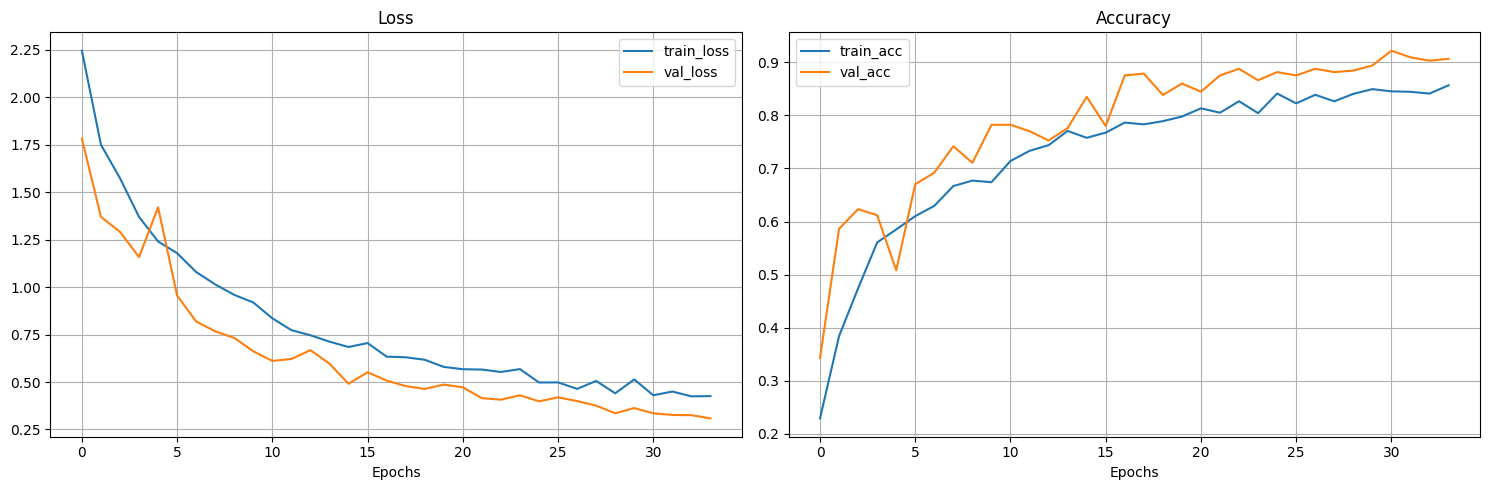

In [ ]:
# retrieve best combos results
model_4_best_results = model_4_all_results[tuple(best_hidden_units_combo)]

# plot curves
plot_loss_curves(model_4_best_results)

The learning curves show that validation accuracy slightly surpasses training accuracy, indicating no overfitting. Both training and validation loss decrease steadily over the epochs, which is a positive sign of convergence. However, there are fluctuations in the validation accuracy, especially in the earlier epochs, which could suggest instability during training. To address this, we might try early stopping later to reduce the number of training epochs and help smooth the curves, stabilizing the performance.

### 2.5. Experimenting with Optimizers and Learning Rates.


In this section, we focus on experimenting with ```optimizers``` and ```learning rates``` to further enhance the model's performance (90%). The choice of [optimizer](https://pytorch.org/docs/stable/optim.html) and learning rate plays a critical role in determining how effectively and efficiently a model learns during training. By exploring different combinations, we aim to identify the optimal settings that balance convergence speed, stability, and final validation accuracy.

In [ ]:
# experiment 2.5: experimenting with optimizers and learning rates
print("Experiment 2.5: Optimizers and Learning Rates")

# generate a simple list of 5 learning rates to try
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # np.logspace(-2, -6, num=5)
print("Learning rates to try:", learning_rates)

# optimizers to try
optimizers = {
    'SGD': optim.SGD,
    'SGD + momentum': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9, nesterov=True, weight_decay=best_decay_value),
    'Adagrad': optim.Adagrad,
    'RMSProp': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'NAdam': optim.NAdam
}
print("Optimizers to try:", list(optimizers.keys()))

# store learning rate for best val accuracy for each optimizer
optim_results_list = []

# loop over optmizers
start_time = time.time()
for optimizer_name, optimizer_fn in optimizers.items():
  print(f"\nTesting {optimizer_name} optimizer...")

  # track best lr and acc for the current optimizer
  best_lr = None
  best_optim_val_accuracy = 0

  # loop over learning rates
  for lr in learning_rates:
    print(f"\nLearning rate: {lr}... \n")

    # re-initializa model for each optimizer and learning rate(with 50 hidden_layer_size)
    model_5 = CNN_v2(hidden_units=best_hidden_units_combo, dropout_probs=best_dropout_probs_combo).to(device)

    # set loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    if optimizer_name == 'SGD + momentum':
      optimizer = optimizer_fn(model_5.parameters(), lr=lr)
    else:
      optimizer = optimizer_fn(model_5.parameters(), lr=lr, weight_decay=best_decay_value)

    # start training
    model_5_results = train(model=model_5,
                            train_dataloader=train_dataloader_M,
                            test_dataloader=val_dataloader_M,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=num_epochs)

    # retrieve val accuracy for the current combination
    val_accuracy = model_5_results['val_acc'][-1]

    # keep track of best val_accuracy
    if val_accuracy > best_optim_val_accuracy:
      best_optim_val_accuracy = val_accuracy
      best_lr = lr

  # save the results in a list
  optim_results_list.append((optimizer_name, best_lr, best_optim_val_accuracy))

  # print best results for the current optimizer
  print(f"\nBest learning rate for {optimizer_name}: {best_lr}")
  print(f"Best validation accuracy for {optimizer_name}: {best_optim_val_accuracy:.2f}%")

# calculate and print total time for the current experiment
end_time = time.time()
print(f"\nTotal experiment's time: {end_time-start_time:.3f} seconds")

# calculate and print total trainable params
trainable_params_5 = sum(p.numel() for p in model_5.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_5}")

Experiment 2.5: Optimizers and Learning Rates
Learning rates to try: [0.01, 0.001, 0.0001, 1e-05, 1e-06]
Optimizers to try: ['SGD', 'SGD + momentum', 'Adagrad', 'RMSProp', 'Adam', 'AdamW', 'NAdam']

Testing SGD optimizer...

Learning rate: 0.01... 



  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3519 | train_acc: 0.0968 | val_loss: 2.2499 | val_acc: 0.1364
Epoch: 2 | train_loss: 2.2625 | train_acc: 0.1182 | val_loss: 2.1477 | val_acc: 0.1364
Epoch: 3 | train_loss: 2.2145 | train_acc: 0.1610 | val_loss: 2.0786 | val_acc: 0.1989
Epoch: 4 | train_loss: 2.1455 | train_acc: 0.2309 | val_loss: 2.0033 | val_acc: 0.3489
Epoch: 5 | train_loss: 2.0548 | train_acc: 0.3304 | val_loss: 1.8900 | val_acc: 0.3648
Epoch: 6 | train_loss: 1.9766 | train_acc: 0.3643 | val_loss: 1.8014 | val_acc: 0.3801
Epoch: 7 | train_loss: 1.8984 | train_acc: 0.3874 | val_loss: 1.7134 | val_acc: 0.4335
Epoch: 8 | train_loss: 1.8231 | train_acc: 0.4194 | val_loss: 1.6494 | val_acc: 0.4051
Epoch: 9 | train_loss: 1.7549 | train_acc: 0.4503 | val_loss: 1.5897 | val_acc: 0.4364
Epoch: 10 | train_loss: 1.6857 | train_acc: 0.4582 | val_loss: 1.4754 | val_acc: 0.4614
Epoch: 11 | train_loss: 1.6178 | train_acc: 0.4820 | val_loss: 1.4175 | val_acc: 0.5142
Epoch: 12 | train_loss: 1.5656 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4075 | train_acc: 0.0682 | val_loss: 2.3927 | val_acc: 0.1222
Epoch: 2 | train_loss: 2.4022 | train_acc: 0.0657 | val_loss: 2.3794 | val_acc: 0.1489
Epoch: 3 | train_loss: 2.3804 | train_acc: 0.0845 | val_loss: 2.3660 | val_acc: 0.1364
Epoch: 4 | train_loss: 2.3722 | train_acc: 0.0938 | val_loss: 2.3536 | val_acc: 0.1364
Epoch: 5 | train_loss: 2.3575 | train_acc: 0.1008 | val_loss: 2.3404 | val_acc: 0.1364
Epoch: 6 | train_loss: 2.3521 | train_acc: 0.0953 | val_loss: 2.3278 | val_acc: 0.1364
Epoch: 7 | train_loss: 2.3471 | train_acc: 0.1074 | val_loss: 2.3141 | val_acc: 0.1364
Epoch: 8 | train_loss: 2.3282 | train_acc: 0.1050 | val_loss: 2.3002 | val_acc: 0.1364
Epoch: 9 | train_loss: 2.3247 | train_acc: 0.1093 | val_loss: 2.2874 | val_acc: 0.1364
Epoch: 10 | train_loss: 2.3055 | train_acc: 0.1199 | val_loss: 2.2735 | val_acc: 0.1364
Epoch: 11 | train_loss: 2.3030 | train_acc: 0.1084 | val_loss: 2.2592 | val_acc: 0.1364
Epoch: 12 | train_loss: 2.2812 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4070 | train_acc: 0.0837 | val_loss: 2.3878 | val_acc: 0.0972
Epoch: 2 | train_loss: 2.4018 | train_acc: 0.0838 | val_loss: 2.3864 | val_acc: 0.1062
Epoch: 3 | train_loss: 2.3963 | train_acc: 0.0722 | val_loss: 2.3850 | val_acc: 0.1153
Epoch: 4 | train_loss: 2.3981 | train_acc: 0.0934 | val_loss: 2.3836 | val_acc: 0.1091
Epoch: 5 | train_loss: 2.3958 | train_acc: 0.0777 | val_loss: 2.3823 | val_acc: 0.1182
Epoch: 6 | train_loss: 2.4069 | train_acc: 0.0650 | val_loss: 2.3810 | val_acc: 0.1182
Epoch: 7 | train_loss: 2.3907 | train_acc: 0.0814 | val_loss: 2.3797 | val_acc: 0.1364
Epoch: 8 | train_loss: 2.3959 | train_acc: 0.0763 | val_loss: 2.3783 | val_acc: 0.1364
Epoch: 9 | train_loss: 2.3918 | train_acc: 0.0858 | val_loss: 2.3769 | val_acc: 0.1364
Epoch: 10 | train_loss: 2.3925 | train_acc: 0.0771 | val_loss: 2.3756 | val_acc: 0.1364
Epoch: 11 | train_loss: 2.3878 | train_acc: 0.0781 | val_loss: 2.3743 | val_acc: 0.1364
Epoch: 12 | train_loss: 2.3921 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4096 | train_acc: 0.0998 | val_loss: 2.3986 | val_acc: 0.1466
Epoch: 2 | train_loss: 2.4138 | train_acc: 0.0979 | val_loss: 2.3985 | val_acc: 0.1466
Epoch: 3 | train_loss: 2.4146 | train_acc: 0.0978 | val_loss: 2.3984 | val_acc: 0.1466
Epoch: 4 | train_loss: 2.4110 | train_acc: 0.1003 | val_loss: 2.3983 | val_acc: 0.1466
Epoch: 5 | train_loss: 2.4088 | train_acc: 0.1007 | val_loss: 2.3982 | val_acc: 0.1466
Epoch: 6 | train_loss: 2.4091 | train_acc: 0.0960 | val_loss: 2.3980 | val_acc: 0.1466
Epoch: 7 | train_loss: 2.4092 | train_acc: 0.0935 | val_loss: 2.3979 | val_acc: 0.1466
Epoch: 8 | train_loss: 2.4078 | train_acc: 0.0927 | val_loss: 2.3978 | val_acc: 0.1466
Epoch: 9 | train_loss: 2.4185 | train_acc: 0.0854 | val_loss: 2.3977 | val_acc: 0.1466
Epoch: 10 | train_loss: 2.4040 | train_acc: 0.0977 | val_loss: 2.3976 | val_acc: 0.1466
Epoch: 11 | train_loss: 2.4081 | train_acc: 0.0831 | val_loss: 2.3975 | val_acc: 0.1466
Epoch: 12 | train_loss: 2.4074 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4104 | train_acc: 0.0872 | val_loss: 2.4043 | val_acc: 0.0813
Epoch: 2 | train_loss: 2.4047 | train_acc: 0.0904 | val_loss: 2.4043 | val_acc: 0.0813
Epoch: 3 | train_loss: 2.4170 | train_acc: 0.0919 | val_loss: 2.4043 | val_acc: 0.0813
Epoch: 4 | train_loss: 2.4152 | train_acc: 0.0904 | val_loss: 2.4043 | val_acc: 0.0813
Epoch: 5 | train_loss: 2.4155 | train_acc: 0.0962 | val_loss: 2.4043 | val_acc: 0.0813
Epoch: 6 | train_loss: 2.4141 | train_acc: 0.1099 | val_loss: 2.4043 | val_acc: 0.0813
Epoch: 7 | train_loss: 2.4060 | train_acc: 0.0943 | val_loss: 2.4043 | val_acc: 0.0813
Epoch: 8 | train_loss: 2.4177 | train_acc: 0.0880 | val_loss: 2.4043 | val_acc: 0.0813
Epoch: 9 | train_loss: 2.4083 | train_acc: 0.0935 | val_loss: 2.4042 | val_acc: 0.0813
Epoch: 10 | train_loss: 2.4101 | train_acc: 0.0969 | val_loss: 2.4042 | val_acc: 0.0813
Epoch: 11 | train_loss: 2.4160 | train_acc: 0.0872 | val_loss: 2.4042 | val_acc: 0.0813
Epoch: 12 | train_loss: 2.4117 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2193 | train_acc: 0.1904 | val_loss: 1.8943 | val_acc: 0.4176
Epoch: 2 | train_loss: 1.8269 | train_acc: 0.3752 | val_loss: 1.4730 | val_acc: 0.4835
Epoch: 3 | train_loss: 1.6526 | train_acc: 0.4520 | val_loss: 1.7436 | val_acc: 0.3483
Epoch: 4 | train_loss: 1.5063 | train_acc: 0.5065 | val_loss: 1.1739 | val_acc: 0.5710
Epoch: 5 | train_loss: 1.3014 | train_acc: 0.5516 | val_loss: 1.0561 | val_acc: 0.5920
Epoch: 6 | train_loss: 1.2360 | train_acc: 0.5785 | val_loss: 0.9355 | val_acc: 0.6261
Epoch: 7 | train_loss: 1.1563 | train_acc: 0.5962 | val_loss: 0.9779 | val_acc: 0.6722
Epoch: 8 | train_loss: 1.1801 | train_acc: 0.6018 | val_loss: 0.9622 | val_acc: 0.6148
Epoch: 9 | train_loss: 1.0684 | train_acc: 0.6324 | val_loss: 0.8154 | val_acc: 0.7074
Epoch: 10 | train_loss: 1.0165 | train_acc: 0.6552 | val_loss: 0.8347 | val_acc: 0.6790
Epoch: 11 | train_loss: 0.9897 | train_acc: 0.6568 | val_loss: 0.9116 | val_acc: 0.6619
Epoch: 12 | train_loss: 0.9668 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3736 | train_acc: 0.1462 | val_loss: 2.2977 | val_acc: 0.1864
Epoch: 2 | train_loss: 2.2712 | train_acc: 0.1494 | val_loss: 2.1806 | val_acc: 0.1614
Epoch: 3 | train_loss: 2.2180 | train_acc: 0.1724 | val_loss: 2.1039 | val_acc: 0.2051
Epoch: 4 | train_loss: 2.1498 | train_acc: 0.2250 | val_loss: 2.0365 | val_acc: 0.2426
Epoch: 5 | train_loss: 2.1041 | train_acc: 0.2561 | val_loss: 1.9674 | val_acc: 0.3114
Epoch: 6 | train_loss: 2.0430 | train_acc: 0.2956 | val_loss: 1.9009 | val_acc: 0.3142
Epoch: 7 | train_loss: 1.9718 | train_acc: 0.3353 | val_loss: 1.8093 | val_acc: 0.3676
Epoch: 8 | train_loss: 1.9088 | train_acc: 0.3590 | val_loss: 1.7347 | val_acc: 0.4710
Epoch: 9 | train_loss: 1.8444 | train_acc: 0.4106 | val_loss: 1.6732 | val_acc: 0.5085
Epoch: 10 | train_loss: 1.8029 | train_acc: 0.4373 | val_loss: 1.6106 | val_acc: 0.5023
Epoch: 11 | train_loss: 1.7154 | train_acc: 0.4590 | val_loss: 1.5354 | val_acc: 0.5398
Epoch: 12 | train_loss: 1.6558 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3935 | train_acc: 0.1290 | val_loss: 2.3933 | val_acc: 0.1540
Epoch: 2 | train_loss: 2.3804 | train_acc: 0.1451 | val_loss: 2.3826 | val_acc: 0.2114
Epoch: 3 | train_loss: 2.3716 | train_acc: 0.1510 | val_loss: 2.3715 | val_acc: 0.2051
Epoch: 4 | train_loss: 2.3569 | train_acc: 0.1536 | val_loss: 2.3587 | val_acc: 0.1989
Epoch: 5 | train_loss: 2.3538 | train_acc: 0.1561 | val_loss: 2.3476 | val_acc: 0.1864
Epoch: 6 | train_loss: 2.3407 | train_acc: 0.1576 | val_loss: 2.3352 | val_acc: 0.1676
Epoch: 7 | train_loss: 2.3362 | train_acc: 0.1599 | val_loss: 2.3222 | val_acc: 0.1614
Epoch: 8 | train_loss: 2.3268 | train_acc: 0.1438 | val_loss: 2.3090 | val_acc: 0.1551
Epoch: 9 | train_loss: 2.3110 | train_acc: 0.1380 | val_loss: 2.2951 | val_acc: 0.1551
Epoch: 10 | train_loss: 2.3089 | train_acc: 0.1331 | val_loss: 2.2820 | val_acc: 0.1551
Epoch: 11 | train_loss: 2.3087 | train_acc: 0.1340 | val_loss: 2.2685 | val_acc: 0.1551
Epoch: 12 | train_loss: 2.2976 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4057 | train_acc: 0.1074 | val_loss: 2.3965 | val_acc: 0.1000
Epoch: 2 | train_loss: 2.4041 | train_acc: 0.1060 | val_loss: 2.3956 | val_acc: 0.1000
Epoch: 3 | train_loss: 2.3992 | train_acc: 0.1140 | val_loss: 2.3948 | val_acc: 0.1000
Epoch: 4 | train_loss: 2.4011 | train_acc: 0.1098 | val_loss: 2.3939 | val_acc: 0.1000
Epoch: 5 | train_loss: 2.4039 | train_acc: 0.1091 | val_loss: 2.3932 | val_acc: 0.1000
Epoch: 6 | train_loss: 2.4044 | train_acc: 0.1173 | val_loss: 2.3924 | val_acc: 0.1000
Epoch: 7 | train_loss: 2.4001 | train_acc: 0.1223 | val_loss: 2.3916 | val_acc: 0.1000
Epoch: 8 | train_loss: 2.3976 | train_acc: 0.1174 | val_loss: 2.3908 | val_acc: 0.1000
Epoch: 9 | train_loss: 2.3966 | train_acc: 0.1315 | val_loss: 2.3899 | val_acc: 0.1091
Epoch: 10 | train_loss: 2.3972 | train_acc: 0.1124 | val_loss: 2.3892 | val_acc: 0.1091
Epoch: 11 | train_loss: 2.3940 | train_acc: 0.1291 | val_loss: 2.3884 | val_acc: 0.1216
Epoch: 12 | train_loss: 2.3917 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4153 | train_acc: 0.0687 | val_loss: 2.3970 | val_acc: 0.0813
Epoch: 2 | train_loss: 2.4107 | train_acc: 0.0863 | val_loss: 2.3968 | val_acc: 0.0813
Epoch: 3 | train_loss: 2.4151 | train_acc: 0.0705 | val_loss: 2.3967 | val_acc: 0.0750
Epoch: 4 | train_loss: 2.4124 | train_acc: 0.0755 | val_loss: 2.3966 | val_acc: 0.0750
Epoch: 5 | train_loss: 2.4161 | train_acc: 0.0854 | val_loss: 2.3964 | val_acc: 0.0750
Epoch: 6 | train_loss: 2.4097 | train_acc: 0.0648 | val_loss: 2.3962 | val_acc: 0.0750
Epoch: 7 | train_loss: 2.4128 | train_acc: 0.0740 | val_loss: 2.3961 | val_acc: 0.0750
Epoch: 8 | train_loss: 2.4099 | train_acc: 0.0664 | val_loss: 2.3959 | val_acc: 0.0750
Epoch: 9 | train_loss: 2.4129 | train_acc: 0.0690 | val_loss: 2.3958 | val_acc: 0.0750
Epoch: 10 | train_loss: 2.4133 | train_acc: 0.0600 | val_loss: 2.3956 | val_acc: 0.0688
Epoch: 11 | train_loss: 2.4079 | train_acc: 0.0649 | val_loss: 2.3955 | val_acc: 0.0750
Epoch: 12 | train_loss: 2.4050 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2725 | train_acc: 0.2152 | val_loss: 1.8230 | val_acc: 0.3898
Epoch: 2 | train_loss: 1.7290 | train_acc: 0.3925 | val_loss: 1.4485 | val_acc: 0.4517
Epoch: 3 | train_loss: 1.5055 | train_acc: 0.5021 | val_loss: 1.2143 | val_acc: 0.5926
Epoch: 4 | train_loss: 1.3203 | train_acc: 0.5568 | val_loss: 1.0222 | val_acc: 0.6580
Epoch: 5 | train_loss: 1.1986 | train_acc: 0.6034 | val_loss: 0.9676 | val_acc: 0.6261
Epoch: 6 | train_loss: 1.0907 | train_acc: 0.6402 | val_loss: 0.8670 | val_acc: 0.7017
Epoch: 7 | train_loss: 1.0135 | train_acc: 0.6500 | val_loss: 0.8283 | val_acc: 0.6773
Epoch: 8 | train_loss: 0.9666 | train_acc: 0.6846 | val_loss: 0.7309 | val_acc: 0.7227
Epoch: 9 | train_loss: 0.8803 | train_acc: 0.7030 | val_loss: 0.7179 | val_acc: 0.7511
Epoch: 10 | train_loss: 0.8458 | train_acc: 0.7297 | val_loss: 0.6546 | val_acc: 0.7665
Epoch: 11 | train_loss: 0.8123 | train_acc: 0.7256 | val_loss: 0.6780 | val_acc: 0.7540
Epoch: 12 | train_loss: 0.7775 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2455 | train_acc: 0.1360 | val_loss: 2.0801 | val_acc: 0.1926
Epoch: 2 | train_loss: 2.0980 | train_acc: 0.2747 | val_loss: 1.9155 | val_acc: 0.3489
Epoch: 3 | train_loss: 1.9469 | train_acc: 0.3795 | val_loss: 1.7524 | val_acc: 0.4080
Epoch: 4 | train_loss: 1.8008 | train_acc: 0.4098 | val_loss: 1.6070 | val_acc: 0.4642
Epoch: 5 | train_loss: 1.7643 | train_acc: 0.4023 | val_loss: 1.5506 | val_acc: 0.5114
Epoch: 6 | train_loss: 1.6790 | train_acc: 0.4562 | val_loss: 1.4934 | val_acc: 0.5051
Epoch: 7 | train_loss: 1.6300 | train_acc: 0.4560 | val_loss: 1.4711 | val_acc: 0.5364
Epoch: 8 | train_loss: 1.5999 | train_acc: 0.4795 | val_loss: 1.4387 | val_acc: 0.5205
Epoch: 9 | train_loss: 1.5832 | train_acc: 0.4731 | val_loss: 1.3979 | val_acc: 0.5517
Epoch: 10 | train_loss: 1.5393 | train_acc: 0.4945 | val_loss: 1.3575 | val_acc: 0.5551
Epoch: 11 | train_loss: 1.5412 | train_acc: 0.4937 | val_loss: 1.3404 | val_acc: 0.5517
Epoch: 12 | train_loss: 1.4888 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3801 | train_acc: 0.0854 | val_loss: 2.3510 | val_acc: 0.1125
Epoch: 2 | train_loss: 2.3549 | train_acc: 0.1099 | val_loss: 2.3346 | val_acc: 0.0989
Epoch: 3 | train_loss: 2.3399 | train_acc: 0.1051 | val_loss: 2.3204 | val_acc: 0.1432
Epoch: 4 | train_loss: 2.3262 | train_acc: 0.1073 | val_loss: 2.3075 | val_acc: 0.1364
Epoch: 5 | train_loss: 2.3207 | train_acc: 0.1100 | val_loss: 2.2954 | val_acc: 0.1364
Epoch: 6 | train_loss: 2.3060 | train_acc: 0.1159 | val_loss: 2.2840 | val_acc: 0.1364
Epoch: 7 | train_loss: 2.3048 | train_acc: 0.1033 | val_loss: 2.2742 | val_acc: 0.1364
Epoch: 8 | train_loss: 2.3088 | train_acc: 0.1060 | val_loss: 2.2661 | val_acc: 0.1364
Epoch: 9 | train_loss: 2.2925 | train_acc: 0.1124 | val_loss: 2.2573 | val_acc: 0.1364
Epoch: 10 | train_loss: 2.2916 | train_acc: 0.1148 | val_loss: 2.2497 | val_acc: 0.1364
Epoch: 11 | train_loss: 2.2853 | train_acc: 0.1125 | val_loss: 2.2436 | val_acc: 0.1364
Epoch: 12 | train_loss: 2.2749 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4029 | train_acc: 0.0781 | val_loss: 2.3960 | val_acc: 0.1000
Epoch: 2 | train_loss: 2.4035 | train_acc: 0.0853 | val_loss: 2.3933 | val_acc: 0.1000
Epoch: 3 | train_loss: 2.3926 | train_acc: 0.0773 | val_loss: 2.3914 | val_acc: 0.1000
Epoch: 4 | train_loss: 2.3998 | train_acc: 0.0829 | val_loss: 2.3897 | val_acc: 0.1062
Epoch: 5 | train_loss: 2.3941 | train_acc: 0.0852 | val_loss: 2.3883 | val_acc: 0.1062
Epoch: 6 | train_loss: 2.3945 | train_acc: 0.0811 | val_loss: 2.3869 | val_acc: 0.1062
Epoch: 7 | train_loss: 2.3957 | train_acc: 0.0764 | val_loss: 2.3858 | val_acc: 0.1062
Epoch: 8 | train_loss: 2.3879 | train_acc: 0.0763 | val_loss: 2.3847 | val_acc: 0.1062
Epoch: 9 | train_loss: 2.3878 | train_acc: 0.0872 | val_loss: 2.3836 | val_acc: 0.1062
Epoch: 10 | train_loss: 2.3900 | train_acc: 0.0910 | val_loss: 2.3827 | val_acc: 0.1062
Epoch: 11 | train_loss: 2.3914 | train_acc: 0.0880 | val_loss: 2.3818 | val_acc: 0.1062
Epoch: 12 | train_loss: 2.3834 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4102 | train_acc: 0.1272 | val_loss: 2.4065 | val_acc: 0.0813
Epoch: 2 | train_loss: 2.4058 | train_acc: 0.1313 | val_loss: 2.4063 | val_acc: 0.0813
Epoch: 3 | train_loss: 2.4112 | train_acc: 0.1076 | val_loss: 2.4061 | val_acc: 0.0813
Epoch: 4 | train_loss: 2.4087 | train_acc: 0.1110 | val_loss: 2.4060 | val_acc: 0.0813
Epoch: 5 | train_loss: 2.4077 | train_acc: 0.1133 | val_loss: 2.4059 | val_acc: 0.0813
Epoch: 6 | train_loss: 2.4064 | train_acc: 0.1222 | val_loss: 2.4058 | val_acc: 0.0813
Epoch: 7 | train_loss: 2.4045 | train_acc: 0.1289 | val_loss: 2.4057 | val_acc: 0.0813
Epoch: 8 | train_loss: 2.4071 | train_acc: 0.1126 | val_loss: 2.4056 | val_acc: 0.0813
Epoch: 9 | train_loss: 2.4056 | train_acc: 0.1175 | val_loss: 2.4055 | val_acc: 0.0813
Epoch: 10 | train_loss: 2.4011 | train_acc: 0.1182 | val_loss: 2.4054 | val_acc: 0.0813
Epoch: 11 | train_loss: 2.4125 | train_acc: 0.1157 | val_loss: 2.4053 | val_acc: 0.0813
Epoch: 12 | train_loss: 2.4051 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 170.8339 | train_acc: 0.1157 | val_loss: 2.3548 | val_acc: 0.1364
Epoch: 2 | train_loss: 2.4003 | train_acc: 0.1125 | val_loss: 2.3660 | val_acc: 0.0938
Epoch: 3 | train_loss: 2.3988 | train_acc: 0.1114 | val_loss: 2.3531 | val_acc: 0.0813
Epoch: 4 | train_loss: 2.3814 | train_acc: 0.1205 | val_loss: 2.3564 | val_acc: 0.0813
Epoch: 5 | train_loss: 2.3783 | train_acc: 0.1140 | val_loss: 2.3568 | val_acc: 0.0813
Epoch: 6 | train_loss: 2.3862 | train_acc: 0.1208 | val_loss: 2.3465 | val_acc: 0.0813
Epoch: 7 | train_loss: 2.3913 | train_acc: 0.1026 | val_loss: 2.3602 | val_acc: 0.0813
Epoch: 8 | train_loss: 2.3815 | train_acc: 0.1239 | val_loss: 2.3674 | val_acc: 0.0813
Epoch: 9 | train_loss: 2.3798 | train_acc: 0.1265 | val_loss: 2.3658 | val_acc: 0.0813
Epoch: 10 | train_loss: 2.5143 | train_acc: 0.1142 | val_loss: 2.3612 | val_acc: 0.1375
Epoch: 11 | train_loss: 2.3755 | train_acc: 0.1247 | val_loss: 2.3516 | val_acc: 0.0813
Epoch: 12 | train_loss: 2.3799 | train_

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1765 | train_acc: 0.2280 | val_loss: 1.7984 | val_acc: 0.2801
Epoch: 2 | train_loss: 1.7689 | train_acc: 0.3565 | val_loss: 1.5040 | val_acc: 0.5489
Epoch: 3 | train_loss: 1.5583 | train_acc: 0.4901 | val_loss: 1.2712 | val_acc: 0.5210
Epoch: 4 | train_loss: 1.3934 | train_acc: 0.5516 | val_loss: 1.1746 | val_acc: 0.5801
Epoch: 5 | train_loss: 1.2436 | train_acc: 0.5796 | val_loss: 1.0124 | val_acc: 0.6483
Epoch: 6 | train_loss: 1.1061 | train_acc: 0.6411 | val_loss: 0.9899 | val_acc: 0.6455
Epoch: 7 | train_loss: 1.0438 | train_acc: 0.6501 | val_loss: 0.8601 | val_acc: 0.7136
Epoch: 8 | train_loss: 0.9979 | train_acc: 0.6674 | val_loss: 0.7918 | val_acc: 0.7227
Epoch: 9 | train_loss: 0.9302 | train_acc: 0.7009 | val_loss: 0.7927 | val_acc: 0.7199
Epoch: 10 | train_loss: 0.9011 | train_acc: 0.6956 | val_loss: 0.7994 | val_acc: 0.7517
Epoch: 11 | train_loss: 0.9100 | train_acc: 0.7084 | val_loss: 0.7098 | val_acc: 0.7790
Epoch: 12 | train_loss: 0.8172 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2344 | train_acc: 0.1454 | val_loss: 2.0785 | val_acc: 0.2392
Epoch: 2 | train_loss: 2.0917 | train_acc: 0.2232 | val_loss: 1.8917 | val_acc: 0.3330
Epoch: 3 | train_loss: 1.9830 | train_acc: 0.3348 | val_loss: 1.7886 | val_acc: 0.5114
Epoch: 4 | train_loss: 1.8947 | train_acc: 0.4291 | val_loss: 1.6872 | val_acc: 0.5023
Epoch: 5 | train_loss: 1.8361 | train_acc: 0.4403 | val_loss: 1.5952 | val_acc: 0.5392
Epoch: 6 | train_loss: 1.7611 | train_acc: 0.4524 | val_loss: 1.5373 | val_acc: 0.5114
Epoch: 7 | train_loss: 1.6400 | train_acc: 0.4819 | val_loss: 1.4507 | val_acc: 0.5148
Epoch: 8 | train_loss: 1.6059 | train_acc: 0.4969 | val_loss: 1.4202 | val_acc: 0.5449
Epoch: 9 | train_loss: 1.5646 | train_acc: 0.4904 | val_loss: 1.3539 | val_acc: 0.5426
Epoch: 10 | train_loss: 1.5006 | train_acc: 0.5277 | val_loss: 1.3209 | val_acc: 0.5642
Epoch: 11 | train_loss: 1.4739 | train_acc: 0.5354 | val_loss: 1.2778 | val_acc: 0.5830
Epoch: 12 | train_loss: 1.4365 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3796 | train_acc: 0.0937 | val_loss: 2.3654 | val_acc: 0.1216
Epoch: 2 | train_loss: 2.3553 | train_acc: 0.1174 | val_loss: 2.3433 | val_acc: 0.2148
Epoch: 3 | train_loss: 2.3410 | train_acc: 0.1150 | val_loss: 2.3224 | val_acc: 0.1489
Epoch: 4 | train_loss: 2.3234 | train_acc: 0.1190 | val_loss: 2.3007 | val_acc: 0.1426
Epoch: 5 | train_loss: 2.3201 | train_acc: 0.1099 | val_loss: 2.2808 | val_acc: 0.1364
Epoch: 6 | train_loss: 2.3068 | train_acc: 0.1168 | val_loss: 2.2626 | val_acc: 0.1364
Epoch: 7 | train_loss: 2.2847 | train_acc: 0.1139 | val_loss: 2.2431 | val_acc: 0.1364
Epoch: 8 | train_loss: 2.2714 | train_acc: 0.1198 | val_loss: 2.2274 | val_acc: 0.1364
Epoch: 9 | train_loss: 2.2679 | train_acc: 0.1273 | val_loss: 2.2133 | val_acc: 0.1364
Epoch: 10 | train_loss: 2.2563 | train_acc: 0.1261 | val_loss: 2.2009 | val_acc: 0.1364
Epoch: 11 | train_loss: 2.2547 | train_acc: 0.1281 | val_loss: 2.1908 | val_acc: 0.1364
Epoch: 12 | train_loss: 2.2400 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4096 | train_acc: 0.0616 | val_loss: 2.3974 | val_acc: 0.0551
Epoch: 2 | train_loss: 2.4034 | train_acc: 0.0608 | val_loss: 2.3942 | val_acc: 0.0761
Epoch: 3 | train_loss: 2.3985 | train_acc: 0.0724 | val_loss: 2.3916 | val_acc: 0.0699
Epoch: 4 | train_loss: 2.4015 | train_acc: 0.0739 | val_loss: 2.3893 | val_acc: 0.0881
Epoch: 5 | train_loss: 2.3969 | train_acc: 0.0829 | val_loss: 2.3871 | val_acc: 0.1244
Epoch: 6 | train_loss: 2.3913 | train_acc: 0.0778 | val_loss: 2.3850 | val_acc: 0.1244
Epoch: 7 | train_loss: 2.3922 | train_acc: 0.0763 | val_loss: 2.3831 | val_acc: 0.1335
Epoch: 8 | train_loss: 2.3887 | train_acc: 0.0624 | val_loss: 2.3812 | val_acc: 0.1426
Epoch: 9 | train_loss: 2.3892 | train_acc: 0.0747 | val_loss: 2.3793 | val_acc: 0.1426
Epoch: 10 | train_loss: 2.3900 | train_acc: 0.0724 | val_loss: 2.3774 | val_acc: 0.1364
Epoch: 11 | train_loss: 2.3811 | train_acc: 0.0837 | val_loss: 2.3754 | val_acc: 0.1364
Epoch: 12 | train_loss: 2.3821 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4029 | train_acc: 0.1853 | val_loss: 1.7928 | val_acc: 0.3648
Epoch: 2 | train_loss: 2.0470 | train_acc: 0.2894 | val_loss: 1.6518 | val_acc: 0.4585
Epoch: 3 | train_loss: 1.9420 | train_acc: 0.3458 | val_loss: 1.7519 | val_acc: 0.3648
Epoch: 4 | train_loss: 1.9230 | train_acc: 0.3365 | val_loss: 1.4806 | val_acc: 0.4932
Epoch: 5 | train_loss: 1.8184 | train_acc: 0.3742 | val_loss: 1.4843 | val_acc: 0.4489
Epoch: 6 | train_loss: 1.8062 | train_acc: 0.3639 | val_loss: 1.4990 | val_acc: 0.4642
Epoch: 7 | train_loss: 1.7817 | train_acc: 0.3836 | val_loss: 1.4078 | val_acc: 0.4801
Epoch: 8 | train_loss: 1.9563 | train_acc: 0.3677 | val_loss: 1.9865 | val_acc: 0.2324
Epoch: 9 | train_loss: 1.9994 | train_acc: 0.3077 | val_loss: 1.5595 | val_acc: 0.4330
Epoch: 10 | train_loss: 1.8680 | train_acc: 0.3783 | val_loss: 1.6388 | val_acc: 0.4102
Epoch: 11 | train_loss: 1.9084 | train_acc: 0.3557 | val_loss: 1.9153 | val_acc: 0.2869
Epoch: 12 | train_loss: 1.8422 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2014 | train_acc: 0.2141 | val_loss: 1.8983 | val_acc: 0.4523
Epoch: 2 | train_loss: 1.8728 | train_acc: 0.3661 | val_loss: 1.4981 | val_acc: 0.5114
Epoch: 3 | train_loss: 1.6536 | train_acc: 0.4566 | val_loss: 1.3230 | val_acc: 0.5335
Epoch: 4 | train_loss: 1.4061 | train_acc: 0.5417 | val_loss: 1.0597 | val_acc: 0.6239
Epoch: 5 | train_loss: 1.2743 | train_acc: 0.5781 | val_loss: 0.9726 | val_acc: 0.6670
Epoch: 6 | train_loss: 1.1360 | train_acc: 0.6240 | val_loss: 0.9159 | val_acc: 0.6455
Epoch: 7 | train_loss: 1.0127 | train_acc: 0.6438 | val_loss: 0.7828 | val_acc: 0.7324
Epoch: 8 | train_loss: 0.9389 | train_acc: 0.6839 | val_loss: 0.7363 | val_acc: 0.7352
Epoch: 9 | train_loss: 0.8601 | train_acc: 0.7159 | val_loss: 0.6610 | val_acc: 0.7665
Epoch: 10 | train_loss: 0.8680 | train_acc: 0.7159 | val_loss: 0.6405 | val_acc: 0.7665
Epoch: 11 | train_loss: 0.7940 | train_acc: 0.7332 | val_loss: 0.6313 | val_acc: 0.7920
Epoch: 12 | train_loss: 0.7059 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3509 | train_acc: 0.0944 | val_loss: 2.2356 | val_acc: 0.1364
Epoch: 2 | train_loss: 2.2447 | train_acc: 0.1249 | val_loss: 2.1362 | val_acc: 0.1551
Epoch: 3 | train_loss: 2.1789 | train_acc: 0.1577 | val_loss: 2.0622 | val_acc: 0.2460
Epoch: 4 | train_loss: 2.1172 | train_acc: 0.2232 | val_loss: 1.9727 | val_acc: 0.3398
Epoch: 5 | train_loss: 2.0232 | train_acc: 0.2988 | val_loss: 1.8339 | val_acc: 0.4960
Epoch: 6 | train_loss: 1.9224 | train_acc: 0.3958 | val_loss: 1.7232 | val_acc: 0.4835
Epoch: 7 | train_loss: 1.8482 | train_acc: 0.4279 | val_loss: 1.6150 | val_acc: 0.4898
Epoch: 8 | train_loss: 1.7499 | train_acc: 0.4313 | val_loss: 1.5276 | val_acc: 0.4835
Epoch: 9 | train_loss: 1.6870 | train_acc: 0.4473 | val_loss: 1.4825 | val_acc: 0.5335
Epoch: 10 | train_loss: 1.6536 | train_acc: 0.4900 | val_loss: 1.4386 | val_acc: 0.5273
Epoch: 11 | train_loss: 1.6044 | train_acc: 0.4850 | val_loss: 1.4089 | val_acc: 0.5551
Epoch: 12 | train_loss: 1.5744 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3997 | train_acc: 0.0992 | val_loss: 2.3796 | val_acc: 0.1091
Epoch: 2 | train_loss: 2.3845 | train_acc: 0.1248 | val_loss: 2.3624 | val_acc: 0.2398
Epoch: 3 | train_loss: 2.3570 | train_acc: 0.1321 | val_loss: 2.3436 | val_acc: 0.2426
Epoch: 4 | train_loss: 2.3474 | train_acc: 0.1330 | val_loss: 2.3212 | val_acc: 0.1926
Epoch: 5 | train_loss: 2.3298 | train_acc: 0.1313 | val_loss: 2.3019 | val_acc: 0.1864
Epoch: 6 | train_loss: 2.3121 | train_acc: 0.1370 | val_loss: 2.2771 | val_acc: 0.1676
Epoch: 7 | train_loss: 2.2940 | train_acc: 0.1340 | val_loss: 2.2532 | val_acc: 0.1614
Epoch: 8 | train_loss: 2.2717 | train_acc: 0.1386 | val_loss: 2.2343 | val_acc: 0.1551
Epoch: 9 | train_loss: 2.2779 | train_acc: 0.1308 | val_loss: 2.2138 | val_acc: 0.1551
Epoch: 10 | train_loss: 2.2568 | train_acc: 0.1387 | val_loss: 2.2007 | val_acc: 0.1551
Epoch: 11 | train_loss: 2.2510 | train_acc: 0.1296 | val_loss: 2.1883 | val_acc: 0.1551
Epoch: 12 | train_loss: 2.2484 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4012 | train_acc: 0.0757 | val_loss: 2.4040 | val_acc: 0.0187
Epoch: 2 | train_loss: 2.4006 | train_acc: 0.0811 | val_loss: 2.4022 | val_acc: 0.0187
Epoch: 3 | train_loss: 2.4042 | train_acc: 0.0693 | val_loss: 2.4003 | val_acc: 0.0278
Epoch: 4 | train_loss: 2.3946 | train_acc: 0.0895 | val_loss: 2.3984 | val_acc: 0.0278
Epoch: 5 | train_loss: 2.3910 | train_acc: 0.0872 | val_loss: 2.3965 | val_acc: 0.0278
Epoch: 6 | train_loss: 2.3930 | train_acc: 0.0888 | val_loss: 2.3946 | val_acc: 0.0551
Epoch: 7 | train_loss: 2.3888 | train_acc: 0.0911 | val_loss: 2.3928 | val_acc: 0.0824
Epoch: 8 | train_loss: 2.3881 | train_acc: 0.0880 | val_loss: 2.3910 | val_acc: 0.0915
Epoch: 9 | train_loss: 2.3860 | train_acc: 0.0911 | val_loss: 2.3891 | val_acc: 0.1097
Epoch: 10 | train_loss: 2.3849 | train_acc: 0.0938 | val_loss: 2.3872 | val_acc: 0.1097
Epoch: 11 | train_loss: 2.3806 | train_acc: 0.1014 | val_loss: 2.3853 | val_acc: 0.1187
Epoch: 12 | train_loss: 2.3847 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5028 | train_acc: 0.1224 | val_loss: 2.3515 | val_acc: 0.0813
Epoch: 2 | train_loss: 2.3710 | train_acc: 0.1176 | val_loss: 2.3664 | val_acc: 0.0813
Epoch: 3 | train_loss: 2.3704 | train_acc: 0.1216 | val_loss: 2.3434 | val_acc: 0.0813
Epoch: 4 | train_loss: 2.3759 | train_acc: 0.1093 | val_loss: 2.3552 | val_acc: 0.0938
Epoch: 5 | train_loss: 2.3696 | train_acc: 0.1200 | val_loss: 2.3511 | val_acc: 0.0938
Epoch: 6 | train_loss: 2.3746 | train_acc: 0.1207 | val_loss: 2.3684 | val_acc: 0.0938
Epoch: 7 | train_loss: 2.3732 | train_acc: 0.1241 | val_loss: 2.3522 | val_acc: 0.0938
Epoch: 8 | train_loss: 2.3733 | train_acc: 0.1198 | val_loss: 2.3513 | val_acc: 0.0938
Epoch: 9 | train_loss: 2.3680 | train_acc: 0.1230 | val_loss: 2.3557 | val_acc: 0.0813
Epoch: 10 | train_loss: 2.3676 | train_acc: 0.1249 | val_loss: 2.3650 | val_acc: 0.0813
Epoch: 11 | train_loss: 2.3740 | train_acc: 0.1053 | val_loss: 2.3599 | val_acc: 0.0813
Epoch: 12 | train_loss: 2.3682 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2141 | train_acc: 0.1825 | val_loss: 1.8983 | val_acc: 0.3364
Epoch: 2 | train_loss: 1.8367 | train_acc: 0.3595 | val_loss: 1.5002 | val_acc: 0.4926
Epoch: 3 | train_loss: 1.6065 | train_acc: 0.4508 | val_loss: 1.3513 | val_acc: 0.5205
Epoch: 4 | train_loss: 1.4276 | train_acc: 0.5221 | val_loss: 1.1231 | val_acc: 0.6392
Epoch: 5 | train_loss: 1.3096 | train_acc: 0.5568 | val_loss: 1.0639 | val_acc: 0.6148
Epoch: 6 | train_loss: 1.1611 | train_acc: 0.6018 | val_loss: 0.9726 | val_acc: 0.7045
Epoch: 7 | train_loss: 1.0662 | train_acc: 0.6384 | val_loss: 0.9477 | val_acc: 0.6795
Epoch: 8 | train_loss: 0.9986 | train_acc: 0.6511 | val_loss: 0.8646 | val_acc: 0.7233
Epoch: 9 | train_loss: 0.9863 | train_acc: 0.6648 | val_loss: 0.7968 | val_acc: 0.7170
Epoch: 10 | train_loss: 0.8915 | train_acc: 0.6936 | val_loss: 0.7409 | val_acc: 0.7483
Epoch: 11 | train_loss: 0.8396 | train_acc: 0.7209 | val_loss: 0.6719 | val_acc: 0.7636
Epoch: 12 | train_loss: 0.8327 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3370 | train_acc: 0.1057 | val_loss: 2.2374 | val_acc: 0.1364
Epoch: 2 | train_loss: 2.2508 | train_acc: 0.1182 | val_loss: 2.1491 | val_acc: 0.1864
Epoch: 3 | train_loss: 2.1800 | train_acc: 0.1562 | val_loss: 2.0639 | val_acc: 0.2489
Epoch: 4 | train_loss: 2.1168 | train_acc: 0.2151 | val_loss: 1.9622 | val_acc: 0.3176
Epoch: 5 | train_loss: 2.0181 | train_acc: 0.3052 | val_loss: 1.8531 | val_acc: 0.4273
Epoch: 6 | train_loss: 1.9294 | train_acc: 0.3646 | val_loss: 1.7336 | val_acc: 0.4523
Epoch: 7 | train_loss: 1.8508 | train_acc: 0.4153 | val_loss: 1.6448 | val_acc: 0.5148
Epoch: 8 | train_loss: 1.8166 | train_acc: 0.4332 | val_loss: 1.5811 | val_acc: 0.5239
Epoch: 9 | train_loss: 1.7365 | train_acc: 0.4379 | val_loss: 1.5137 | val_acc: 0.5267
Epoch: 10 | train_loss: 1.6421 | train_acc: 0.4787 | val_loss: 1.4491 | val_acc: 0.5330
Epoch: 11 | train_loss: 1.6326 | train_acc: 0.4807 | val_loss: 1.4031 | val_acc: 0.5210
Epoch: 12 | train_loss: 1.5627 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4189 | train_acc: 0.1179 | val_loss: 2.4012 | val_acc: 0.1500
Epoch: 2 | train_loss: 2.3895 | train_acc: 0.1191 | val_loss: 2.3861 | val_acc: 0.1437
Epoch: 3 | train_loss: 2.3763 | train_acc: 0.1280 | val_loss: 2.3718 | val_acc: 0.1523
Epoch: 4 | train_loss: 2.3581 | train_acc: 0.1462 | val_loss: 2.3556 | val_acc: 0.2188
Epoch: 5 | train_loss: 2.3430 | train_acc: 0.1347 | val_loss: 2.3363 | val_acc: 0.2364
Epoch: 6 | train_loss: 2.3262 | train_acc: 0.1518 | val_loss: 2.3143 | val_acc: 0.2176
Epoch: 7 | train_loss: 2.3140 | train_acc: 0.1339 | val_loss: 2.2893 | val_acc: 0.1739
Epoch: 8 | train_loss: 2.2983 | train_acc: 0.1371 | val_loss: 2.2650 | val_acc: 0.1551
Epoch: 9 | train_loss: 2.2828 | train_acc: 0.1363 | val_loss: 2.2438 | val_acc: 0.1551
Epoch: 10 | train_loss: 2.2762 | train_acc: 0.1354 | val_loss: 2.2267 | val_acc: 0.1551
Epoch: 11 | train_loss: 2.2667 | train_acc: 0.1339 | val_loss: 2.2126 | val_acc: 0.1551
Epoch: 12 | train_loss: 2.2549 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4113 | train_acc: 0.1222 | val_loss: 2.4006 | val_acc: 0.1250
Epoch: 2 | train_loss: 2.4187 | train_acc: 0.0987 | val_loss: 2.3988 | val_acc: 0.1250
Epoch: 3 | train_loss: 2.4141 | train_acc: 0.1094 | val_loss: 2.3970 | val_acc: 0.1250
Epoch: 4 | train_loss: 2.4110 | train_acc: 0.1123 | val_loss: 2.3952 | val_acc: 0.1250
Epoch: 5 | train_loss: 2.4047 | train_acc: 0.1061 | val_loss: 2.3935 | val_acc: 0.1313
Epoch: 6 | train_loss: 2.4019 | train_acc: 0.1082 | val_loss: 2.3918 | val_acc: 0.1313
Epoch: 7 | train_loss: 2.4013 | train_acc: 0.1028 | val_loss: 2.3901 | val_acc: 0.1313
Epoch: 8 | train_loss: 2.4048 | train_acc: 0.1068 | val_loss: 2.3882 | val_acc: 0.1375
Epoch: 9 | train_loss: 2.3916 | train_acc: 0.1215 | val_loss: 2.3864 | val_acc: 0.1375
Epoch: 10 | train_loss: 2.3937 | train_acc: 0.1208 | val_loss: 2.3846 | val_acc: 0.1437
Epoch: 11 | train_loss: 2.3931 | train_acc: 0.1200 | val_loss: 2.3828 | val_acc: 0.1500
Epoch: 12 | train_loss: 2.3843 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5111 | train_acc: 0.1265 | val_loss: 2.3722 | val_acc: 0.0813
Epoch: 2 | train_loss: 2.3726 | train_acc: 0.1231 | val_loss: 2.3575 | val_acc: 0.0813
Epoch: 3 | train_loss: 2.3723 | train_acc: 0.1231 | val_loss: 2.3441 | val_acc: 0.0938
Epoch: 4 | train_loss: 2.3677 | train_acc: 0.1132 | val_loss: 2.3580 | val_acc: 0.0938
Epoch: 5 | train_loss: 2.3676 | train_acc: 0.1265 | val_loss: 2.3660 | val_acc: 0.0938
Epoch: 6 | train_loss: 2.3658 | train_acc: 0.1200 | val_loss: 2.3494 | val_acc: 0.0813
Epoch: 7 | train_loss: 2.3726 | train_acc: 0.1271 | val_loss: 2.3518 | val_acc: 0.0938
Epoch: 8 | train_loss: 2.3686 | train_acc: 0.1289 | val_loss: 2.3603 | val_acc: 0.0938
Epoch: 9 | train_loss: 2.3694 | train_acc: 0.1159 | val_loss: 2.3522 | val_acc: 0.0813
Epoch: 10 | train_loss: 2.3693 | train_acc: 0.1117 | val_loss: 2.3562 | val_acc: 0.0938
Epoch: 11 | train_loss: 2.3689 | train_acc: 0.1100 | val_loss: 2.3614 | val_acc: 0.0938
Epoch: 12 | train_loss: 2.3682 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1681 | train_acc: 0.2130 | val_loss: 1.7481 | val_acc: 0.3864
Epoch: 2 | train_loss: 1.7428 | train_acc: 0.4144 | val_loss: 1.4084 | val_acc: 0.5114
Epoch: 3 | train_loss: 1.4710 | train_acc: 0.5310 | val_loss: 1.2647 | val_acc: 0.5864
Epoch: 4 | train_loss: 1.3510 | train_acc: 0.5564 | val_loss: 1.0091 | val_acc: 0.6636
Epoch: 5 | train_loss: 1.2002 | train_acc: 0.6014 | val_loss: 0.9866 | val_acc: 0.6852
Epoch: 6 | train_loss: 1.0323 | train_acc: 0.6611 | val_loss: 0.7616 | val_acc: 0.7290
Epoch: 7 | train_loss: 0.9508 | train_acc: 0.6792 | val_loss: 0.8262 | val_acc: 0.7483
Epoch: 8 | train_loss: 0.9475 | train_acc: 0.6993 | val_loss: 0.7407 | val_acc: 0.7477
Epoch: 9 | train_loss: 0.8525 | train_acc: 0.7125 | val_loss: 0.6299 | val_acc: 0.7977
Epoch: 10 | train_loss: 0.7497 | train_acc: 0.7486 | val_loss: 0.6072 | val_acc: 0.8165
Epoch: 11 | train_loss: 0.7358 | train_acc: 0.7645 | val_loss: 0.5652 | val_acc: 0.8102
Epoch: 12 | train_loss: 0.6814 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3433 | train_acc: 0.1265 | val_loss: 2.2300 | val_acc: 0.1426
Epoch: 2 | train_loss: 2.2536 | train_acc: 0.1249 | val_loss: 2.1627 | val_acc: 0.1767
Epoch: 3 | train_loss: 2.1850 | train_acc: 0.1519 | val_loss: 2.0591 | val_acc: 0.2301
Epoch: 4 | train_loss: 2.1089 | train_acc: 0.2382 | val_loss: 1.9652 | val_acc: 0.4551
Epoch: 5 | train_loss: 1.9962 | train_acc: 0.3612 | val_loss: 1.7874 | val_acc: 0.4176
Epoch: 6 | train_loss: 1.8635 | train_acc: 0.4023 | val_loss: 1.6410 | val_acc: 0.4739
Epoch: 7 | train_loss: 1.7576 | train_acc: 0.4219 | val_loss: 1.5125 | val_acc: 0.5330
Epoch: 8 | train_loss: 1.6442 | train_acc: 0.4578 | val_loss: 1.4052 | val_acc: 0.5489
Epoch: 9 | train_loss: 1.5945 | train_acc: 0.4892 | val_loss: 1.3796 | val_acc: 0.5114
Epoch: 10 | train_loss: 1.4910 | train_acc: 0.5131 | val_loss: 1.2841 | val_acc: 0.5892
Epoch: 11 | train_loss: 1.4634 | train_acc: 0.5312 | val_loss: 1.2646 | val_acc: 0.5642
Epoch: 12 | train_loss: 1.4476 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3867 | train_acc: 0.1100 | val_loss: 2.3718 | val_acc: 0.1926
Epoch: 2 | train_loss: 2.3700 | train_acc: 0.1091 | val_loss: 2.3520 | val_acc: 0.1517
Epoch: 3 | train_loss: 2.3513 | train_acc: 0.1201 | val_loss: 2.3314 | val_acc: 0.1364
Epoch: 4 | train_loss: 2.3354 | train_acc: 0.1192 | val_loss: 2.3104 | val_acc: 0.1364
Epoch: 5 | train_loss: 2.3170 | train_acc: 0.1265 | val_loss: 2.2886 | val_acc: 0.1364
Epoch: 6 | train_loss: 2.3123 | train_acc: 0.1222 | val_loss: 2.2681 | val_acc: 0.1364
Epoch: 7 | train_loss: 2.2949 | train_acc: 0.1147 | val_loss: 2.2492 | val_acc: 0.1364
Epoch: 8 | train_loss: 2.2850 | train_acc: 0.1151 | val_loss: 2.2312 | val_acc: 0.1364
Epoch: 9 | train_loss: 2.2612 | train_acc: 0.1109 | val_loss: 2.2140 | val_acc: 0.1364
Epoch: 10 | train_loss: 2.2595 | train_acc: 0.1190 | val_loss: 2.2001 | val_acc: 0.1364
Epoch: 11 | train_loss: 2.2597 | train_acc: 0.1176 | val_loss: 2.1894 | val_acc: 0.1364
Epoch: 12 | train_loss: 2.2503 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3960 | train_acc: 0.0845 | val_loss: 2.3890 | val_acc: 0.0938
Epoch: 2 | train_loss: 2.3939 | train_acc: 0.0987 | val_loss: 2.3874 | val_acc: 0.0938
Epoch: 3 | train_loss: 2.3995 | train_acc: 0.0905 | val_loss: 2.3857 | val_acc: 0.0938
Epoch: 4 | train_loss: 2.3953 | train_acc: 0.0861 | val_loss: 2.3842 | val_acc: 0.0938
Epoch: 5 | train_loss: 2.3923 | train_acc: 0.0846 | val_loss: 2.3826 | val_acc: 0.0938
Epoch: 6 | train_loss: 2.3909 | train_acc: 0.0878 | val_loss: 2.3811 | val_acc: 0.0938
Epoch: 7 | train_loss: 2.3874 | train_acc: 0.1058 | val_loss: 2.3794 | val_acc: 0.0938
Epoch: 8 | train_loss: 2.3861 | train_acc: 0.0968 | val_loss: 2.3778 | val_acc: 0.1028
Epoch: 9 | train_loss: 2.3895 | train_acc: 0.0961 | val_loss: 2.3763 | val_acc: 0.1210
Epoch: 10 | train_loss: 2.3801 | train_acc: 0.1076 | val_loss: 2.3747 | val_acc: 0.1210
Epoch: 11 | train_loss: 2.3841 | train_acc: 0.0967 | val_loss: 2.3732 | val_acc: 0.1301
Epoch: 12 | train_loss: 2.3814 | train_ac

We observe how the learning rate significantly impacts the performance across all optimizers. With a higher learning rate of 0.01, the model struggles to converge, leading to very low validation accuracy. On the other hand, with an extremely low learning rate of 0.000001, the validation accuracy is slightly better but still low. This occurs because a high learning rate causes the model to overshoot the optimal solution, failing to minimize the loss effectively. In contrast, a very low learning rate slows down the training process, preventing the model from reaching an optimal solution within a reasonable number of epochs. Finding the right balance is key to achieving better performance and it comes after much experimentation.

In [ ]:
# print the results in a table and print it in desc order
optimizers_df = pd.DataFrame(optim_results_list, columns=['Optimizer', 'Best Learning Rate', 'Validation Accuracy'])
optimizers_df = optimizers_df.sort_values(by='Validation Accuracy', ascending=False)
print("\n", optimizers_df.to_string(index=False))


      Optimizer  Best Learning Rate  Validation Accuracy
         NAdam               0.001             0.925568
          Adam               0.001             0.894318
         AdamW               0.001             0.890909
       Adagrad               0.010             0.863068
       RMSProp               0.001             0.860227
SGD + momentum               0.010             0.850568
           SGD               0.010             0.723295


We observe that the NAdam optimizer with a learning rate of 0.01 achieved the highest validation accuracy (verify to the above results that overfitting has been effectively eliminated). Therefore, we will use this configuration for our upcoming experiments.

In [ ]:
best_optimizer = optim.NAdam
best_learning_rate = 0.001

Having successfully addressed overfitting, visualizing learning curves is no longer necessary, as the focus now shifts to optimizing other aspects of model performance.

### 2.6. Experimenting with Activation Functions.

In this section, we experiment with different ```activation functions``` to evaluate their impact on the model's performance. [Activation functions](https://machinelearningmastery.com/activation-functions-in-pytorch/) are a key component of neural networks, introducing non-linearity and enabling the model to learn complex patterns in the data. The choice of activation function can significantly influence the convergence speed, stability, and overall accuracy of the model. By testing various activation functions combinations for feature extractor and classifier, we aim to determine which one best suits our architecture and task, ensuring optimal learning and generalization.

In [ ]:
# experiment 2.6: experimenting with activation functions
print("Experiment 2.6: Activation Functions")

# activation functions to try
activation_functions = [
    ('ReLU', nn.ReLU()),
    ('LeakyReLU', nn.LeakyReLU(negative_slope=0.01)),
    ('ELU', nn.ELU()),
    ('GeLU', nn.GELU()),
    #('PReLU', nn.PReLU()),
    ('SiLU', nn.SiLU()),
    ('Mish', nn.Mish())  ]
print("Activation functions to try:", [name for name, _ in activation_functions])

# store the results in a list
activation_results_list = []

# loop over the activation function list
start_time = time.time()
for activation_name1, activation_fn1 in activation_functions:
  print(f"\nTesting {activation_name1} activation function as activation function in feature extractor...")

  for activation_name2, activation_fn2 in activation_functions:
    print(f"\nTesting {activation_name2} activation function as activation function in classifier...")

    # keep track of best validation accuracy
    best_activ_val_accuracy = 0

    # re-initialize model for each combination
    model_6 = CNN_v2(hidden_units=best_hidden_units_combo, dropout_probs=best_dropout_probs_combo, activation_functions=[activation_fn1, activation_fn2]).to(device)

    # set loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = best_optimizer(model_6.parameters(), lr=best_learning_rate, weight_decay=best_decay_value)

    # start training
    model_6_results = train(model=model_6,
                            train_dataloader=train_dataloader_M,
                            test_dataloader=val_dataloader_M,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=num_epochs)

    # retrieve current val accuracy
    val_accuracy = model_6_results['val_acc'][-1]

    # keep track of best val_accuracy
    if val_accuracy > best_activ_val_accuracy:
      best_activ_val_accuracy = val_accuracy
      best_activation_fn1 = activation_fn1
      best_activation_fn2 = activation_fn2

    # save the results in a list
    activation_results_list.append((activation_name1, activation_name2, best_activ_val_accuracy))

    # print best results for the current activation functions combination
    print(f"\nActivation function for feature extractor: {activation_name1}")
    print(f"Activation function for classifier: {activation_name2}")
    print(f"Validation accuracy: {best_activ_val_accuracy:.2f}%\n")

# calculate and print total time for this experiment
end_time = time.time()
print(f"\nTotal experiment's time: {end_time-start_time:.3f} seconds")

# calculate and rint total trainable params
trainable_params_6 = sum(p.numel() for p in model_6.parameters() if p.requires_grad)
print(f"Total trainable params: {trainable_params_6}")

Experiment 2.6: Activation Functions
Activation functions to try: ['ReLU', 'LeakyReLU', 'ELU', 'GeLU', 'SiLU', 'Mish']

Testing ReLU activation function as activation function in feature extractor...

Testing ReLU activation function as activation function in classifier...


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1994 | train_acc: 0.2042 | val_loss: 1.8514 | val_acc: 0.3648
Epoch: 2 | train_loss: 1.8577 | train_acc: 0.3648 | val_loss: 1.5083 | val_acc: 0.4926
Epoch: 3 | train_loss: 1.6416 | train_acc: 0.4375 | val_loss: 1.3634 | val_acc: 0.5676
Epoch: 4 | train_loss: 1.4382 | train_acc: 0.5076 | val_loss: 1.1214 | val_acc: 0.6324
Epoch: 5 | train_loss: 1.3110 | train_acc: 0.5763 | val_loss: 0.9711 | val_acc: 0.6386
Epoch: 6 | train_loss: 1.1572 | train_acc: 0.6067 | val_loss: 0.9258 | val_acc: 0.7011
Epoch: 7 | train_loss: 1.1022 | train_acc: 0.6330 | val_loss: 0.8559 | val_acc: 0.6892
Epoch: 8 | train_loss: 0.9743 | train_acc: 0.6853 | val_loss: 0.7517 | val_acc: 0.7170
Epoch: 9 | train_loss: 0.8887 | train_acc: 0.7002 | val_loss: 0.7133 | val_acc: 0.7449
Epoch: 10 | train_loss: 0.8790 | train_acc: 0.6971 | val_loss: 0.7152 | val_acc: 0.7386
Epoch: 11 | train_loss: 0.8470 | train_acc: 0.7215 | val_loss: 0.6765 | val_acc: 0.7545
Epoch: 12 | train_loss: 0.8498 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2332 | train_acc: 0.1780 | val_loss: 1.9327 | val_acc: 0.3494
Epoch: 2 | train_loss: 1.8885 | train_acc: 0.3489 | val_loss: 1.5299 | val_acc: 0.4801
Epoch: 3 | train_loss: 1.6698 | train_acc: 0.4373 | val_loss: 1.3052 | val_acc: 0.5358
Epoch: 4 | train_loss: 1.5269 | train_acc: 0.4946 | val_loss: 1.2947 | val_acc: 0.5892
Epoch: 5 | train_loss: 1.3564 | train_acc: 0.5638 | val_loss: 1.1557 | val_acc: 0.5767
Epoch: 6 | train_loss: 1.2957 | train_acc: 0.5884 | val_loss: 1.0890 | val_acc: 0.6636
Epoch: 7 | train_loss: 1.1976 | train_acc: 0.6099 | val_loss: 1.0202 | val_acc: 0.6483
Epoch: 8 | train_loss: 1.1269 | train_acc: 0.6281 | val_loss: 0.9253 | val_acc: 0.6767
Epoch: 9 | train_loss: 1.0858 | train_acc: 0.6550 | val_loss: 0.9471 | val_acc: 0.6955
Epoch: 10 | train_loss: 1.0148 | train_acc: 0.6742 | val_loss: 0.8034 | val_acc: 0.7449
Epoch: 11 | train_loss: 0.9647 | train_acc: 0.6862 | val_loss: 0.7484 | val_acc: 0.7483
Epoch: 12 | train_loss: 0.9082 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1739 | train_acc: 0.2074 | val_loss: 1.8011 | val_acc: 0.3472
Epoch: 2 | train_loss: 1.7592 | train_acc: 0.4130 | val_loss: 1.4502 | val_acc: 0.4580
Epoch: 3 | train_loss: 1.4895 | train_acc: 0.4997 | val_loss: 1.1642 | val_acc: 0.5920
Epoch: 4 | train_loss: 1.2817 | train_acc: 0.5820 | val_loss: 0.9862 | val_acc: 0.6642
Epoch: 5 | train_loss: 1.1296 | train_acc: 0.6231 | val_loss: 0.8739 | val_acc: 0.6568
Epoch: 6 | train_loss: 0.9547 | train_acc: 0.6806 | val_loss: 0.7808 | val_acc: 0.7176
Epoch: 7 | train_loss: 0.9258 | train_acc: 0.6878 | val_loss: 0.7283 | val_acc: 0.7727
Epoch: 8 | train_loss: 0.8576 | train_acc: 0.7248 | val_loss: 0.6962 | val_acc: 0.7852
Epoch: 9 | train_loss: 0.8136 | train_acc: 0.7236 | val_loss: 1.0232 | val_acc: 0.6602
Epoch: 10 | train_loss: 0.7832 | train_acc: 0.7364 | val_loss: 0.6176 | val_acc: 0.8261
Epoch: 11 | train_loss: 0.7204 | train_acc: 0.7603 | val_loss: 0.5846 | val_acc: 0.7949
Epoch: 12 | train_loss: 0.6946 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2356 | train_acc: 0.1714 | val_loss: 1.9068 | val_acc: 0.3403
Epoch: 2 | train_loss: 1.8797 | train_acc: 0.3619 | val_loss: 1.6915 | val_acc: 0.4182
Epoch: 3 | train_loss: 1.6412 | train_acc: 0.4483 | val_loss: 1.4043 | val_acc: 0.5176
Epoch: 4 | train_loss: 1.4070 | train_acc: 0.5449 | val_loss: 1.1238 | val_acc: 0.5841
Epoch: 5 | train_loss: 1.2528 | train_acc: 0.5708 | val_loss: 1.0097 | val_acc: 0.5841
Epoch: 6 | train_loss: 1.1567 | train_acc: 0.6027 | val_loss: 0.8860 | val_acc: 0.6364
Epoch: 7 | train_loss: 1.0988 | train_acc: 0.6454 | val_loss: 0.8499 | val_acc: 0.7114
Epoch: 8 | train_loss: 1.0497 | train_acc: 0.6501 | val_loss: 0.7909 | val_acc: 0.7108
Epoch: 9 | train_loss: 0.9408 | train_acc: 0.6772 | val_loss: 0.7597 | val_acc: 0.7324
Epoch: 10 | train_loss: 0.9289 | train_acc: 0.6847 | val_loss: 0.7019 | val_acc: 0.7483
Epoch: 11 | train_loss: 0.8625 | train_acc: 0.7168 | val_loss: 0.6537 | val_acc: 0.7790
Epoch: 12 | train_loss: 0.8510 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2173 | train_acc: 0.1852 | val_loss: 1.8318 | val_acc: 0.3960
Epoch: 2 | train_loss: 1.8736 | train_acc: 0.3998 | val_loss: 1.5204 | val_acc: 0.5205
Epoch: 3 | train_loss: 1.6068 | train_acc: 0.4679 | val_loss: 1.5311 | val_acc: 0.4869
Epoch: 4 | train_loss: 1.4338 | train_acc: 0.5276 | val_loss: 1.2108 | val_acc: 0.5551
Epoch: 5 | train_loss: 1.3377 | train_acc: 0.5893 | val_loss: 1.1328 | val_acc: 0.5858
Epoch: 6 | train_loss: 1.1690 | train_acc: 0.6102 | val_loss: 0.9620 | val_acc: 0.6619
Epoch: 7 | train_loss: 1.0698 | train_acc: 0.6618 | val_loss: 0.8676 | val_acc: 0.7045
Epoch: 8 | train_loss: 1.0002 | train_acc: 0.6772 | val_loss: 0.7995 | val_acc: 0.7261
Epoch: 9 | train_loss: 0.9322 | train_acc: 0.7050 | val_loss: 0.7153 | val_acc: 0.7727
Epoch: 10 | train_loss: 0.8566 | train_acc: 0.7251 | val_loss: 0.6913 | val_acc: 0.7455
Epoch: 11 | train_loss: 0.8369 | train_acc: 0.7127 | val_loss: 0.7160 | val_acc: 0.7415
Epoch: 12 | train_loss: 0.8053 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2095 | train_acc: 0.2028 | val_loss: 1.9882 | val_acc: 0.2875
Epoch: 2 | train_loss: 1.8725 | train_acc: 0.3586 | val_loss: 1.6189 | val_acc: 0.4210
Epoch: 3 | train_loss: 1.6177 | train_acc: 0.4548 | val_loss: 1.3404 | val_acc: 0.5517
Epoch: 4 | train_loss: 1.4614 | train_acc: 0.5407 | val_loss: 1.2182 | val_acc: 0.5705
Epoch: 5 | train_loss: 1.3379 | train_acc: 0.5853 | val_loss: 1.1202 | val_acc: 0.6267
Epoch: 6 | train_loss: 1.2224 | train_acc: 0.6092 | val_loss: 1.0322 | val_acc: 0.6761
Epoch: 7 | train_loss: 1.1512 | train_acc: 0.6254 | val_loss: 0.9113 | val_acc: 0.6915
Epoch: 8 | train_loss: 1.0423 | train_acc: 0.6493 | val_loss: 0.8123 | val_acc: 0.7227
Epoch: 9 | train_loss: 0.9611 | train_acc: 0.6783 | val_loss: 0.7443 | val_acc: 0.7142
Epoch: 10 | train_loss: 0.8950 | train_acc: 0.7074 | val_loss: 0.7179 | val_acc: 0.7511
Epoch: 11 | train_loss: 0.8118 | train_acc: 0.7128 | val_loss: 0.6927 | val_acc: 0.7824
Epoch: 12 | train_loss: 0.8448 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2380 | train_acc: 0.1645 | val_loss: 1.9520 | val_acc: 0.2926
Epoch: 2 | train_loss: 1.9286 | train_acc: 0.3505 | val_loss: 1.6332 | val_acc: 0.3898
Epoch: 3 | train_loss: 1.7054 | train_acc: 0.4131 | val_loss: 1.4270 | val_acc: 0.4835
Epoch: 4 | train_loss: 1.5447 | train_acc: 0.4764 | val_loss: 1.3169 | val_acc: 0.5369
Epoch: 5 | train_loss: 1.3868 | train_acc: 0.5377 | val_loss: 1.1789 | val_acc: 0.5642
Epoch: 6 | train_loss: 1.2566 | train_acc: 0.5837 | val_loss: 1.0004 | val_acc: 0.6545
Epoch: 7 | train_loss: 1.1402 | train_acc: 0.6230 | val_loss: 0.8895 | val_acc: 0.6824
Epoch: 8 | train_loss: 1.0545 | train_acc: 0.6404 | val_loss: 0.8529 | val_acc: 0.7102
Epoch: 9 | train_loss: 0.9955 | train_acc: 0.6815 | val_loss: 0.9165 | val_acc: 0.6852
Epoch: 10 | train_loss: 0.9425 | train_acc: 0.6697 | val_loss: 0.7968 | val_acc: 0.7136
Epoch: 11 | train_loss: 0.8616 | train_acc: 0.6980 | val_loss: 0.7775 | val_acc: 0.7261
Epoch: 12 | train_loss: 0.8731 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2313 | train_acc: 0.1864 | val_loss: 2.1083 | val_acc: 0.2585
Epoch: 2 | train_loss: 1.8412 | train_acc: 0.3433 | val_loss: 1.5273 | val_acc: 0.4614
Epoch: 3 | train_loss: 1.6124 | train_acc: 0.4613 | val_loss: 1.3292 | val_acc: 0.5335
Epoch: 4 | train_loss: 1.4512 | train_acc: 0.5227 | val_loss: 1.1537 | val_acc: 0.5869
Epoch: 5 | train_loss: 1.3562 | train_acc: 0.5589 | val_loss: 1.1390 | val_acc: 0.6148
Epoch: 6 | train_loss: 1.2289 | train_acc: 0.5967 | val_loss: 1.0193 | val_acc: 0.6614
Epoch: 7 | train_loss: 1.1662 | train_acc: 0.5982 | val_loss: 0.9025 | val_acc: 0.6955
Epoch: 8 | train_loss: 1.0207 | train_acc: 0.6551 | val_loss: 0.8068 | val_acc: 0.6949
Epoch: 9 | train_loss: 0.9928 | train_acc: 0.6533 | val_loss: 0.7631 | val_acc: 0.7295
Epoch: 10 | train_loss: 0.9399 | train_acc: 0.7007 | val_loss: 0.7294 | val_acc: 0.7540
Epoch: 11 | train_loss: 0.8638 | train_acc: 0.7051 | val_loss: 0.6154 | val_acc: 0.7636
Epoch: 12 | train_loss: 0.8673 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1666 | train_acc: 0.2093 | val_loss: 1.7694 | val_acc: 0.3710
Epoch: 2 | train_loss: 1.7416 | train_acc: 0.4014 | val_loss: 1.4660 | val_acc: 0.4989
Epoch: 3 | train_loss: 1.5314 | train_acc: 0.4910 | val_loss: 1.2044 | val_acc: 0.5676
Epoch: 4 | train_loss: 1.3276 | train_acc: 0.5720 | val_loss: 1.0858 | val_acc: 0.6477
Epoch: 5 | train_loss: 1.1676 | train_acc: 0.6131 | val_loss: 0.9844 | val_acc: 0.6489
Epoch: 6 | train_loss: 1.0462 | train_acc: 0.6625 | val_loss: 0.7879 | val_acc: 0.6955
Epoch: 7 | train_loss: 0.9699 | train_acc: 0.6528 | val_loss: 0.7340 | val_acc: 0.7227
Epoch: 8 | train_loss: 0.8685 | train_acc: 0.7074 | val_loss: 0.6864 | val_acc: 0.7727
Epoch: 9 | train_loss: 0.8411 | train_acc: 0.7249 | val_loss: 0.6923 | val_acc: 0.7517
Epoch: 10 | train_loss: 0.7892 | train_acc: 0.7407 | val_loss: 0.6063 | val_acc: 0.7852
Epoch: 11 | train_loss: 0.6673 | train_acc: 0.7840 | val_loss: 0.5563 | val_acc: 0.8261
Epoch: 12 | train_loss: 0.7124 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1953 | train_acc: 0.2174 | val_loss: 1.8045 | val_acc: 0.3614
Epoch: 2 | train_loss: 1.8001 | train_acc: 0.3783 | val_loss: 1.4598 | val_acc: 0.4739
Epoch: 3 | train_loss: 1.5491 | train_acc: 0.4769 | val_loss: 1.2332 | val_acc: 0.5710
Epoch: 4 | train_loss: 1.4074 | train_acc: 0.5447 | val_loss: 1.2272 | val_acc: 0.5642
Epoch: 5 | train_loss: 1.2841 | train_acc: 0.5766 | val_loss: 1.0167 | val_acc: 0.6795
Epoch: 6 | train_loss: 1.1943 | train_acc: 0.6102 | val_loss: 0.9392 | val_acc: 0.6705
Epoch: 7 | train_loss: 1.0394 | train_acc: 0.6567 | val_loss: 0.8398 | val_acc: 0.7040
Epoch: 8 | train_loss: 0.9549 | train_acc: 0.6698 | val_loss: 0.7685 | val_acc: 0.7358
Epoch: 9 | train_loss: 0.9202 | train_acc: 0.6982 | val_loss: 0.8127 | val_acc: 0.7017
Epoch: 10 | train_loss: 0.8708 | train_acc: 0.7042 | val_loss: 0.7137 | val_acc: 0.7420
Epoch: 11 | train_loss: 0.7971 | train_acc: 0.7431 | val_loss: 0.6435 | val_acc: 0.7949
Epoch: 12 | train_loss: 0.7553 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2120 | train_acc: 0.1961 | val_loss: 1.8697 | val_acc: 0.3239
Epoch: 2 | train_loss: 1.8828 | train_acc: 0.3548 | val_loss: 1.5031 | val_acc: 0.5358
Epoch: 3 | train_loss: 1.6217 | train_acc: 0.4527 | val_loss: 1.3112 | val_acc: 0.5983
Epoch: 4 | train_loss: 1.4693 | train_acc: 0.5321 | val_loss: 1.2122 | val_acc: 0.6267
Epoch: 5 | train_loss: 1.3152 | train_acc: 0.5668 | val_loss: 1.1205 | val_acc: 0.6574
Epoch: 6 | train_loss: 1.2335 | train_acc: 0.6046 | val_loss: 0.9950 | val_acc: 0.6636
Epoch: 7 | train_loss: 1.0850 | train_acc: 0.6527 | val_loss: 0.8806 | val_acc: 0.7227
Epoch: 8 | train_loss: 1.0145 | train_acc: 0.6553 | val_loss: 0.8914 | val_acc: 0.7165
Epoch: 9 | train_loss: 0.9758 | train_acc: 0.6558 | val_loss: 0.7408 | val_acc: 0.7511
Epoch: 10 | train_loss: 0.9229 | train_acc: 0.6946 | val_loss: 0.7096 | val_acc: 0.7449
Epoch: 11 | train_loss: 0.8452 | train_acc: 0.7275 | val_loss: 0.6607 | val_acc: 0.7261
Epoch: 12 | train_loss: 0.8084 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1864 | train_acc: 0.2280 | val_loss: 1.8877 | val_acc: 0.3739
Epoch: 2 | train_loss: 1.8593 | train_acc: 0.3809 | val_loss: 1.5333 | val_acc: 0.4614
Epoch: 3 | train_loss: 1.6167 | train_acc: 0.4931 | val_loss: 1.3344 | val_acc: 0.5358
Epoch: 4 | train_loss: 1.3554 | train_acc: 0.5818 | val_loss: 1.1271 | val_acc: 0.6017
Epoch: 5 | train_loss: 1.2572 | train_acc: 0.6058 | val_loss: 1.0215 | val_acc: 0.6733
Epoch: 6 | train_loss: 1.0970 | train_acc: 0.6394 | val_loss: 0.9139 | val_acc: 0.7040
Epoch: 7 | train_loss: 1.0355 | train_acc: 0.6577 | val_loss: 0.8608 | val_acc: 0.6977
Epoch: 8 | train_loss: 0.9719 | train_acc: 0.6880 | val_loss: 0.7903 | val_acc: 0.7290
Epoch: 9 | train_loss: 0.9033 | train_acc: 0.7025 | val_loss: 0.7423 | val_acc: 0.7415
Epoch: 10 | train_loss: 0.8655 | train_acc: 0.7207 | val_loss: 0.6871 | val_acc: 0.7699
Epoch: 11 | train_loss: 0.8210 | train_acc: 0.7143 | val_loss: 0.6794 | val_acc: 0.7449
Epoch: 12 | train_loss: 0.7896 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9883 | train_acc: 0.2914 | val_loss: 1.3589 | val_acc: 0.5682
Epoch: 2 | train_loss: 1.2497 | train_acc: 0.5878 | val_loss: 0.8510 | val_acc: 0.6886
Epoch: 3 | train_loss: 0.9853 | train_acc: 0.6412 | val_loss: 0.6818 | val_acc: 0.7545
Epoch: 4 | train_loss: 0.8497 | train_acc: 0.7202 | val_loss: 0.5699 | val_acc: 0.7977
Epoch: 5 | train_loss: 0.7309 | train_acc: 0.7436 | val_loss: 0.5061 | val_acc: 0.8131
Epoch: 6 | train_loss: 0.7081 | train_acc: 0.7675 | val_loss: 0.5107 | val_acc: 0.7852
Epoch: 7 | train_loss: 0.6371 | train_acc: 0.7793 | val_loss: 0.4195 | val_acc: 0.8256
Epoch: 8 | train_loss: 0.5887 | train_acc: 0.7954 | val_loss: 0.4980 | val_acc: 0.7915
Epoch: 9 | train_loss: 0.5305 | train_acc: 0.8071 | val_loss: 0.4241 | val_acc: 0.8256
Epoch: 10 | train_loss: 0.5206 | train_acc: 0.8333 | val_loss: 0.3599 | val_acc: 0.8477
Epoch: 11 | train_loss: 0.5019 | train_acc: 0.8259 | val_loss: 0.3630 | val_acc: 0.8540
Epoch: 12 | train_loss: 0.4867 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0129 | train_acc: 0.2691 | val_loss: 1.2963 | val_acc: 0.5807
Epoch: 2 | train_loss: 1.2566 | train_acc: 0.5722 | val_loss: 0.9289 | val_acc: 0.6074
Epoch: 3 | train_loss: 0.9694 | train_acc: 0.6566 | val_loss: 0.6531 | val_acc: 0.7568
Epoch: 4 | train_loss: 0.8801 | train_acc: 0.7118 | val_loss: 0.5979 | val_acc: 0.7693
Epoch: 5 | train_loss: 0.7593 | train_acc: 0.7341 | val_loss: 0.5579 | val_acc: 0.8131
Epoch: 6 | train_loss: 0.6878 | train_acc: 0.7579 | val_loss: 0.4467 | val_acc: 0.8443
Epoch: 7 | train_loss: 0.6252 | train_acc: 0.7761 | val_loss: 0.4423 | val_acc: 0.8318
Epoch: 8 | train_loss: 0.6369 | train_acc: 0.7899 | val_loss: 0.4827 | val_acc: 0.8443
Epoch: 9 | train_loss: 0.5831 | train_acc: 0.8004 | val_loss: 0.4501 | val_acc: 0.8131
Epoch: 10 | train_loss: 0.5514 | train_acc: 0.8217 | val_loss: 0.4763 | val_acc: 0.8193
Epoch: 11 | train_loss: 0.5307 | train_acc: 0.8137 | val_loss: 0.3918 | val_acc: 0.8443
Epoch: 12 | train_loss: 0.5123 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9384 | train_acc: 0.3199 | val_loss: 1.1815 | val_acc: 0.6386
Epoch: 2 | train_loss: 1.1872 | train_acc: 0.5919 | val_loss: 0.7527 | val_acc: 0.7068
Epoch: 3 | train_loss: 0.9295 | train_acc: 0.6768 | val_loss: 0.6873 | val_acc: 0.7847
Epoch: 4 | train_loss: 0.8057 | train_acc: 0.7232 | val_loss: 0.6391 | val_acc: 0.7818
Epoch: 5 | train_loss: 0.7106 | train_acc: 0.7504 | val_loss: 0.6054 | val_acc: 0.7727
Epoch: 6 | train_loss: 0.6493 | train_acc: 0.7753 | val_loss: 0.5091 | val_acc: 0.8227
Epoch: 7 | train_loss: 0.6096 | train_acc: 0.7942 | val_loss: 0.4316 | val_acc: 0.8318
Epoch: 8 | train_loss: 0.5843 | train_acc: 0.7815 | val_loss: 0.4876 | val_acc: 0.8006
Epoch: 9 | train_loss: 0.5165 | train_acc: 0.8168 | val_loss: 0.4591 | val_acc: 0.7943
Epoch: 10 | train_loss: 0.5124 | train_acc: 0.8160 | val_loss: 0.3735 | val_acc: 0.8631
Epoch: 11 | train_loss: 0.4863 | train_acc: 0.8424 | val_loss: 0.3851 | val_acc: 0.8381
Epoch: 12 | train_loss: 0.4389 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9891 | train_acc: 0.3084 | val_loss: 1.2525 | val_acc: 0.5551
Epoch: 2 | train_loss: 1.2669 | train_acc: 0.5771 | val_loss: 0.8570 | val_acc: 0.6830
Epoch: 3 | train_loss: 0.9430 | train_acc: 0.6774 | val_loss: 0.6933 | val_acc: 0.7386
Epoch: 4 | train_loss: 0.8533 | train_acc: 0.7012 | val_loss: 0.7242 | val_acc: 0.7540
Epoch: 5 | train_loss: 0.7549 | train_acc: 0.7399 | val_loss: 0.5406 | val_acc: 0.8011
Epoch: 6 | train_loss: 0.7132 | train_acc: 0.7530 | val_loss: 0.5490 | val_acc: 0.7790
Epoch: 7 | train_loss: 0.6452 | train_acc: 0.7710 | val_loss: 0.4964 | val_acc: 0.8011
Epoch: 8 | train_loss: 0.6273 | train_acc: 0.7857 | val_loss: 0.4744 | val_acc: 0.8102
Epoch: 9 | train_loss: 0.5370 | train_acc: 0.8185 | val_loss: 0.4465 | val_acc: 0.8352
Epoch: 10 | train_loss: 0.6084 | train_acc: 0.8084 | val_loss: 0.4238 | val_acc: 0.8290
Epoch: 11 | train_loss: 0.5383 | train_acc: 0.8110 | val_loss: 0.3906 | val_acc: 0.8443
Epoch: 12 | train_loss: 0.5204 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0266 | train_acc: 0.2694 | val_loss: 1.5990 | val_acc: 0.4892
Epoch: 2 | train_loss: 1.4500 | train_acc: 0.5271 | val_loss: 1.0114 | val_acc: 0.6455
Epoch: 3 | train_loss: 1.0238 | train_acc: 0.6541 | val_loss: 0.7775 | val_acc: 0.7261
Epoch: 4 | train_loss: 0.8455 | train_acc: 0.7190 | val_loss: 0.6389 | val_acc: 0.7602
Epoch: 5 | train_loss: 0.7451 | train_acc: 0.7560 | val_loss: 0.5447 | val_acc: 0.7693
Epoch: 6 | train_loss: 0.6875 | train_acc: 0.7677 | val_loss: 0.5286 | val_acc: 0.8227
Epoch: 7 | train_loss: 0.6472 | train_acc: 0.7859 | val_loss: 0.4557 | val_acc: 0.8006
Epoch: 8 | train_loss: 0.5870 | train_acc: 0.8080 | val_loss: 0.4488 | val_acc: 0.8318
Epoch: 9 | train_loss: 0.5529 | train_acc: 0.8145 | val_loss: 0.4425 | val_acc: 0.8256
Epoch: 10 | train_loss: 0.4996 | train_acc: 0.8348 | val_loss: 0.4168 | val_acc: 0.8318
Epoch: 11 | train_loss: 0.5173 | train_acc: 0.8351 | val_loss: 0.4290 | val_acc: 0.8193
Epoch: 12 | train_loss: 0.4455 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9288 | train_acc: 0.2900 | val_loss: 1.2106 | val_acc: 0.5176
Epoch: 2 | train_loss: 1.1997 | train_acc: 0.5729 | val_loss: 0.8181 | val_acc: 0.6790
Epoch: 3 | train_loss: 0.9197 | train_acc: 0.6806 | val_loss: 0.6072 | val_acc: 0.7761
Epoch: 4 | train_loss: 0.8078 | train_acc: 0.7364 | val_loss: 0.6350 | val_acc: 0.7915
Epoch: 5 | train_loss: 0.7345 | train_acc: 0.7546 | val_loss: 0.4856 | val_acc: 0.7818
Epoch: 6 | train_loss: 0.6876 | train_acc: 0.7604 | val_loss: 0.4988 | val_acc: 0.8318
Epoch: 7 | train_loss: 0.5950 | train_acc: 0.7899 | val_loss: 0.4907 | val_acc: 0.8006
Epoch: 8 | train_loss: 0.5996 | train_acc: 0.7864 | val_loss: 0.4502 | val_acc: 0.8290
Epoch: 9 | train_loss: 0.5608 | train_acc: 0.8110 | val_loss: 0.4200 | val_acc: 0.8318
Epoch: 10 | train_loss: 0.5500 | train_acc: 0.8121 | val_loss: 0.3859 | val_acc: 0.8352
Epoch: 11 | train_loss: 0.5168 | train_acc: 0.8233 | val_loss: 0.3744 | val_acc: 0.8290
Epoch: 12 | train_loss: 0.4716 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0847 | train_acc: 0.2403 | val_loss: 1.6553 | val_acc: 0.3801
Epoch: 2 | train_loss: 1.7362 | train_acc: 0.3849 | val_loss: 1.4513 | val_acc: 0.4767
Epoch: 3 | train_loss: 1.5126 | train_acc: 0.4842 | val_loss: 1.2138 | val_acc: 0.5960
Epoch: 4 | train_loss: 1.2937 | train_acc: 0.5844 | val_loss: 1.0963 | val_acc: 0.6233
Epoch: 5 | train_loss: 1.1405 | train_acc: 0.6212 | val_loss: 0.9282 | val_acc: 0.6670
Epoch: 6 | train_loss: 1.0280 | train_acc: 0.6526 | val_loss: 0.8626 | val_acc: 0.6830
Epoch: 7 | train_loss: 1.0000 | train_acc: 0.6792 | val_loss: 0.7808 | val_acc: 0.7415
Epoch: 8 | train_loss: 0.9120 | train_acc: 0.6881 | val_loss: 0.7326 | val_acc: 0.7199
Epoch: 9 | train_loss: 0.8451 | train_acc: 0.7009 | val_loss: 0.7211 | val_acc: 0.7449
Epoch: 10 | train_loss: 0.7982 | train_acc: 0.7307 | val_loss: 0.6171 | val_acc: 0.7790
Epoch: 11 | train_loss: 0.7308 | train_acc: 0.7347 | val_loss: 0.6193 | val_acc: 0.7574
Epoch: 12 | train_loss: 0.6837 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1485 | train_acc: 0.2277 | val_loss: 1.7661 | val_acc: 0.3676
Epoch: 2 | train_loss: 1.7062 | train_acc: 0.4226 | val_loss: 1.4073 | val_acc: 0.4676
Epoch: 3 | train_loss: 1.4325 | train_acc: 0.5188 | val_loss: 1.1472 | val_acc: 0.6051
Epoch: 4 | train_loss: 1.2317 | train_acc: 0.5927 | val_loss: 0.9542 | val_acc: 0.6824
Epoch: 5 | train_loss: 1.1414 | train_acc: 0.6042 | val_loss: 0.8183 | val_acc: 0.7227
Epoch: 6 | train_loss: 0.9657 | train_acc: 0.6774 | val_loss: 0.7617 | val_acc: 0.7483
Epoch: 7 | train_loss: 0.8579 | train_acc: 0.7095 | val_loss: 0.6385 | val_acc: 0.7665
Epoch: 8 | train_loss: 0.8198 | train_acc: 0.7178 | val_loss: 0.6178 | val_acc: 0.7727
Epoch: 9 | train_loss: 0.7630 | train_acc: 0.7429 | val_loss: 0.6207 | val_acc: 0.8040
Epoch: 10 | train_loss: 0.7415 | train_acc: 0.7454 | val_loss: 0.6016 | val_acc: 0.8199
Epoch: 11 | train_loss: 0.6794 | train_acc: 0.7668 | val_loss: 0.5518 | val_acc: 0.7824
Epoch: 12 | train_loss: 0.6896 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0633 | train_acc: 0.2659 | val_loss: 1.6047 | val_acc: 0.4273
Epoch: 2 | train_loss: 1.5864 | train_acc: 0.4604 | val_loss: 1.3528 | val_acc: 0.5273
Epoch: 3 | train_loss: 1.3079 | train_acc: 0.5597 | val_loss: 1.0557 | val_acc: 0.6699
Epoch: 4 | train_loss: 1.1265 | train_acc: 0.6158 | val_loss: 0.9522 | val_acc: 0.6949
Epoch: 5 | train_loss: 1.0431 | train_acc: 0.6518 | val_loss: 0.9193 | val_acc: 0.6449
Epoch: 6 | train_loss: 0.9677 | train_acc: 0.6717 | val_loss: 0.8253 | val_acc: 0.7136
Epoch: 7 | train_loss: 0.8963 | train_acc: 0.6971 | val_loss: 0.7104 | val_acc: 0.7727
Epoch: 8 | train_loss: 0.8295 | train_acc: 0.7307 | val_loss: 0.6809 | val_acc: 0.7574
Epoch: 9 | train_loss: 0.7745 | train_acc: 0.7361 | val_loss: 0.7174 | val_acc: 0.7324
Epoch: 10 | train_loss: 0.7305 | train_acc: 0.7508 | val_loss: 0.7153 | val_acc: 0.7182
Epoch: 11 | train_loss: 0.6344 | train_acc: 0.7799 | val_loss: 0.5353 | val_acc: 0.8352
Epoch: 12 | train_loss: 0.6386 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0721 | train_acc: 0.2563 | val_loss: 1.8240 | val_acc: 0.3989
Epoch: 2 | train_loss: 1.6984 | train_acc: 0.3924 | val_loss: 1.4918 | val_acc: 0.4267
Epoch: 3 | train_loss: 1.4403 | train_acc: 0.5197 | val_loss: 1.2199 | val_acc: 0.5602
Epoch: 4 | train_loss: 1.2323 | train_acc: 0.5864 | val_loss: 1.1432 | val_acc: 0.5665
Epoch: 5 | train_loss: 1.0854 | train_acc: 0.6337 | val_loss: 0.8257 | val_acc: 0.6977
Epoch: 6 | train_loss: 0.9396 | train_acc: 0.6772 | val_loss: 0.7571 | val_acc: 0.7540
Epoch: 7 | train_loss: 0.8775 | train_acc: 0.6937 | val_loss: 0.7506 | val_acc: 0.7170
Epoch: 8 | train_loss: 0.8333 | train_acc: 0.7193 | val_loss: 0.6075 | val_acc: 0.7977
Epoch: 9 | train_loss: 0.7714 | train_acc: 0.7331 | val_loss: 0.5820 | val_acc: 0.7790
Epoch: 10 | train_loss: 0.7309 | train_acc: 0.7519 | val_loss: 0.5978 | val_acc: 0.7790
Epoch: 11 | train_loss: 0.6736 | train_acc: 0.7732 | val_loss: 0.5237 | val_acc: 0.8165
Epoch: 12 | train_loss: 0.6388 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1185 | train_acc: 0.2707 | val_loss: 1.6889 | val_acc: 0.3801
Epoch: 2 | train_loss: 1.6558 | train_acc: 0.4336 | val_loss: 1.3445 | val_acc: 0.4705
Epoch: 3 | train_loss: 1.3751 | train_acc: 0.5321 | val_loss: 1.1111 | val_acc: 0.6017
Epoch: 4 | train_loss: 1.1937 | train_acc: 0.6005 | val_loss: 0.9593 | val_acc: 0.6886
Epoch: 5 | train_loss: 1.0480 | train_acc: 0.6527 | val_loss: 0.8584 | val_acc: 0.7324
Epoch: 6 | train_loss: 0.9323 | train_acc: 0.6805 | val_loss: 0.7098 | val_acc: 0.7386
Epoch: 7 | train_loss: 0.8335 | train_acc: 0.7044 | val_loss: 0.7052 | val_acc: 0.7415
Epoch: 8 | train_loss: 0.7953 | train_acc: 0.7375 | val_loss: 0.6435 | val_acc: 0.7665
Epoch: 9 | train_loss: 0.7892 | train_acc: 0.7271 | val_loss: 0.6398 | val_acc: 0.7727
Epoch: 10 | train_loss: 0.7315 | train_acc: 0.7471 | val_loss: 0.5545 | val_acc: 0.8165
Epoch: 11 | train_loss: 0.6893 | train_acc: 0.7718 | val_loss: 0.5470 | val_acc: 0.7665
Epoch: 12 | train_loss: 0.6167 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1443 | train_acc: 0.2610 | val_loss: 1.6540 | val_acc: 0.4398
Epoch: 2 | train_loss: 1.6848 | train_acc: 0.4220 | val_loss: 1.3615 | val_acc: 0.5489
Epoch: 3 | train_loss: 1.4469 | train_acc: 0.5420 | val_loss: 1.3042 | val_acc: 0.5392
Epoch: 4 | train_loss: 1.1984 | train_acc: 0.6012 | val_loss: 1.0070 | val_acc: 0.6483
Epoch: 5 | train_loss: 1.0838 | train_acc: 0.6325 | val_loss: 0.8938 | val_acc: 0.6852
Epoch: 6 | train_loss: 1.0036 | train_acc: 0.6478 | val_loss: 0.7750 | val_acc: 0.7290
Epoch: 7 | train_loss: 0.8948 | train_acc: 0.6939 | val_loss: 0.6980 | val_acc: 0.7545
Epoch: 8 | train_loss: 0.8222 | train_acc: 0.7103 | val_loss: 0.6432 | val_acc: 0.7665
Epoch: 9 | train_loss: 0.7638 | train_acc: 0.7445 | val_loss: 0.6124 | val_acc: 0.7881
Epoch: 10 | train_loss: 0.7587 | train_acc: 0.7387 | val_loss: 0.5501 | val_acc: 0.8006
Epoch: 11 | train_loss: 0.6686 | train_acc: 0.7550 | val_loss: 0.5543 | val_acc: 0.7915
Epoch: 12 | train_loss: 0.6361 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1164 | train_acc: 0.2517 | val_loss: 1.6722 | val_acc: 0.3739
Epoch: 2 | train_loss: 1.7187 | train_acc: 0.3920 | val_loss: 1.4247 | val_acc: 0.5278
Epoch: 3 | train_loss: 1.4098 | train_acc: 0.5328 | val_loss: 1.2211 | val_acc: 0.6239
Epoch: 4 | train_loss: 1.2083 | train_acc: 0.6036 | val_loss: 0.9807 | val_acc: 0.6443
Epoch: 5 | train_loss: 1.0691 | train_acc: 0.6314 | val_loss: 0.8420 | val_acc: 0.7108
Epoch: 6 | train_loss: 0.9807 | train_acc: 0.6604 | val_loss: 0.7317 | val_acc: 0.7449
Epoch: 7 | train_loss: 0.8399 | train_acc: 0.7171 | val_loss: 0.6441 | val_acc: 0.7699
Epoch: 8 | train_loss: 0.7684 | train_acc: 0.7414 | val_loss: 0.6117 | val_acc: 0.7727
Epoch: 9 | train_loss: 0.7228 | train_acc: 0.7424 | val_loss: 0.6044 | val_acc: 0.8040
Epoch: 10 | train_loss: 0.7112 | train_acc: 0.7610 | val_loss: 0.5473 | val_acc: 0.8324
Epoch: 11 | train_loss: 0.6298 | train_acc: 0.7946 | val_loss: 0.5050 | val_acc: 0.8227
Epoch: 12 | train_loss: 0.6228 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1043 | train_acc: 0.2217 | val_loss: 1.6206 | val_acc: 0.4148
Epoch: 2 | train_loss: 1.6602 | train_acc: 0.4258 | val_loss: 1.4121 | val_acc: 0.4676
Epoch: 3 | train_loss: 1.3916 | train_acc: 0.5366 | val_loss: 1.0322 | val_acc: 0.6358
Epoch: 4 | train_loss: 1.1224 | train_acc: 0.6258 | val_loss: 0.8945 | val_acc: 0.6545
Epoch: 5 | train_loss: 0.9525 | train_acc: 0.6667 | val_loss: 0.6818 | val_acc: 0.7324
Epoch: 6 | train_loss: 0.8421 | train_acc: 0.7187 | val_loss: 0.6907 | val_acc: 0.7415
Epoch: 7 | train_loss: 0.7618 | train_acc: 0.7273 | val_loss: 0.5810 | val_acc: 0.7790
Epoch: 8 | train_loss: 0.7233 | train_acc: 0.7455 | val_loss: 0.5581 | val_acc: 0.8040
Epoch: 9 | train_loss: 0.6873 | train_acc: 0.7695 | val_loss: 0.5855 | val_acc: 0.7977
Epoch: 10 | train_loss: 0.6602 | train_acc: 0.7707 | val_loss: 0.4970 | val_acc: 0.8102
Epoch: 11 | train_loss: 0.6086 | train_acc: 0.7973 | val_loss: 0.5051 | val_acc: 0.8477
Epoch: 12 | train_loss: 0.6003 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0069 | train_acc: 0.2608 | val_loss: 1.5350 | val_acc: 0.4239
Epoch: 2 | train_loss: 1.5499 | train_acc: 0.4680 | val_loss: 1.2135 | val_acc: 0.5989
Epoch: 3 | train_loss: 1.2935 | train_acc: 0.5771 | val_loss: 1.0316 | val_acc: 0.6170
Epoch: 4 | train_loss: 1.0949 | train_acc: 0.6379 | val_loss: 0.8731 | val_acc: 0.6830
Epoch: 5 | train_loss: 0.9430 | train_acc: 0.6824 | val_loss: 0.7449 | val_acc: 0.7449
Epoch: 6 | train_loss: 0.8313 | train_acc: 0.7249 | val_loss: 0.6354 | val_acc: 0.7892
Epoch: 7 | train_loss: 0.7183 | train_acc: 0.7544 | val_loss: 0.5601 | val_acc: 0.7818
Epoch: 8 | train_loss: 0.6991 | train_acc: 0.7629 | val_loss: 0.5583 | val_acc: 0.8227
Epoch: 9 | train_loss: 0.6743 | train_acc: 0.7717 | val_loss: 0.5045 | val_acc: 0.8290
Epoch: 10 | train_loss: 0.6178 | train_acc: 0.7922 | val_loss: 0.4755 | val_acc: 0.7977
Epoch: 11 | train_loss: 0.5936 | train_acc: 0.7922 | val_loss: 0.4179 | val_acc: 0.8318
Epoch: 12 | train_loss: 0.5443 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1213 | train_acc: 0.2421 | val_loss: 1.6429 | val_acc: 0.4028
Epoch: 2 | train_loss: 1.6332 | train_acc: 0.4277 | val_loss: 1.3828 | val_acc: 0.5267
Epoch: 3 | train_loss: 1.3872 | train_acc: 0.5529 | val_loss: 1.1905 | val_acc: 0.5460
Epoch: 4 | train_loss: 1.2185 | train_acc: 0.5916 | val_loss: 1.0378 | val_acc: 0.6114
Epoch: 5 | train_loss: 1.0899 | train_acc: 0.6236 | val_loss: 0.9507 | val_acc: 0.6795
Epoch: 6 | train_loss: 1.0146 | train_acc: 0.6490 | val_loss: 0.8132 | val_acc: 0.7136
Epoch: 7 | train_loss: 0.9292 | train_acc: 0.6864 | val_loss: 0.7164 | val_acc: 0.7636
Epoch: 8 | train_loss: 0.8083 | train_acc: 0.7299 | val_loss: 0.6619 | val_acc: 0.7386
Epoch: 9 | train_loss: 0.7895 | train_acc: 0.7186 | val_loss: 0.6260 | val_acc: 0.8011
Epoch: 10 | train_loss: 0.7130 | train_acc: 0.7449 | val_loss: 0.5851 | val_acc: 0.7886
Epoch: 11 | train_loss: 0.6429 | train_acc: 0.7757 | val_loss: 0.5516 | val_acc: 0.8352
Epoch: 12 | train_loss: 0.6450 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1161 | train_acc: 0.2414 | val_loss: 1.6554 | val_acc: 0.3864
Epoch: 2 | train_loss: 1.6905 | train_acc: 0.3976 | val_loss: 1.4550 | val_acc: 0.4932
Epoch: 3 | train_loss: 1.3965 | train_acc: 0.5499 | val_loss: 1.2333 | val_acc: 0.5653
Epoch: 4 | train_loss: 1.1499 | train_acc: 0.6236 | val_loss: 0.8053 | val_acc: 0.6949
Epoch: 5 | train_loss: 0.9552 | train_acc: 0.6788 | val_loss: 0.8061 | val_acc: 0.6619
Epoch: 6 | train_loss: 0.8288 | train_acc: 0.7018 | val_loss: 0.6481 | val_acc: 0.7324
Epoch: 7 | train_loss: 0.7864 | train_acc: 0.7277 | val_loss: 0.6097 | val_acc: 0.7790
Epoch: 8 | train_loss: 0.7388 | train_acc: 0.7364 | val_loss: 0.6187 | val_acc: 0.7790
Epoch: 9 | train_loss: 0.6946 | train_acc: 0.7715 | val_loss: 0.5314 | val_acc: 0.7756
Epoch: 10 | train_loss: 0.6705 | train_acc: 0.7678 | val_loss: 0.5572 | val_acc: 0.7977
Epoch: 11 | train_loss: 0.6344 | train_acc: 0.7740 | val_loss: 0.5061 | val_acc: 0.8165
Epoch: 12 | train_loss: 0.6095 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0653 | train_acc: 0.2809 | val_loss: 1.6314 | val_acc: 0.4085
Epoch: 2 | train_loss: 1.5857 | train_acc: 0.4710 | val_loss: 1.3006 | val_acc: 0.5648
Epoch: 3 | train_loss: 1.2678 | train_acc: 0.5661 | val_loss: 1.0394 | val_acc: 0.6051
Epoch: 4 | train_loss: 1.1849 | train_acc: 0.5985 | val_loss: 1.1074 | val_acc: 0.6295
Epoch: 5 | train_loss: 1.0393 | train_acc: 0.6526 | val_loss: 0.8271 | val_acc: 0.6824
Epoch: 6 | train_loss: 0.9424 | train_acc: 0.6824 | val_loss: 0.7095 | val_acc: 0.7165
Epoch: 7 | train_loss: 0.8309 | train_acc: 0.7192 | val_loss: 0.6189 | val_acc: 0.7540
Epoch: 8 | train_loss: 0.7543 | train_acc: 0.7298 | val_loss: 0.5867 | val_acc: 0.7761
Epoch: 9 | train_loss: 0.6931 | train_acc: 0.7578 | val_loss: 0.5890 | val_acc: 0.7352
Epoch: 10 | train_loss: 0.6368 | train_acc: 0.8028 | val_loss: 0.5516 | val_acc: 0.8102
Epoch: 11 | train_loss: 0.5967 | train_acc: 0.7948 | val_loss: 0.5138 | val_acc: 0.7943
Epoch: 12 | train_loss: 0.6001 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1136 | train_acc: 0.2520 | val_loss: 1.7756 | val_acc: 0.3926
Epoch: 2 | train_loss: 1.5681 | train_acc: 0.4624 | val_loss: 1.1825 | val_acc: 0.6017
Epoch: 3 | train_loss: 1.2881 | train_acc: 0.5655 | val_loss: 1.0848 | val_acc: 0.6136
Epoch: 4 | train_loss: 1.0905 | train_acc: 0.6363 | val_loss: 0.8203 | val_acc: 0.7170
Epoch: 5 | train_loss: 0.9223 | train_acc: 0.6710 | val_loss: 0.7850 | val_acc: 0.6949
Epoch: 6 | train_loss: 0.8583 | train_acc: 0.7019 | val_loss: 0.6557 | val_acc: 0.7540
Epoch: 7 | train_loss: 0.7925 | train_acc: 0.7307 | val_loss: 0.6408 | val_acc: 0.7386
Epoch: 8 | train_loss: 0.7116 | train_acc: 0.7438 | val_loss: 0.5562 | val_acc: 0.7790
Epoch: 9 | train_loss: 0.6795 | train_acc: 0.7609 | val_loss: 0.5309 | val_acc: 0.7852
Epoch: 10 | train_loss: 0.6843 | train_acc: 0.7553 | val_loss: 0.4935 | val_acc: 0.7977
Epoch: 11 | train_loss: 0.6405 | train_acc: 0.7842 | val_loss: 0.4436 | val_acc: 0.8352
Epoch: 12 | train_loss: 0.5729 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1084 | train_acc: 0.2420 | val_loss: 1.6467 | val_acc: 0.4114
Epoch: 2 | train_loss: 1.6179 | train_acc: 0.4473 | val_loss: 1.1264 | val_acc: 0.6176
Epoch: 3 | train_loss: 1.2338 | train_acc: 0.5687 | val_loss: 0.9167 | val_acc: 0.6426
Epoch: 4 | train_loss: 1.0048 | train_acc: 0.6510 | val_loss: 0.7252 | val_acc: 0.7102
Epoch: 5 | train_loss: 0.8753 | train_acc: 0.6988 | val_loss: 0.6577 | val_acc: 0.7636
Epoch: 6 | train_loss: 0.7953 | train_acc: 0.7297 | val_loss: 0.5440 | val_acc: 0.7693
Epoch: 7 | train_loss: 0.7039 | train_acc: 0.7530 | val_loss: 0.4942 | val_acc: 0.8131
Epoch: 8 | train_loss: 0.6818 | train_acc: 0.7589 | val_loss: 0.5129 | val_acc: 0.8415
Epoch: 9 | train_loss: 0.6302 | train_acc: 0.7801 | val_loss: 0.4744 | val_acc: 0.8227
Epoch: 10 | train_loss: 0.5978 | train_acc: 0.7930 | val_loss: 0.5015 | val_acc: 0.8040
Epoch: 11 | train_loss: 0.5915 | train_acc: 0.7909 | val_loss: 0.4532 | val_acc: 0.8165
Epoch: 12 | train_loss: 0.5313 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0547 | train_acc: 0.2590 | val_loss: 1.7071 | val_acc: 0.3830
Epoch: 2 | train_loss: 1.6421 | train_acc: 0.4274 | val_loss: 1.2555 | val_acc: 0.5335
Epoch: 3 | train_loss: 1.2526 | train_acc: 0.5828 | val_loss: 0.9131 | val_acc: 0.6455
Epoch: 4 | train_loss: 1.0115 | train_acc: 0.6601 | val_loss: 0.7331 | val_acc: 0.7136
Epoch: 5 | train_loss: 0.8839 | train_acc: 0.6963 | val_loss: 0.6628 | val_acc: 0.7852
Epoch: 6 | train_loss: 0.7548 | train_acc: 0.7416 | val_loss: 0.5591 | val_acc: 0.7943
Epoch: 7 | train_loss: 0.6995 | train_acc: 0.7666 | val_loss: 0.5924 | val_acc: 0.7790
Epoch: 8 | train_loss: 0.6407 | train_acc: 0.7905 | val_loss: 0.5625 | val_acc: 0.8040
Epoch: 9 | train_loss: 0.6208 | train_acc: 0.7913 | val_loss: 0.4564 | val_acc: 0.8165
Epoch: 10 | train_loss: 0.5781 | train_acc: 0.8049 | val_loss: 0.4398 | val_acc: 0.8477
Epoch: 11 | train_loss: 0.5721 | train_acc: 0.8068 | val_loss: 0.4484 | val_acc: 0.8290
Epoch: 12 | train_loss: 0.5150 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0105 | train_acc: 0.2658 | val_loss: 1.5236 | val_acc: 0.4114
Epoch: 2 | train_loss: 1.4890 | train_acc: 0.4834 | val_loss: 1.1347 | val_acc: 0.5767
Epoch: 3 | train_loss: 1.1471 | train_acc: 0.6139 | val_loss: 0.8451 | val_acc: 0.7261
Epoch: 4 | train_loss: 0.9318 | train_acc: 0.6690 | val_loss: 0.7034 | val_acc: 0.7511
Epoch: 5 | train_loss: 0.8197 | train_acc: 0.7194 | val_loss: 0.6314 | val_acc: 0.7574
Epoch: 6 | train_loss: 0.7571 | train_acc: 0.7576 | val_loss: 0.6077 | val_acc: 0.8040
Epoch: 7 | train_loss: 0.7031 | train_acc: 0.7579 | val_loss: 0.5928 | val_acc: 0.7943
Epoch: 8 | train_loss: 0.6629 | train_acc: 0.7726 | val_loss: 0.4996 | val_acc: 0.8227
Epoch: 9 | train_loss: 0.6011 | train_acc: 0.7891 | val_loss: 0.4598 | val_acc: 0.8318
Epoch: 10 | train_loss: 0.5997 | train_acc: 0.7955 | val_loss: 0.4633 | val_acc: 0.8415
Epoch: 11 | train_loss: 0.5690 | train_acc: 0.8185 | val_loss: 0.4984 | val_acc: 0.8352
Epoch: 12 | train_loss: 0.5176 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0353 | train_acc: 0.2994 | val_loss: 1.5855 | val_acc: 0.4176
Epoch: 2 | train_loss: 1.5213 | train_acc: 0.4956 | val_loss: 1.0973 | val_acc: 0.6455
Epoch: 3 | train_loss: 1.1524 | train_acc: 0.6361 | val_loss: 1.0020 | val_acc: 0.6636
Epoch: 4 | train_loss: 0.9506 | train_acc: 0.6724 | val_loss: 0.6617 | val_acc: 0.7761
Epoch: 5 | train_loss: 0.8232 | train_acc: 0.7149 | val_loss: 0.6118 | val_acc: 0.7602
Epoch: 6 | train_loss: 0.7236 | train_acc: 0.7454 | val_loss: 0.5566 | val_acc: 0.7886
Epoch: 7 | train_loss: 0.7346 | train_acc: 0.7488 | val_loss: 0.5388 | val_acc: 0.8102
Epoch: 8 | train_loss: 0.6560 | train_acc: 0.7716 | val_loss: 0.4971 | val_acc: 0.8040
Epoch: 9 | train_loss: 0.6137 | train_acc: 0.7782 | val_loss: 0.4624 | val_acc: 0.8193
Epoch: 10 | train_loss: 0.6373 | train_acc: 0.7900 | val_loss: 0.4456 | val_acc: 0.8318
Epoch: 11 | train_loss: 0.5518 | train_acc: 0.8104 | val_loss: 0.4542 | val_acc: 0.8193
Epoch: 12 | train_loss: 0.5314 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0487 | train_acc: 0.2386 | val_loss: 1.6233 | val_acc: 0.3773
Epoch: 2 | train_loss: 1.5143 | train_acc: 0.4834 | val_loss: 1.1761 | val_acc: 0.5767
Epoch: 3 | train_loss: 1.2223 | train_acc: 0.5822 | val_loss: 0.8932 | val_acc: 0.6489
Epoch: 4 | train_loss: 0.9883 | train_acc: 0.6622 | val_loss: 0.7553 | val_acc: 0.7386
Epoch: 5 | train_loss: 0.8724 | train_acc: 0.6980 | val_loss: 0.6404 | val_acc: 0.7511
Epoch: 6 | train_loss: 0.7417 | train_acc: 0.7465 | val_loss: 0.7143 | val_acc: 0.7540
Epoch: 7 | train_loss: 0.6995 | train_acc: 0.7596 | val_loss: 0.5546 | val_acc: 0.8040
Epoch: 8 | train_loss: 0.6364 | train_acc: 0.7760 | val_loss: 0.5023 | val_acc: 0.7977
Epoch: 9 | train_loss: 0.6395 | train_acc: 0.7831 | val_loss: 0.5172 | val_acc: 0.8040
Epoch: 10 | train_loss: 0.5908 | train_acc: 0.8070 | val_loss: 0.4846 | val_acc: 0.7977
Epoch: 11 | train_loss: 0.5464 | train_acc: 0.8164 | val_loss: 0.4956 | val_acc: 0.8415
Epoch: 12 | train_loss: 0.5515 | train_ac

In [ ]:
# put all the results in a table and print it
activation_df = pd.DataFrame(activation_results_list, columns=['Activation Function 1', 'Activation Function 2', 'Validation Accuracy'])
activation_df = activation_df.sort_values(by='Validation Accuracy', ascending=False)
print("\n", activation_df.to_string(index=False))


 Activation Function 1 Activation Function 2  Validation Accuracy
                 GeLU                   ELU             0.931818
                  ELU                  ReLU             0.925568
                 GeLU             LeakyReLU             0.925568
                 SiLU                   ELU             0.925568
                 Mish                  SiLU             0.919318
                 Mish                  Mish             0.919318
            LeakyReLU                   ELU             0.919318
                 Mish                   ELU             0.919318
                 Mish                  ReLU             0.919318
                 GeLU                  Mish             0.913068
                 GeLU                  GeLU             0.913068
                 SiLU                  Mish             0.913068
                 SiLU             LeakyReLU             0.913068
                  ELU                  SiLU             0.910227
                 GeLU  

This was our longest experiment, testing 36 combinations over 1.5 hours. However, it was worth it, as we discovered a better activation function combination, achieving almost 93% validation accuracy, an improvement over the 92.55% obtained with our initial given combination (ReLu and ELU).

In [ ]:
best_activation_functions = [nn.GELU(), nn.ELU()]

### 2.7. Experimenting with Batch Sizes.

All the previous experiments were conducted with a ```batch size``` of 32. In the final experiment of this section, keeping all best hyperparameters found above, we will test different [batch sizes](https://www.geeksforgeeks.org/how-to-choose-batch-size-and-number-of-epochs-when-fitting-a-model/) to see if we can further improve performance.

In [ ]:
# experiment 2.7: experimenting with batch sizes
print("Experiment 2.7: Batch Sizes")

# batch sizes to try
batch_sizes = [16, 32, 64, 128]
print("Batch sizes to try:", batch_sizes)

# storage list for the results
batch_size_results_list = []

# loop over the batch sizes
for batch_size in batch_sizes:
  print(f"\nTesting batch size: {batch_size}...")

  # create new dataloaders
  train_dataloader_M = DataLoader(train_data_M, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  val_dataloader_M = DataLoader(val_data_M, batch_size=batch_size, shuffle=False, num_workers=num_workers)
  test_dataloader_M = DataLoader(test_data_M, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  # keep track of best val accuracy
  best_batch_val_accuracy = 0

  # re-initialize the model for the current batch size
  model_7 = CNN_v2(hidden_units=best_hidden_units_combo, dropout_probs=best_dropout_probs_combo, activation_functions=best_activation_functions).to(device)

  # set loss function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = best_optimizer(params=model_7.parameters(), lr=best_learning_rate, weight_decay=best_decay_value)

  # start training
  start_time = time.time()
  model_7_results = train(model=model_7,
                          train_dataloader=train_dataloader_M,
                          test_dataloader=val_dataloader_M,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=num_epochs)

  # calculate and print the total training time
  end_time = time.time()
  print(f"\nTotal training time: {end_time-start_time:.3f} seconds")

  # calculate and print total trainable params
  trainable_params_7 = sum(p.numel() for p in model_7.parameters() if p.requires_grad)
  print(f"Total trainable params: {trainable_params_7}")

  # save the results in the list
  batch_size_results_list.append((batch_size, model_7_results['val_acc'][-1]))

  # print best results for the current batch size
  print(f"\nBatch size: {batch_size}")
  print(f"Validation accuracy: {model_7_results['val_acc'][-1]:.4f}\n")

Experiment 2.7: Batch Sizes
Batch sizes to try: [16, 32, 64, 128]

Testing batch size: 16...


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9158 | train_acc: 0.3446 | val_loss: 1.4576 | val_acc: 0.5687
Epoch: 2 | train_loss: 1.3799 | train_acc: 0.5526 | val_loss: 1.1457 | val_acc: 0.6062
Epoch: 3 | train_loss: 1.1921 | train_acc: 0.5970 | val_loss: 0.9903 | val_acc: 0.6062
Epoch: 4 | train_loss: 1.0211 | train_acc: 0.6497 | val_loss: 0.7530 | val_acc: 0.7312
Epoch: 5 | train_loss: 0.8821 | train_acc: 0.6924 | val_loss: 0.6064 | val_acc: 0.7688
Epoch: 6 | train_loss: 0.7676 | train_acc: 0.7237 | val_loss: 0.6333 | val_acc: 0.8187
Epoch: 7 | train_loss: 0.6965 | train_acc: 0.7516 | val_loss: 0.5039 | val_acc: 0.8375
Epoch: 8 | train_loss: 0.6641 | train_acc: 0.7648 | val_loss: 0.4802 | val_acc: 0.8438
Epoch: 9 | train_loss: 0.6261 | train_acc: 0.7854 | val_loss: 0.5075 | val_acc: 0.8187
Epoch: 10 | train_loss: 0.5905 | train_acc: 0.7936 | val_loss: 0.4575 | val_acc: 0.8562
Epoch: 11 | train_loss: 0.6151 | train_acc: 0.7944 | val_loss: 0.5106 | val_acc: 0.8313
Epoch: 12 | train_loss: 0.5952 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0777 | train_acc: 0.2618 | val_loss: 1.6639 | val_acc: 0.3773
Epoch: 2 | train_loss: 1.6164 | train_acc: 0.4611 | val_loss: 1.3203 | val_acc: 0.5455
Epoch: 3 | train_loss: 1.2492 | train_acc: 0.5895 | val_loss: 0.9260 | val_acc: 0.6500
Epoch: 4 | train_loss: 1.0155 | train_acc: 0.6558 | val_loss: 0.7605 | val_acc: 0.7040
Epoch: 5 | train_loss: 0.8436 | train_acc: 0.7083 | val_loss: 0.6684 | val_acc: 0.7602
Epoch: 6 | train_loss: 0.8280 | train_acc: 0.7201 | val_loss: 0.6682 | val_acc: 0.7415
Epoch: 7 | train_loss: 0.7340 | train_acc: 0.7529 | val_loss: 0.6158 | val_acc: 0.8165
Epoch: 8 | train_loss: 0.6835 | train_acc: 0.7659 | val_loss: 0.5365 | val_acc: 0.7977
Epoch: 9 | train_loss: 0.6585 | train_acc: 0.7651 | val_loss: 0.5154 | val_acc: 0.8193
Epoch: 10 | train_loss: 0.6264 | train_acc: 0.7874 | val_loss: 0.5173 | val_acc: 0.8165
Epoch: 11 | train_loss: 0.6050 | train_acc: 0.8005 | val_loss: 0.4854 | val_acc: 0.8415
Epoch: 12 | train_loss: 0.5919 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1508 | train_acc: 0.2221 | val_loss: 1.7189 | val_acc: 0.3958
Epoch: 2 | train_loss: 1.7141 | train_acc: 0.3773 | val_loss: 1.3545 | val_acc: 0.5090
Epoch: 3 | train_loss: 1.5282 | train_acc: 0.4816 | val_loss: 1.1994 | val_acc: 0.6264
Epoch: 4 | train_loss: 1.3862 | train_acc: 0.5269 | val_loss: 1.1273 | val_acc: 0.5866
Epoch: 5 | train_loss: 1.2201 | train_acc: 0.6164 | val_loss: 1.0190 | val_acc: 0.6383
Epoch: 6 | train_loss: 1.1256 | train_acc: 0.6317 | val_loss: 0.9576 | val_acc: 0.6335
Epoch: 7 | train_loss: 1.0391 | train_acc: 0.6413 | val_loss: 0.8903 | val_acc: 0.6842
Epoch: 8 | train_loss: 0.9673 | train_acc: 0.6958 | val_loss: 0.8694 | val_acc: 0.7420
Epoch: 9 | train_loss: 0.9170 | train_acc: 0.7130 | val_loss: 0.7580 | val_acc: 0.7206
Epoch: 10 | train_loss: 0.8270 | train_acc: 0.7149 | val_loss: 0.7262 | val_acc: 0.7472
Epoch: 11 | train_loss: 0.7676 | train_acc: 0.7458 | val_loss: 0.6615 | val_acc: 0.7723
Epoch: 12 | train_loss: 0.7555 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2052 | train_acc: 0.1983 | val_loss: 1.5143 | val_acc: 0.4464
Epoch: 2 | train_loss: 1.9061 | train_acc: 0.3544 | val_loss: 1.3470 | val_acc: 0.4972
Epoch: 3 | train_loss: 1.6853 | train_acc: 0.4157 | val_loss: 1.1981 | val_acc: 0.5629
Epoch: 4 | train_loss: 1.5337 | train_acc: 0.4838 | val_loss: 1.0944 | val_acc: 0.5902
Epoch: 5 | train_loss: 1.4543 | train_acc: 0.5213 | val_loss: 1.1129 | val_acc: 0.6065
Epoch: 6 | train_loss: 1.3047 | train_acc: 0.5799 | val_loss: 0.9530 | val_acc: 0.6825
Epoch: 7 | train_loss: 1.1901 | train_acc: 0.6073 | val_loss: 0.9528 | val_acc: 0.7060
Epoch: 8 | train_loss: 1.1661 | train_acc: 0.6265 | val_loss: 0.9200 | val_acc: 0.7067
Epoch: 9 | train_loss: 1.0488 | train_acc: 0.6589 | val_loss: 0.9058 | val_acc: 0.7113
Epoch: 10 | train_loss: 0.9790 | train_acc: 0.6838 | val_loss: 0.7823 | val_acc: 0.7450
Epoch: 11 | train_loss: 0.9565 | train_acc: 0.6910 | val_loss: 0.8369 | val_acc: 0.7450
Epoch: 12 | train_loss: 0.9363 | train_ac

In [ ]:
# put the results in a table and print it
batch_size_df = pd.DataFrame(batch_size_results_list, columns=['Batch Size', 'Validation Accuracy'])
batch_size_df = batch_size_df.sort_values(by='Validation Accuracy', ascending=False)
print("\n", batch_size_df.to_string(index=False))


  Batch Size  Validation Accuracy
         32             0.931818
         16             0.931250
         64             0.886837
        128             0.857599


Regarding batch size, no significant changes were observed. Although both 32 and 16 achieved similar results, batch size 32 once again proved to be the best, achieving the highest validation accuracy.

In [ ]:
# set best batch_size, just for consistency
best_batch_size = 32

In all the previous experiments we tried to a) address overfitting and b) improve model's performance. We began by testing L1 and L2 regularization to reduce overfitting. We found that while L2 provided slight improvement, adding dropout layers successfully eliminated overfitting. With this foundation, we focused on further improving validation accuracy through a series of structured experiments. We first explored adding and removing layers, followed by adjusting hidden units, optimizing learning rates and optimizers, experimenting with activation functions, and finally testing different batch sizes. In each case, we modified one thing at a time, retaining the best-performing configuration before proceeding to the next experiment. This systematic approach allowed us to gradually find the model with optimal performance.

Of course, there are still many aspects we could explore, such as applying [weight constraints](https://machinelearningmastery.com/introduction-to-weight-constraints-to-reduce-generalization-error-in-deep-learning/) like ```max_norm``` (set to 2 in our case), adjusting the number of ```epochs```, using  [LR scheduling](https://machinelearningmastery.com/using-learning-rate-schedule-in-pytorch-training/) by trying several ```LR Schedulers```, and experimenting with ```padding``` and ```stride``` settings where applicable (in terms of shaping issues). Additionally, testing different [weight initialization](https://medium.com/data-scientists-diary/how-to-initialize-weights-in-pytorch-e912308459d4) techniques, such as ```Xavier initialization```, could provide further insights as well as experimenting with ```different dataset partition splits``` (e.g., using 15% for validation and test sets) to evaluate the model's generalization across various data distributions. These are just a few ideas for anyone interested in diving deeper into further optimization and experimentation.

Let's save the best configuration found above in a dictionary.

In [ ]:
# best configuration in a dictionary
best_config = {
    'model': 'CNN_v2',
    'loss_fn': nn.CrossEntropyLoss(),
    'best_decay_value': best_decay_value,
    'best_dropout_probs_combo': best_dropout_probs_combo,
    'best_hidden_units_combo': best_hidden_units_combo,
    'best_optimizer': best_optimizer,
    'best_learning_rate': best_learning_rate,
    'best_activation_functions': best_activation_functions,
    'best_batch_size': best_batch_size,
    'epochs': num_epochs
}

## 3. Train and evaluate the CNN model based on the best found configuration on M.

With all the best hyperparameters identified through experimentation, it's time to bring everything together and train the model using the optimal configuration. After training, we will evaluate its performance using key metrics such as the confusion matrix, precision, recall, and F1-score. Finally, we will test the model on the test set and save it for future use.

### Train the model with best configuration found above.

In [ ]:
# set the seeds
set_seeds()

# create a model
model_1 = CNN_v2(hidden_units=best_hidden_units_combo, dropout_probs=best_dropout_probs_combo, activation_functions=best_activation_functions).to(device)

# set loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = best_optimizer(params=model_1.parameters(), lr=best_learning_rate, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_M,
                        test_dataloader=val_dataloader_M,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=num_epochs)
                        #early_stopping=True, # enable early stopping
                        #patience=7, # epochs to wait
                        #delta=0.001) # minimum improvement
end_time = time.time()

# calculate and print total training time
model_1_training_time = end_time - start_time
print(f"\nTotal training time: {model_1_training_time:.3f} seconds")

# calculate and print total trainabale params
model_1_total_params = sum(p.numel() for p in model_1.parameters() if p.requires_grad)
print(f"Total trainable params: {model_1_total_params}")

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0306 | train_acc: 0.2691 | val_loss: 1.6192 | val_acc: 0.4034
Epoch: 2 | train_loss: 1.6627 | train_acc: 0.4159 | val_loss: 1.3251 | val_acc: 0.5159
Epoch: 3 | train_loss: 1.4112 | train_acc: 0.5310 | val_loss: 1.0442 | val_acc: 0.6807
Epoch: 4 | train_loss: 1.2181 | train_acc: 0.6009 | val_loss: 0.8680 | val_acc: 0.7386
Epoch: 5 | train_loss: 1.0848 | train_acc: 0.6503 | val_loss: 0.8161 | val_acc: 0.7455
Epoch: 6 | train_loss: 0.9298 | train_acc: 0.6947 | val_loss: 0.6119 | val_acc: 0.8131
Epoch: 7 | train_loss: 0.8373 | train_acc: 0.7130 | val_loss: 0.5977 | val_acc: 0.7915
Epoch: 8 | train_loss: 0.7944 | train_acc: 0.7370 | val_loss: 0.4742 | val_acc: 0.8506
Epoch: 9 | train_loss: 0.7185 | train_acc: 0.7479 | val_loss: 0.4510 | val_acc: 0.8722
Epoch: 10 | train_loss: 0.6871 | train_acc: 0.7682 | val_loss: 0.4349 | val_acc: 0.8568
Epoch: 11 | train_loss: 0.6530 | train_acc: 0.7735 | val_loss: 0.3915 | val_acc: 0.8597
Epoch: 12 | train_loss: 0.6357 | train_ac

In [ ]:
# add to the results dictionary total training time and params
model_1_results['total_train_time'] = model_1_training_time
model_1_results['total_params'] = model_1_total_params

# print and save the results dictionary to csv in case of unexpected interruption of kernel
model_1_results_df = pd.DataFrame(model_1_results)
#print(final_model_1_results_df)
model_1_results_df.to_csv('model_1_results_df.csv', index=False)
print("Results saved to 'model_1_results_df.csv'")

Results saved to 'model_1_results_df.csv'


### Evaluate and save the best model.

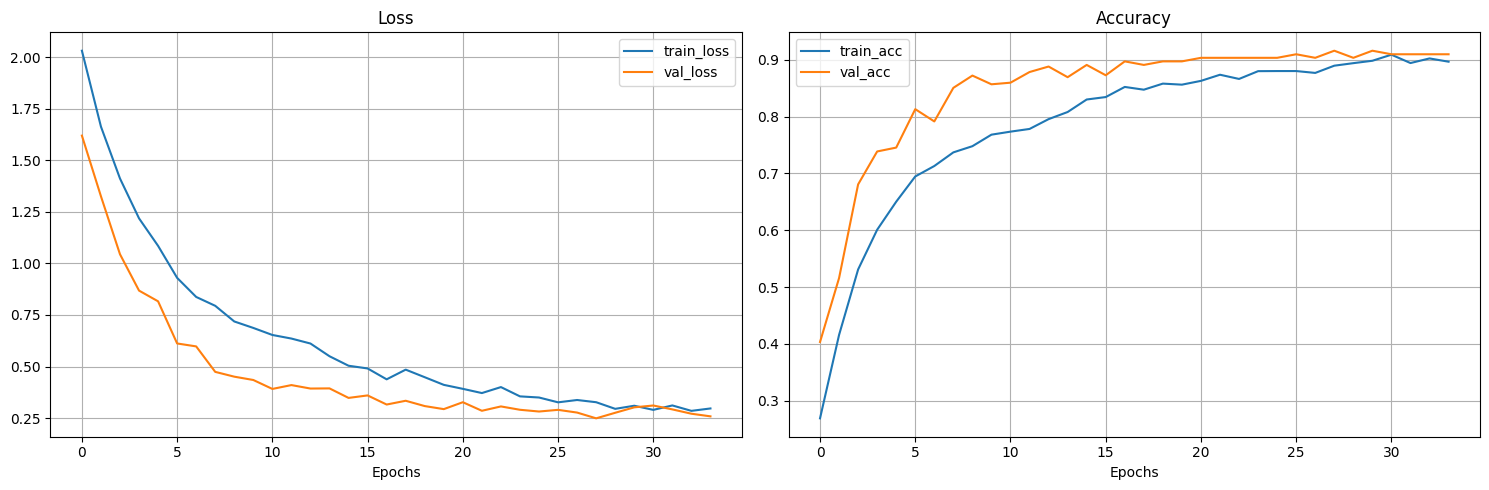

In [ ]:
# plot the curves of the model with best config
plot_loss_curves(model_1_results)

The learning curves show us the improvement made through experimentation. We started with the training loss significantly lower than the validation loss  and the training accuracy higher than the validation accuracy, indicating overfitting. By the end of experimentation process, the validation loss became very close to the training loss, and the validation accuracy surpassed the training accuracy, achieving our goal of reducing overfitting and improving generalization.

Now, let's evaluate ```model_1``` on unseen data (test set), save the results, and store the trained model for future use.

In [ ]:
# evaluate on test set/dataloader
model_1_test_results = eval_model(model=model_1,
                                  dataloader=test_dataloader_M,
                                  loss_fn=loss_fn)
model_1_test_results['test_acc']

  0%|          | 0/5 [00:00<?, ?it/s]

0.892663043478261

In [ ]:
# save the best model
torch.save(model_1.state_dict(), 'model_1_M.pth')
print("Model saved to 'model_1_M.pth'")

# save the results on test set
model_1_test_results_df = pd.DataFrame(model_1_test_results)
model_1_test_results_df.to_csv('model_1_test_results_df.csv', index=False)
print("Results saved to 'model_1_test_results_df.csv'")

Model saved to 'model_1_M.pth'
Results saved to 'model_1_test_results_df.csv'


We got a very descent test accuracy, very close to validation one. Let's dive deeper into the results by analyzing them with some useful ```metrics``` ([torchmetrics](https://torchmetrics.readthedocs.io/en/v0.9.3/all-metrics.html)) for a more comprehensive evaluation.

To do this, we first retrieve actual and predicted label tensors.

In [ ]:
# retrieve actual and predicted labels and convert them to tensors for later process
model_1_y_true = torch.tensor(model_1_test_results['y_true'])
model_1_y_pred = torch.tensor(model_1_test_results['y_preds'])

# check if they are in the same length (151 expected)
print(len(model_1_y_true))
print(len(model_1_y_pred))

# check if they are in the same form
print(model_1_y_true[:10])
print(model_1_y_pred[:10])

151
151
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

We start by calculating and plotting the ```confusion matrix```. It is a summary of the classification results, showing the number of correct and incorrect predictions for each class. This provides valuable insight into how well the model performs across different classes and highlights any specific areas of misclassification.

In [ ]:
# setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(test_data_M.classes), task='multiclass')
confmat_tensor = confmat(model_1_y_pred.clone().detach(), model_1_y_true.clone().detach())

# see how it looks like
print("Confusion Matrix:")
print(confmat_tensor)

Confusion Matrix:
tensor([[15,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0],
        [ 0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  0,  4,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0, 12,  0,  0,  0,  0,  2,  0],
        [ 0,  0,  0,  0,  1, 13,  0,  0,  0,  0,  0],
        [ 4,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, 23,  0,  0],
        [ 1,  0,  0,  0,  0,  1,  0,  1,  0, 12,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 17]])


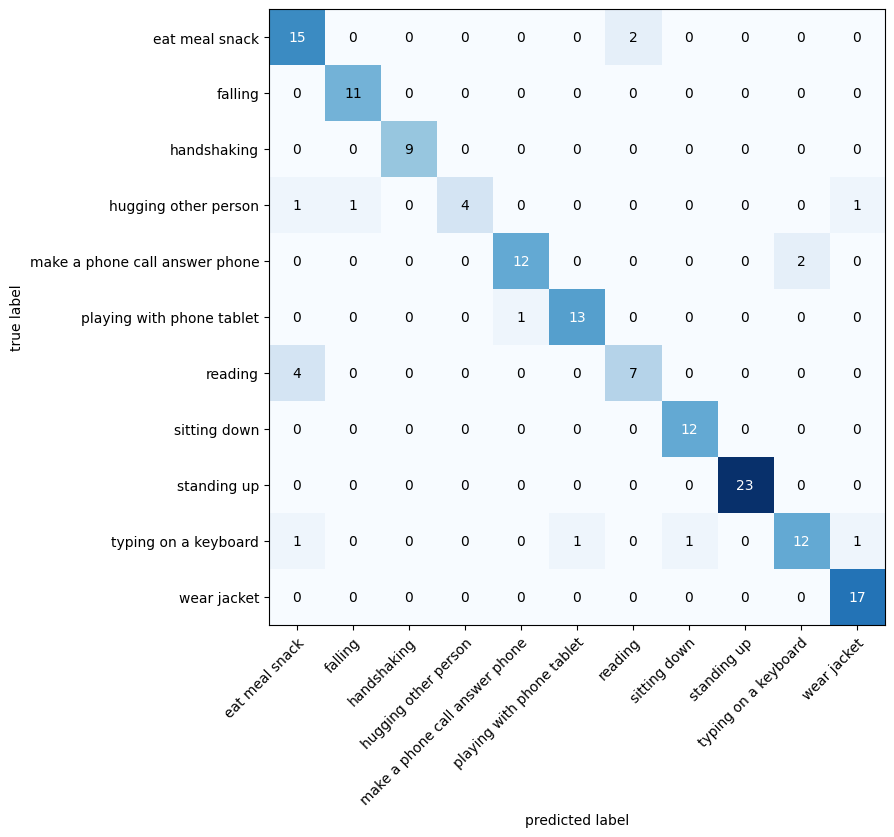

In [ ]:
# plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=test_data_M.classes, figsize=(20,8)); # matplotlib likes working with NumPy!

The confusion matrix shows that most predictions were correct, with the majority of true labels aligning with predicted labels. However, there are a few misclassifications, particularly between similar activities, such as "reading" and "eat meal/snack." These indicate areas where the model could potentially be improved. Overall, the results demonstrate strong performance.

[Precision, recall, and F1-score](https://futuremachinelearning.org/differences-between-precision-recall-and-f1-score/) are key evaluation metrics for classification tasks. ```Precision``` measures the proportion of correctly predicted instances out of all predicted instances, showing how accurate the predictions are. ```Recall``` measures the proportion of correctly predicted instances out of all actual instances, indicating the model's ability to detect all relevant cases. ```F1-score``` is the harmonic mean of precision and recall, balancing both metrics and providing a single measure of performance. These metrics can be calculated directly from the confusion matrix or by using libraries like ```torchmetrics``` for convenience.

In [ ]:
# calculate precision, recall and F1 scores using torchmetrics
#accuracy = Accuracy(average='macro', num_classes=len(test_data_M.classes), task='multiclass')
precision = Precision(average='macro', num_classes=len(test_data_M.classes), task='multiclass')
recall = Recall(average='macro', num_classes=len(test_data_M.classes), task='multiclass')
f1 = F1Score(average='macro', num_classes=len(test_data_M.classes), task='multiclass')

#acc = accuracy(model_1_y_pred, model_1_y_true)
prec = precision(model_1_y_pred, model_1_y_true)
rec = recall(model_1_y_pred, model_1_y_true)
f1_score = f1(model_1_y_pred, model_1_y_true)

# calculate precision, recall and F1 scores directly from confusion matrix
#conf_accuracy = torch.sum(torch.diag(confmat_tensor)) / torch.sum(confmat_tensor)
#conf_precision = torch.diag(confmat_tensor) / torch.sum(confmat_tensor, dim=1) # TP / total predictions dim=1 (TP + FP)
#conf_recall = torch.diag(confmat_tensor) / torch.sum(confmat_tensor, dim=0) # TP / total actual trues dim=0 (TP + FN)
#conf_f1 = 2 * (conf_precision_per_class * conf_recall_per_class) / (conf_precision_per_class + conf_recall_per_class)

# print the results
print(f"Precision: {prec:.4f}\nRecall: {rec:.4f}\nF1-Score: {f1_score:.4f}") # Accuracy: {acc:.4f}\n

Precision: 0.9032
Recall: 0.8751
F1-Score: 0.8814


The metrics indicate strong overall performance, with precision, recall, and F1-score showing similar values. Precision reflects the model's ability to minimize false positives, while recall measures its effectiveness in identifying true positives. The F1-score balances both, ensuring consistency across classes. The slightly higher precision compared to recall suggests that the model makes fewer false positive predictions, indicating it is more selective in its predictions and prioritizes precision over recall (we prefer higher recall when missing a true case is costly, such as in medical diagnosis and higher precision when false positives have serious consequences, like in spam detection).

Another valuable evaluation tool is the [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which provides a detailed summary of the above metrics (precision, recall, F1-score) for each class in a table form.

In [ ]:
# classification report
print("Classification Report:")
print(classification_report(y_true=model_1_y_true, y_pred=model_1_y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        17
           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00         9
           3       1.00      0.57      0.73         7
           4       0.92      0.86      0.89        14
           5       0.93      0.93      0.93        14
           6       0.78      0.64      0.70        11
           7       0.92      1.00      0.96        12
           8       1.00      1.00      1.00        23
           9       0.86      0.75      0.80        16
          10       0.89      1.00      0.94        17

    accuracy                           0.89       151
   macro avg       0.90      0.88      0.88       151
weighted avg       0.90      0.89      0.89       151



Support refers to the number of true instances for each class, which influences the metrics. The macro average reflects the unweighted mean of the metrics, treating all classes equally, while the weighted average considers the number of samples in each class, giving more importance to classes with more data.

With a very good overall accuracy, the model demonstrates strong performance. However, some classes with lower support, such as class 2 (handshaking) and class 3 (hugging another person), highlight areas for improvement. This is the key advantage of using the classification report, which helps identify weaker classes, particularly those with fewer samples, allowing for targeted next steps to improve performance in these areas.

## 4. Experimenting with Cross-Validation.

After training the model with the best configuration, we evaluated it using a specific validation set. But what if the dataset split changes? With [cross-validation](https://www.geeksforgeeks.org/cross-validation-machine-learning/), we can re-evaluate the model's performance across different subsets, hoping to achieve even better results. To do ```cross validation```, we combine the training and validation datasets into one dataset. We will use the best pre-trained weights to integrate prior knowledge from the best-performing model, ensuring an optimal starting point for evaluation. Finally, we test the model on the untouched test set to measure its true generalization performance.

In [ ]:
# combine train and validation sets

# define paths
source_dirs = ['/content/Datasets/PKU_X/ResActionsImagesM/train', '/content/Datasets/PKU_X/ResActionsImagesM/validation']
destination_dir = '/content/Datasets/PKU_X/ResActionsImagesM/train_val_combined'

# create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
  os.makedirs(destination_dir)

# loop over all source dirs (train, validation) in ResActionsImagesM
for source_dir in source_dirs:
  # loop over all class dirs
  for class_dir in os.listdir(source_dir):

    # existing class path, we will use it for copying
    class_path = os.path.join(source_dir, class_dir)

    # create class dir in destination dir if doesn't exist (this goes in case of multiple runs)
    dest_class_path = os.path.join(destination_dir, class_dir)
    if not os.path.exists(dest_class_path):
      os.makedirs(dest_class_path)

    # copy all files (images) from the current class of the current source
    for file in os.listdir(class_path):
      shutil.copy(os.path.join(class_path, file), os.path.join(dest_class_path, file))

# check how many dirs in the new dir (expected num_classes=11)
print(f"Total number of folders of the new dir: {len(os.listdir(destination_dir))}")

# find and print how many images in total the new 'train_val_combined' dir has (expected the sum of initial train and validation dirs: 1201 + 150 = 1351)
train_val_total_images = 0
for class_dir in os.listdir(destination_dir):
  class_path = os.path.join(destination_dir, class_dir)
  train_val_total_images += len(os.listdir(class_path))
print(f"Total number of images of the new dir: {train_val_total_images}") # check on the left side of Colab

Total number of folders of the new dir: 11
Total number of images of the new dir: 1351


And now, as usual, with the new data folder ready, we construct a dataset using ```ImageFolder```, just as we did before. The difference here is that we create new dataloaders for each different split of the folds. We will start with 6-fold cross-validation, but the number of folds is something we can experiment with to find the best balance. This means we will train the model as many times as the number of folds, and in the end, we will keep the model parameters/weights from the fold that achieved the best performance (obviously, we use the best found configuration found above).

In [ ]:
# create the new dataset using ImageFolder
cross_val_dataset = ImageFolder(root=destination_dir, transform=data_transform_M) # use of the same transform as above

In [ ]:
# cross validation function
def cross_validation(dataset, num_folds, best_config, best_weights):
  """ Applies cross-validation to a given dataset and model. """

  # unpack the  dictionary
  best_batch_size = best_config['best_batch_size']
  best_hidden_units_combo = best_config['best_hidden_units_combo']
  best_dropout_probs_combo = best_config['best_dropout_probs_combo']
  best_optimizer = best_config['best_optimizer']
  best_learning_rate = best_config['best_learning_rate']
  best_activation_functions = best_config['best_activation_functions']
  best_decay_value = best_config['best_decay_value']
  loss_fn = best_config['loss_fn']
  epochs = best_config['epochs']

  # storage dictionary for the results
  cross_valid_results = {}

  # initialize lists to store results per fold split
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  # shuffle the dataset to ensure fairness
  indices = list(range(len(dataset)))
  random.shuffle(indices)

  # split the dataset into folds
  fold_size = len(dataset) // num_folds
  remainders = len(dataset) % num_folds # handle what remains
  print(f"Dataset size: {len(dataset)}")
  print(f"Number of folds: {num_folds}")
  print(f"Fold size: {fold_size}")

  # loop over the folds
  print("\nCross-Validation training ...")
  for fold in range(num_folds):
    print(f"\nFold {fold + 1}/{num_folds}")

    # define fold size, train and val sizes
    start_idx, end_idx = fold * fold_size, (fold + 1) * fold_size + remainders
    val_indices = indices[start_idx:end_idx]
    train_indices = [i for i in indices if i not in val_indices] # equivalent to: indices[:start_idx] + indices[end_idx:]

    # create subsets based on train and val indices, use of torch Subset
    train_subset = torch.utils.data.Subset(dataset, train_indices)
    val_subset = torch.utils.data.Subset(dataset, val_indices)

    # create the dataloaders for the current fold
    train_dataloader = DataLoader(train_subset, batch_size=best_batch_size, shuffle=True, num_workers=num_workers)
    val_dataloader = DataLoader(val_subset, batch_size=best_batch_size, shuffle=False, num_workers=num_workers)

    # initialize the model for the current fold
    model = CNN_v2(hidden_units=best_hidden_units_combo, dropout_probs=best_dropout_probs_combo, activation_functions=best_activation_functions).to(device)

    # starting training state of the current fold-model will be the best training output state of model_1 (weights = prior knowledge)
    model.load_state_dict(best_weights)

    # set loss function and optimizer
    loss_fn = loss_fn # ensure it, even it is already defined when unpacking the dictionary
    optimizer = best_optimizer(params=model.parameters(), lr=best_learning_rate, weight_decay=best_decay_value) # included pretrained weights/prior knowledge for the current fold-training

    # start training
    start_time = time.time()
    model_results = train(model=model,
                          train_dataloader=train_dataloader,
                          test_dataloader=val_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=epochs)
    end_time = time.time()

    # calcuate training time
    training_time = end_time - start_time
    model_results['training_time'] = training_time

    # calculate trainable params
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_results['trainable_params'] = trainable_params

    # save model's weights and store them in the dictionary
    model_weights = model.state_dict()
    model_results['model_weights'] = model_weights

    # save the results for the current fold
    cross_valid_results[fold] = model_results

    # print the validation accuracy for the current fold
    print(f"Validation accuracy: {model_results['val_acc'][-1]:.4f}\n")

  # return the results dictionary (of length of number of folds) after completing the whole proccess
  return cross_valid_results

In [ ]:
# define the number of folds
num_folds = 6 # almost 16% fold size (= validation set, instead of 10% we had in earlier experiments)

# retrieve best pre-trained weights from model_1
model_1_weights = model_1.state_dict()

In [ ]:
# apply cross validation
cross_valid_results = cross_validation(dataset=cross_val_dataset, num_folds=num_folds, best_config=best_config, best_weights=model_1_weights)

Dataset size: 1351
Number of folds: 6
Fold size: 225

Cross-Validation training ...

Fold 1/6


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2680 | train_acc: 0.9158 | val_loss: 0.0850 | val_acc: 0.9727
Epoch: 2 | train_loss: 0.2959 | train_acc: 0.8977 | val_loss: 0.0795 | val_acc: 0.9766
Epoch: 3 | train_loss: 0.2670 | train_acc: 0.9036 | val_loss: 0.0994 | val_acc: 0.9727
Epoch: 4 | train_loss: 0.2659 | train_acc: 0.9149 | val_loss: 0.1073 | val_acc: 0.9766
Epoch: 5 | train_loss: 0.2464 | train_acc: 0.9115 | val_loss: 0.1025 | val_acc: 0.9688
Epoch: 6 | train_loss: 0.2458 | train_acc: 0.9097 | val_loss: 0.1213 | val_acc: 0.9727
Epoch: 7 | train_loss: 0.2461 | train_acc: 0.9163 | val_loss: 0.0991 | val_acc: 0.9727
Epoch: 8 | train_loss: 0.2569 | train_acc: 0.9167 | val_loss: 0.1106 | val_acc: 0.9727
Epoch: 9 | train_loss: 0.2346 | train_acc: 0.9184 | val_loss: 0.1145 | val_acc: 0.9609
Epoch: 10 | train_loss: 0.2083 | train_acc: 0.9332 | val_loss: 0.1088 | val_acc: 0.9766
Epoch: 11 | train_loss: 0.2294 | train_acc: 0.9259 | val_loss: 0.1171 | val_acc: 0.9570
Epoch: 12 | train_loss: 0.2331 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2941 | train_acc: 0.9050 | val_loss: 0.1010 | val_acc: 0.9688
Epoch: 2 | train_loss: 0.2928 | train_acc: 0.9045 | val_loss: 0.1429 | val_acc: 0.9531
Epoch: 3 | train_loss: 0.2596 | train_acc: 0.9085 | val_loss: 0.1093 | val_acc: 0.9766
Epoch: 4 | train_loss: 0.2359 | train_acc: 0.9207 | val_loss: 0.1432 | val_acc: 0.9609
Epoch: 5 | train_loss: 0.2377 | train_acc: 0.9155 | val_loss: 0.1615 | val_acc: 0.9492
Epoch: 6 | train_loss: 0.2997 | train_acc: 0.8986 | val_loss: 0.1515 | val_acc: 0.9453
Epoch: 7 | train_loss: 0.2658 | train_acc: 0.9068 | val_loss: 0.1535 | val_acc: 0.9492
Epoch: 8 | train_loss: 0.2308 | train_acc: 0.9201 | val_loss: 0.1528 | val_acc: 0.9492
Epoch: 9 | train_loss: 0.1991 | train_acc: 0.9384 | val_loss: 0.1533 | val_acc: 0.9531
Epoch: 10 | train_loss: 0.2169 | train_acc: 0.9332 | val_loss: 0.1670 | val_acc: 0.9414
Epoch: 11 | train_loss: 0.1778 | train_acc: 0.9406 | val_loss: 0.1510 | val_acc: 0.9492
Epoch: 12 | train_loss: 0.2070 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3315 | train_acc: 0.8943 | val_loss: 0.1412 | val_acc: 0.9570
Epoch: 2 | train_loss: 0.2737 | train_acc: 0.9149 | val_loss: 0.1340 | val_acc: 0.9492
Epoch: 3 | train_loss: 0.2735 | train_acc: 0.9115 | val_loss: 0.1597 | val_acc: 0.9492
Epoch: 4 | train_loss: 0.2540 | train_acc: 0.9189 | val_loss: 0.1302 | val_acc: 0.9570
Epoch: 5 | train_loss: 0.2209 | train_acc: 0.9280 | val_loss: 0.1577 | val_acc: 0.9570
Epoch: 6 | train_loss: 0.2519 | train_acc: 0.9146 | val_loss: 0.1827 | val_acc: 0.9414
Epoch: 7 | train_loss: 0.2272 | train_acc: 0.9332 | val_loss: 0.1526 | val_acc: 0.9531
Epoch: 8 | train_loss: 0.2212 | train_acc: 0.9181 | val_loss: 0.1413 | val_acc: 0.9414
Epoch: 9 | train_loss: 0.2287 | train_acc: 0.9163 | val_loss: 0.1590 | val_acc: 0.9375
Epoch: 10 | train_loss: 0.2345 | train_acc: 0.9215 | val_loss: 0.1449 | val_acc: 0.9609
Epoch: 11 | train_loss: 0.1924 | train_acc: 0.9384 | val_loss: 0.1334 | val_acc: 0.9570
Epoch: 12 | train_loss: 0.2167 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2767 | train_acc: 0.9123 | val_loss: 0.0806 | val_acc: 0.9805
Epoch: 2 | train_loss: 0.2534 | train_acc: 0.9149 | val_loss: 0.0904 | val_acc: 0.9805
Epoch: 3 | train_loss: 0.2806 | train_acc: 0.9141 | val_loss: 0.0822 | val_acc: 0.9844
Epoch: 4 | train_loss: 0.2855 | train_acc: 0.9024 | val_loss: 0.1174 | val_acc: 0.9766
Epoch: 5 | train_loss: 0.2564 | train_acc: 0.9236 | val_loss: 0.1284 | val_acc: 0.9648
Epoch: 6 | train_loss: 0.2630 | train_acc: 0.9080 | val_loss: 0.0942 | val_acc: 0.9805
Epoch: 7 | train_loss: 0.2507 | train_acc: 0.9167 | val_loss: 0.0952 | val_acc: 0.9766
Epoch: 8 | train_loss: 0.2331 | train_acc: 0.9210 | val_loss: 0.0978 | val_acc: 0.9766
Epoch: 9 | train_loss: 0.2339 | train_acc: 0.9085 | val_loss: 0.1205 | val_acc: 0.9609
Epoch: 10 | train_loss: 0.2289 | train_acc: 0.9280 | val_loss: 0.1079 | val_acc: 0.9805
Epoch: 11 | train_loss: 0.2034 | train_acc: 0.9288 | val_loss: 0.1162 | val_acc: 0.9648
Epoch: 12 | train_loss: 0.2258 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2759 | train_acc: 0.9042 | val_loss: 0.1394 | val_acc: 0.9648
Epoch: 2 | train_loss: 0.2892 | train_acc: 0.9007 | val_loss: 0.1550 | val_acc: 0.9648
Epoch: 3 | train_loss: 0.2775 | train_acc: 0.9123 | val_loss: 0.1423 | val_acc: 0.9688
Epoch: 4 | train_loss: 0.2685 | train_acc: 0.9059 | val_loss: 0.1602 | val_acc: 0.9492
Epoch: 5 | train_loss: 0.2502 | train_acc: 0.9106 | val_loss: 0.1303 | val_acc: 0.9648
Epoch: 6 | train_loss: 0.2686 | train_acc: 0.9181 | val_loss: 0.1562 | val_acc: 0.9570
Epoch: 7 | train_loss: 0.2201 | train_acc: 0.9210 | val_loss: 0.1300 | val_acc: 0.9531
Epoch: 8 | train_loss: 0.2265 | train_acc: 0.9236 | val_loss: 0.1573 | val_acc: 0.9531
Epoch: 9 | train_loss: 0.2056 | train_acc: 0.9280 | val_loss: 0.1427 | val_acc: 0.9570
Epoch: 10 | train_loss: 0.1961 | train_acc: 0.9410 | val_loss: 0.1484 | val_acc: 0.9570
Epoch: 11 | train_loss: 0.1962 | train_acc: 0.9366 | val_loss: 0.1543 | val_acc: 0.9531
Epoch: 12 | train_loss: 0.2267 | train_ac

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2926 | train_acc: 0.9132 | val_loss: 0.0837 | val_acc: 0.9648
Epoch: 2 | train_loss: 0.2834 | train_acc: 0.9068 | val_loss: 0.0863 | val_acc: 0.9688
Epoch: 3 | train_loss: 0.2793 | train_acc: 0.8993 | val_loss: 0.0900 | val_acc: 0.9766
Epoch: 4 | train_loss: 0.2988 | train_acc: 0.8964 | val_loss: 0.1653 | val_acc: 0.9570
Epoch: 5 | train_loss: 0.3017 | train_acc: 0.9059 | val_loss: 0.1391 | val_acc: 0.9453
Epoch: 6 | train_loss: 0.2400 | train_acc: 0.9201 | val_loss: 0.1205 | val_acc: 0.9492
Epoch: 7 | train_loss: 0.2570 | train_acc: 0.9132 | val_loss: 0.1161 | val_acc: 0.9570
Epoch: 8 | train_loss: 0.2165 | train_acc: 0.9288 | val_loss: 0.1052 | val_acc: 0.9609
Epoch: 9 | train_loss: 0.2163 | train_acc: 0.9207 | val_loss: 0.1072 | val_acc: 0.9648
Epoch: 10 | train_loss: 0.2205 | train_acc: 0.9238 | val_loss: 0.1009 | val_acc: 0.9531
Epoch: 11 | train_loss: 0.2434 | train_acc: 0.9210 | val_loss: 0.1109 | val_acc: 0.9688
Epoch: 12 | train_loss: 0.1943 | train_ac

It is worth noting that during the training of the folds, the initial accuracy is quite high. This is because we leverage the prior knowledge from the previously best-performing model (model_1) as the starting point. There are also cases where the training accuracy exceeds the validation accuracy, indicating of overfitting. We carefully consider this when making our final model selection.

In [ ]:
# retrieve all val accuracies in desc order from results dictionary alomg with their corresponding model's weights
results_list = []
for fold, results in cross_valid_results.items():
  val_acc = results['val_acc'][-1]
  model_weights = results['model_weights']
  results_list.append({'Fold': fold + 1, 'Validation Accuracy': val_acc, 'Model Weights': model_weights})
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='Validation Accuracy', ascending=False)
print(results_df)

   Fold  Validation Accuracy  \
3     4             0.968750   
0     1             0.957031   
5     6             0.953125   
4     5             0.941406   
1     2             0.937500   
2     3             0.929688   

                                       Model Weights  
3  {'block1.0.weight': [[tensor([[ 0.1537,  0.179...  
0  {'block1.0.weight': [[tensor([[ 0.1412,  0.159...  
5  {'block1.0.weight': [[tensor([[ 0.1479,  0.163...  
4  {'block1.0.weight': [[tensor([[ 0.1788,  0.191...  
1  {'block1.0.weight': [[tensor([[ 0.1551,  0.146...  
2  {'block1.0.weight': [[tensor([[ 0.1698,  0.167...  


We retrieve the best-performing model's weights from fold 4 (notice that we do not have any overfitting). Cross-validation is often a crucial step during grid search for identifying optimal hyperparameters, and a common strategy afterwards is to retrain the model on the entire dataset to maximize its exposure to all available data. In our case, retraining is unnecessary. However, for our curiosity, we run a few additional epochs with early stopping to verify that any further training does not yield any meaningful improvements and is not required at all. Early stopping will help us uncover earlier overfitting by stopping training when the validation performance stops improving.

In [ ]:
# retrieve model weights for the best val accuracy
best_model_weights = results_df.iloc[0]['Model Weights']
#print(best_model_weights)

In [ ]:
# retrain on the entire dataset
print("Retraining on the entire dataset ...")

# create a new dataloader that consist of train and val sets
train_val_dataloader = DataLoader(cross_val_dataset, batch_size=best_batch_size, shuffle=True, num_workers=num_workers)

# create the final model
model_2 = CNN_v2(hidden_units=best_hidden_units_combo, dropout_probs=best_dropout_probs_combo, activation_functions=best_activation_functions).to(device)

# load the best model's weights found from cross validation process to the created final cross validation model_2
model_2.load_state_dict(best_model_weights)

# set loss function and optimizer
loss_fn = loss_fn
optimizer = best_optimizer(params=model_2.parameters(), lr=best_learning_rate, weight_decay=best_decay_value)

# retrain on the entire dataset
start_time = time.time()
model_2_results = train(model=model_2,
                        train_dataloader=train_val_dataloader,
                        test_dataloader=test_dataloader_M,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=num_epochs,
                        early_stopping=True, # enable early stopping
                        patience=5, # epochs to wait
                        delta=0.025) # minimum improvement
end_time = time.time()

# calculate and print total training time
model_2_training_time = end_time - start_time
print(f"\nTotal training time: {model_2_training_time:.3f} seconds")

# calculate and print total trainable params
model_2_total_params = sum(p.numel() for p in model_2.parameters() if p.requires_grad)
print(f"Total trainable params: {model_2_total_params}")

  0%|          | 0/34 [00:00<?, ?it/s]

Retraining on the entire dataset ...
Epoch: 1 | train_loss: 0.1945 | train_acc: 0.9368 | val_loss: 0.3903 | val_acc: 0.9076
Epoch: 2 | train_loss: 0.1944 | train_acc: 0.9360 | val_loss: 0.3366 | val_acc: 0.9264
Epoch: 3 | train_loss: 0.1924 | train_acc: 0.9382 | val_loss: 0.3321 | val_acc: 0.9264
Epoch: 4 | train_loss: 0.1389 | train_acc: 0.9571 | val_loss: 0.3464 | val_acc: 0.9014
Epoch: 5 | train_loss: 0.1809 | train_acc: 0.9378 | val_loss: 0.2847 | val_acc: 0.9076
Epoch: 6 | train_loss: 0.2056 | train_acc: 0.9419 | val_loss: 0.3192 | val_acc: 0.9076
Epoch: 7 | train_loss: 0.1455 | train_acc: 0.9520 | val_loss: 0.4161 | val_acc: 0.9052
Epoch: 8 | train_loss: 0.1586 | train_acc: 0.9448 | val_loss: 0.3169 | val_acc: 0.9014
Epoch: 9 | train_loss: 0.1796 | train_acc: 0.9465 | val_loss: 0.3458 | val_acc: 0.8913
Epoch: 10 | train_loss: 0.1810 | train_acc: 0.9397 | val_loss: 0.3097 | val_acc: 0.8951
Early stopping triggered at epoch 10.
Model restored from epoch 5.

Total training time: 940

As is expected, overfitting was presented throughout the whole training and proved our initial claim. This happens because, during retraining, the model is exposed to all the data, including data which was previously used for validation, so the model lost the ability to evaluate its generalization to unseen data. In our case, we observe this effect as the validation accuracy fluctuates without consistent improvement, and the training accuracy continues to rise steadily and above validation accuracy.

To conclude, during cross-validation, we achieve the best performance with the model from fold 4. Model 2 is essentially an extension of model 1, using the same hyperparameters but trained on a different validation set of a slightly larger size (16% compared to the 10% used for model 1 for 6 folds). The training process for model 2 starts with the output (weights) of model 1 as its initial point. Of course, various experiments can be conducted to explore the impact of different numbers of folds in cross-validation.

In [ ]:
# retrieve fold's 2 results
model_2_results = cross_valid_results[3] # fold 4 is at position 3 of the cross validation resulting dictionary

In [ ]:
# remove model_weights from results dictionary
if 'model_weights' in model_2_results:
  del model_2_results['model_weights']

# convert dictionary to DataFrame
model_2_results_df = pd.DataFrame([model_2_results])  # Ensure it's a single-row DataFrame

# save to csv
model_2_results_df.to_csv('model_2_results_df.csv', index=False)
print("Results saved to 'model_2_results_df.csv'")

Results saved to 'model_2_results_df.csv'


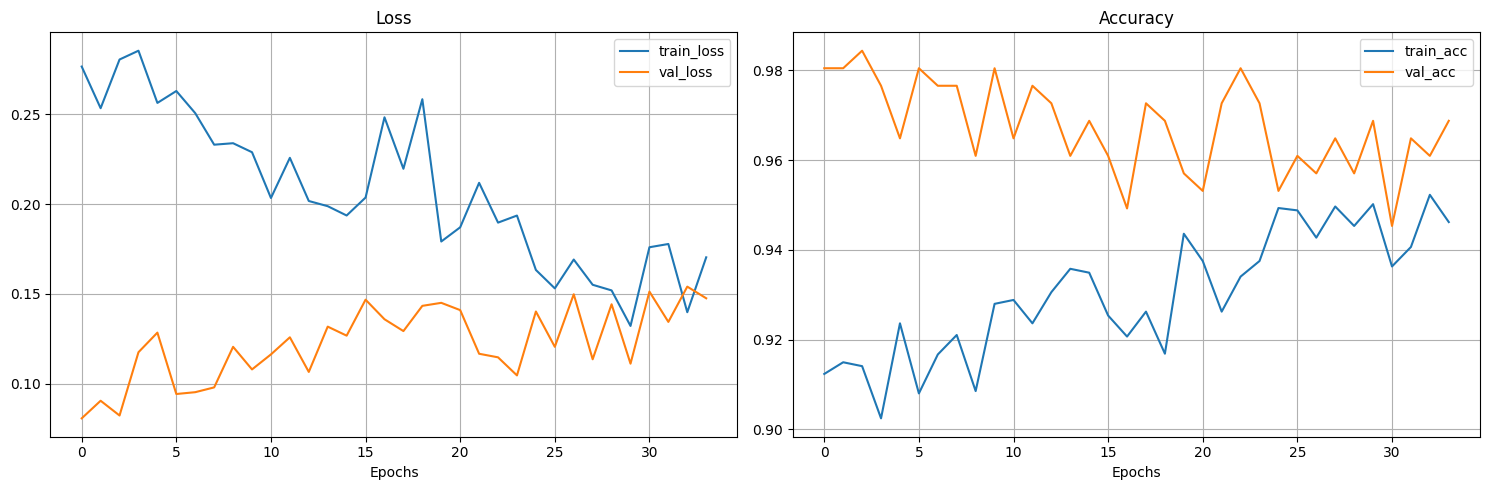

In [ ]:
# plot the curves of the model with best config
plot_loss_curves(model_2_results)

The loss curves for both training and validation remain close, indicating consistent learning without significant differences between the two like in model 1 case. Similarly, the validation accuracy most of the time stays above the training accuracy, which is an encouraging sign as it reflects the model's ability to generalize well to unseen data (and of course without overfitting). While the validation curves show some fluctuations, these are likely due to small validation dataset size, or data distribution differences. In the next, final experiment, in which we will try to balance the dataset, these fluctuations might disappear.

In [ ]:
# ensure model 2 is best fold's performance model
model_2.load_state_dict(best_model_weights)

# and evaluate on test set/dataloader
model_2_test_results = eval_model(model=model_2,
                                  dataloader=test_dataloader_M,
                                  loss_fn=best_config['loss_fn'])
model_2_test_results['test_acc']

  0%|          | 0/5 [00:00<?, ?it/s]

0.9138586956521738

A higher test accuracy achieved by model 2 compared to model 1. Let's save the model and test results for later use and proceed to the final experiment.

In [ ]:
# save the model
torch.save(model_2.state_dict(), 'model_2_M.pth')
print("Model saved to 'model_2_M.pth'")

# save the results of test set on a csv
model_2_test_results_df = pd.DataFrame(model_2_test_results)
model_2_test_results_df.to_csv('model_2_test_results_df.csv', index=False)
print("Results saved to 'model_2_test_results_df.csv'")

Model saved to 'model_2_M.pth'
Results saved to 'model_2_test_results_df.csv'


## 5. Experimenting with Balanced Dataset and Data Augmentation.

In this final experiment, we will try to improve the performance by applying ```data augmentation```. In short, [data augmentation](https://www.ccslearningacademy.com/what-is-data-augmentation/) is a powerful technique used to improve model performance and generalization by artificially increasing the diversity of the training dataset. By applying transformations (we will use [Pytorch transforms](https://pytorch.org/vision/0.13/transforms.html)) such as rotations, flips, zooming, or color adjustments, data augmentation helps the model learn better by making it less sensitive to changes in input data. It is helpful (especially when we have small datasets), as it reduces overfitting and improves the model's ability to work well on new, unseen data. For the experiments, we will use the best model found until now (model 2). Apart from this, because we have already achieved a very high validation accuracy, we will introduce early stopping to prevent overfitting and ensure optimal model performance.

Before implementing data augmentation, we will first balance the dataset by pluging the ```class weights``` calculated earlier for each class into the ```loss_fn``` to see if this change bring any improvement.

In [ ]:
# 1. try to train on our initial but balanced dataset
print("Experiment with balanced dataset")

# create a new model
model_3_1 = CNN_v2(hidden_units=best_hidden_units_combo, dropout_probs=best_dropout_probs_combo, activation_functions=best_activation_functions).to(device)

# load weights of best found model until now
model_3_1.load_state_dict(model_2.state_dict()) # the one came from cross validaation

# set the loss function with class weights and optimizer
loss_fn = nn.CrossEntropyLoss(weight=class_weights_M)
optimizer = best_optimizer(params=model_3_1.parameters(), lr=best_learning_rate, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_3_1_results = train(model=model_3_1,
                          train_dataloader=train_dataloader_M,
                          test_dataloader=val_dataloader_M,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=num_epochs,
                          early_stopping=True, # enable early stopping
                          patience=5, # epochs to wait
                          delta=0.005) # min improvement
end_time = time.time()

# calculate and print total training time
model_3_1_training_time = end_time - start_time
print(f"\nTotal training time: {model_3_1_training_time:.3f} seconds")

# calculate and print total trainable params
model_3_1_total_params = sum(p.numel() for p in model_3_1.parameters() if p.requires_grad)
print("Total trainable params:", model_3_1_total_params)

Experiment with balanced dataset


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2819 | train_acc: 0.9174 | val_loss: 0.0930 | val_acc: 0.9784
Epoch: 2 | train_loss: 0.2136 | train_acc: 0.9392 | val_loss: 0.2370 | val_acc: 0.9693
Epoch: 3 | train_loss: 0.2201 | train_acc: 0.9317 | val_loss: 0.1020 | val_acc: 0.9722
Epoch: 4 | train_loss: 0.2087 | train_acc: 0.9394 | val_loss: 0.1448 | val_acc: 0.9818
Epoch: 5 | train_loss: 0.1916 | train_acc: 0.9475 | val_loss: 0.1491 | val_acc: 0.9784
Epoch: 6 | train_loss: 0.2081 | train_acc: 0.9392 | val_loss: 0.1033 | val_acc: 0.9847
Early stopping triggered at epoch 6.
Model restored from epoch 1.

Total training time: 8.199 seconds
Total trainable params: 180619


In [ ]:
# retrieve best epoch, print its val acc and save the weights of this state
best_epoch = model_3_1_results['best_epoch']
print(f"Best epoch: {best_epoch}")
best_val_acc = model_3_1_results['val_acc'][best_epoch]
print(f"Best validation accuracy: {best_val_acc}")
model_3_1_best_weights = model_3_1.state_dict()

Best epoch: 0
Best validation accuracy: 0.978409090909091


As we observe excellent validation accuracy results after balancing the dataset, which confirms the positive impact of a well-balanced class distribution. Once again, the high initial accuracies reflect the utilization of prior knowledge gained from the previous best-performing model (model 2).

In [ ]:
# save time and trainable params to the results
model_3_1_results['total_train_time'] = model_3_1_training_time
model_3_1_results['total_params'] = model_3_1_total_params

# put it in a table and save it
model_3_1_results_df = pd.DataFrame(model_3_1_results)
#print(model_3_1_results_df)
model_3_1_results_df.to_csv('model_3_1_results_df.csv', index=False)
print("Results saved to 'model_3_1_results_df.csv'")

Results saved to 'model_3_1_results_df.csv'


Now, let's explore if data augmentation can further improve these results on the balanced dataset. To implement this approach, we will first define a new transformation, then create an updated train dataset and dataloader, and finally train the model with these augmented dataset. This transformation includes random horizontal and vertical flips, rotations, and resized cropping, helping the model become more robust to different images while learning meaningful patterns. Additionally, we try TrivialAugmentWide, which applies a random augmentation to each image, further enhancing variability and improving generalization.

In [ ]:
# 2. try data augmentation
print("Experiment with data augmentation")

# 2.1 prepare the new train and val datasets

# create a new augmented transform
# augmented_transform_M = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5), # random horizontal flip
#     transforms.RandomVerticalFlip(p=0.2), # random vertical flip
#     transforms.RandomRotation(degrees=20), # random rotation +/- 30
#     transforms.RandomResizedCrop(size=(25, 129), scale=(0.8, 1.0)), # random cropping to (25, 129) with zoom-in 80% and 100% zoom out
#     transforms.ToTensor(),  # convert images to tensors
#     transforms.Normalize(mean=mean_M, std=std_M)  # normalize to mean 0 and std 1
# ])

# create another augmented transform
augmented_transform_M = transforms.Compose([
    #transforms.RandomResizedCrop(size=(25, 129), scale=(0.8, 1.0)),
    transforms.TrivialAugmentWide(),  # automatically applies a random augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_M, std=std_M)
])

# create new train dataset using the augmented_tranform_M, no need to change val_data_M and test_data_M
train_aug_data_M = ImageFolder(root=train_M_dir, transform=augmented_transform_M)

# verify the datasets
print(f"Number of training samples: {len(train_aug_data_M)}")
print(f"Number of test samples: {len(test_data_M)}")
print(f"Class names: {train_aug_data_M.classes}")
print(f"\nTrain data:\n{train_aug_data_M}\nValidation data:\n{val_data_M}\nTest data:\n{test_data_M}")

# create new train dataLoader
train_aug_dataloader_M = DataLoader(dataset=train_aug_data_M, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Experiment with data augmentation
Number of training samples: 1201
Number of test samples: 151
Class names: ['eat meal snack', 'falling', 'handshaking', 'hugging other person', 'make a phone call answer phone', 'playing with phone tablet', 'reading', 'sitting down', 'standing up', 'typing on a keyboard', 'wear jacket']

Train data:
Dataset ImageFolder
    Number of datapoints: 1201
    Root location: /content/Datasets/PKU_X/ResActionsImagesM/train
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
               Normalize(mean=[0.664, 0.663, 0.663], std=[0.055, 0.054, 0.053])
           )
Validation data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: /content/Datasets/PKU_X/ResActionsImagesM/validation
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.664, 0.663, 0.663], std=[0.055, 0.054,

In [ ]:
# 2.2 train the model on the new augmented dataset

# create a new model
model_3_2 = CNN_v2(hidden_units=best_hidden_units_combo, dropout_probs=best_dropout_probs_combo, activation_functions=best_activation_functions).to(device)

# load best performing model to start training with the best prior knowledge found until now
model_3_2.load_state_dict(model_3_1_best_weights) # the one came from the balanced dataset

# set loss function and optimizer
loss_fn = nn.CrossEntropyLoss(weight=class_weights_M) # of course, we use the same loss function as in the above experiment
optimizer = best_optimizer(params=model_3_2.parameters(), lr=best_learning_rate, weight_decay=best_decay_value)

# start training
start_time = time.time()
model_3_2_results = train(model=model_3_2,
                          train_dataloader=train_aug_dataloader_M, # use the new augmented train dataloader
                          test_dataloader=val_dataloader_M, # validate on the same val dataloader
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=num_epochs,
                          early_stopping=True, # enable early stopping
                          patience=5, # epochs to wait
                          delta=0.005) # min improvement
end_time = time.time()

# calculate and print total training time
model_3_2_training_time = end_time - start_time
print(f"\nTotal training time: {model_3_2_training_time:.3f} seconds")

# calculate and print total trainable params
model_3_2_total_params = sum(p.numel() for p in model_3_2.parameters() if p.requires_grad)
print(f"Total trainable params: {model_3_2_total_params}")

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.0880 | train_acc: 0.5030 | val_loss: 0.2611 | val_acc: 0.9324
Epoch: 2 | train_loss: 1.7032 | train_acc: 0.4905 | val_loss: 0.2696 | val_acc: 0.9631
Epoch: 3 | train_loss: 1.6216 | train_acc: 0.5066 | val_loss: 0.2800 | val_acc: 0.9477
Epoch: 4 | train_loss: 1.5236 | train_acc: 0.5319 | val_loss: 0.2465 | val_acc: 0.9443
Epoch: 5 | train_loss: 1.4657 | train_acc: 0.5335 | val_loss: 0.2284 | val_acc: 0.9443
Epoch: 6 | train_loss: 1.3930 | train_acc: 0.5630 | val_loss: 0.2058 | val_acc: 0.9631
Epoch: 7 | train_loss: 1.4548 | train_acc: 0.5294 | val_loss: 0.2312 | val_acc: 0.9443
Epoch: 8 | train_loss: 1.3560 | train_acc: 0.5515 | val_loss: 0.1925 | val_acc: 0.9756
Epoch: 9 | train_loss: 1.3816 | train_acc: 0.5632 | val_loss: 0.1901 | val_acc: 0.9756
Epoch: 10 | train_loss: 1.3418 | train_acc: 0.5573 | val_loss: 0.2112 | val_acc: 0.9631
Epoch: 11 | train_loss: 1.3917 | train_acc: 0.5505 | val_loss: 0.1991 | val_acc: 0.9631
Epoch: 12 | train_loss: 1.3893 | train_ac

In [ ]:
# retrieve best epoch, print its val acc and save the weights of this state
best_epoch = model_3_2_results['best_epoch']
print(f"Best epoch: {best_epoch}")
best_val_acc = model_3_2_results['val_acc'][best_epoch]
print(f"Best validation accuracy: {best_val_acc}")
model_3_2_best_weights = model_3_2.state_dict()

Best epoch: 7
Best validation accuracy: 0.9755681818181818


With data augmentation, we got almost the same validation accuracy with the one of the balanced dataset. As a result, we select this model as our final version of model 3 and proceed to evaluate it on the test dataset.

In [ ]:
# add to the results dictionary total training time and params
model_3_results = model_3_2_results
model_3_results['total_train_time'] = model_3_2_training_time
model_3_results['total_params'] = model_3_2_total_params

# save the results dictionary to csv
model_3_results_df = pd.DataFrame(model_3_results)
#print(final_model_1_results_df)
model_3_results_df.to_csv('model_3_results_df.csv', index=False)
print("Results saved to 'model_3_results_df.csv'")

Results saved to 'model_3_results_df.csv'


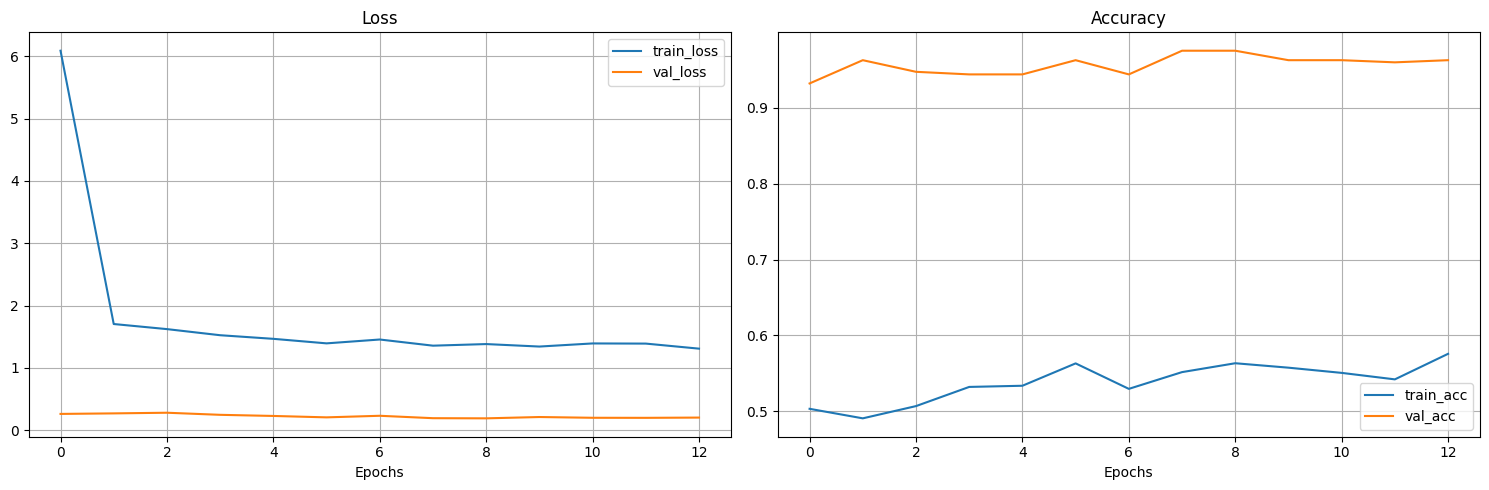

In [ ]:
# plot the curves
plot_loss_curves(model_3_results)

We observe how the training process benefits by early stopping in both the loss and validation learning curves. If we look closer at training results on the accuracies results, we notice that the validation accuracy most of time remains higher than the training accuracy and when it goes down the training stops and saves best previous training state (weights). This effect confirms us that the model is not overfitting.

In [ ]:
# evaluate on test set/dataloader
model_3_test_results = eval_model(model=model_3_2,
                                  dataloader=test_dataloader_M,
                                  loss_fn=nn.CrossEntropyLoss(weight=class_weights_M))
model_3_test_results['test_acc']

  0%|          | 0/5 [00:00<?, ?it/s]

0.972554347826087

As theoretically expected, the combination of a balanced dataset and data augmentation achieves the highest test accuracy among all cases, considering the best performing weights obtained so far.

In [ ]:
# save the model
torch.save(model_3_2.state_dict(), 'model_3_M.pth')
print("Model saved to 'model_3_M.pth'")

# save the results on test set
model_3_test_results_df = pd.DataFrame(model_3_test_results)
model_3_test_results_df.to_csv('model_3_test_results_df.csv', index=False)
print("Results saved to 'model_3_test_results_df.csv'")

Model saved to 'model_3_M.pth'
Results saved to 'model_3_test_results_df.csv'


## 6. Compare the models, select the best and next experiments.

Now, let's compare the performance of all three models trained above taking only into account their test accuracy.

In [ ]:
# retrieve all models accuracies
model_1_acc = model_1_test_results['test_acc'].iloc[0]
model_2_acc = model_2_test_results['test_acc'].iloc[0]
model_3_acc = model_3_test_results['test_acc'].iloc[0]

# create a dataframe for comparison (dictionary with model's name and test accuracy)
compare_accs = pd.DataFrame({
    'model': ['model_1', 'model_2', 'model_3'],
    'test_acc': [model_1_acc, model_2_acc, model_3_acc]
})

# print the results
print(compare_accs)

     model  test_acc
0  model_1  0.892663
1  model_2  0.913859
2  model_3  0.972554


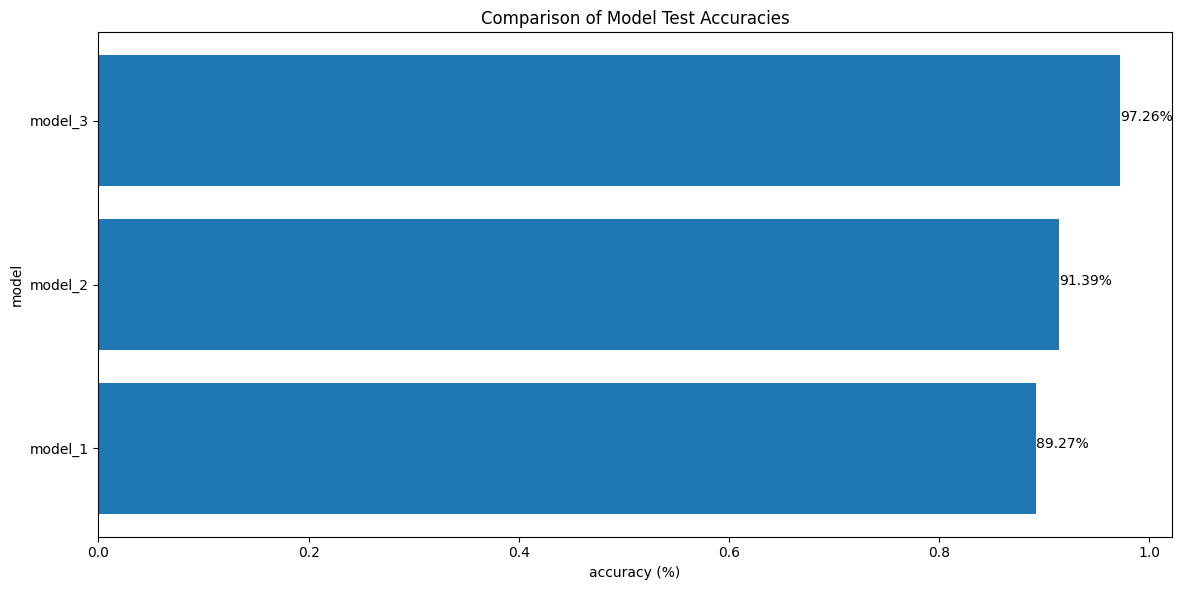

In [10]:
# visualize models test accuracies
plt.figure(figsize=(12, 6))
plt.barh(compare_accs['model'], compare_accs['test_acc'])
plt.xlabel("accuracy (%)")
plt.ylabel("model")
plt.title("Comparison of Model Test Accuracies")

# display the values on bars
for index, value in enumerate(compare_accs["test_acc"]):
  plt.text(value, index, f"{value * 100:.2f}%")

plt.tight_layout()
plt.show()

For our experiments on the dataset of images from the center camera, model 3 achieved the best performance. Its configuration is comprised of the optimal hyperparameters, including:

*   best performing weight decay for L2 regularization (0.001).
*   optimal dropout probabilities combination to address overfitting ([0.4, 0.5, 0.5, 0.5]).
*   best hidden unit configuration on the given CNN architecture ([64, 32, 64]).
*   optimal learning rate (0.001) and optimizer (NAdam).
*   optimal activations functions (GELU for feataure extractor and ELU for classifier).
*   batch size of 32.
*   effective cross validation, dataset balancing and data augmentation (Trivial).



We conducted a series of experiments to identify the best-performing model for ```M/M```, where training and testing were both performed on images from the center camera (M). Next, we will extend this approach to other configurations, including ```L/L```, ```R/R```, ```M,L/R```, ```M,R/L```, ```L,R/M```, and a (given) ```smaller dataset``` .

In addition, we will explore [transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) on the smaller dataset to examine its impact on performance. To do all this process, we have to automate all the above experimental pipeline, making it modular and adaptable for efficient model evaluation across different datasets and configurations.

Two additional notebooks handle this task: ```full_experimentation_on_ResActionsImages_variants_and_transfer_learning_with_CNNs.ipynb``` and ```create_src_dir.ipynb```.

The entire code structure and implementation is based on our previous work with [custom datasets](https://github.com/GiX7000/deep-learning-with-pytorch/blob/main/learn-pytorch-with-X/Part05_pytorch_custom_datasets.ipynb) and [training CNNs](https://github.com/GiX7000/deep-learning-with-pytorch/blob/main/learn-pytorch-with-X/Part04_pytorch_computer_vision.ipynb), including key insights and best practices from that resources. These reference notebooks serve as a crucial baseline methodology, ensuring a well-integrated and optimized approach for our experiments.